In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=True
maskedgeName='knn20_connectivity'
epochs=10000
saveFreq=10
lr=0.001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

hidden1=5000 #Number of units in hidden layer 1
hidden2=5000 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
fc_dim1=5000
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# clf_hidden=256
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=20
# clfweight=20
advWeight=2
# randFeatureSubset=None
model_str='gcn_vae_xa_e2_d1_dca'
clf=None
adv=None  #'clf_fc1_eq'  #'clf_fc1_control_eq' #'clf_fc1_control'  #'clf_fc1'
protein=None #'scaled_binary'
proteinWeights=0.05
adj_decodeName=None #gala or None
ridgeL=0.01
shareGenePi=True

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
num_features=2112
# training_samples=['control13','disease13','disease8']###rename and retrain C8
training_samples=['control13','disease13','disease8','control8']
# training_samples=['control13','control8']
targetBatch=None
training_sample_X='logminmax'
switchFreq=10
standardizeX=False
# name='allk20XA_01_dca_noD8' ###rename and retrain D8 C8
name='allk20XA_05_dca_over'
logsavepath='/mnt/external_ssd/xinyi/log/train_gae_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_gae_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/'+name
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/home/xinyiz/starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in sampleidx.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==sampleidx[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==sampleidx[s]])

else:
    scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in sampleidx.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==sampleidx[s]]

        if training_sample_X=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        elif training_sample_X=='logminmax10':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler(feature_range=(0,10))
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)

if protein:
    proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
    for s in sampleidx.keys():
        pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
        pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
        pmtx=pmtx.to_dense()
        scalefactor=torch.sum(featureslist[s+'X_'+training_sample_X])/torch.sum(pmtx)*proteinWeights
        featureslist[s+'X_'+training_sample_X]=torch.cat((featureslist[s+'X_'+training_sample_X],pmtx*scalefactor),dim=1)
            
if clf:
    ctlist={}
    ctlist['disease13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9494','top_level'].to_numpy()
    ctlist['control13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9498','top_level'].to_numpy()
    ctlist['disease8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9723','top_level'].to_numpy()
    ctlist['control8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'].to_numpy()
    ct_unique=np.unique(scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'])
    for k in ctlist.keys():
        for i in range(ct_unique.size):
            ctlist[k][ctlist[k]==ct_unique[i]]=i
    
adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adjnormlist={}
pos_weightlist={}
normlist={}
for ai in adj_list.keys():
    adjnormlist[ai]=preprocessing.preprocess_graph(adj_list[ai])
    
    pos_weightlist[ai] = torch.tensor(float(adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) / adj_list[ai].sum()) #using full unmasked adj
    normlist[ai] = adj_list[ai].shape[0] * adj_list[ai].shape[0] / float((adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) * 2)
    
    adj_label=adj_list[ai] + sp.eye(adj_list[ai].shape[0])
    adj_list[ai]=torch.tensor(adj_label.todense())
    
if adv:
    if 'control_eq' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0.5,0.5]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([0.5,0.5]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)
    elif 'control' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)        
    elif 'eq' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
    else:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0,1,1,1]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([1,0,1,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([1,1,0,1]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,1,1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
        
    
        
    
# adj_decode=None
# if adj_decodeName == 'gala':
#     adj_decode=preprocessing.preprocess_graph_sharp(adj_train)



if 'dca' in model_str:
    rawdata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
    features_raw_list={}
    for s in sampleidx.keys():
#         features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]]).cuda()
        features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]])
        if protein:
            proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
            pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
            pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
            pmtx=pmtx.to_dense()
            scalefactor=torch.sum(features_raw_list[s+'X_raw'])/torch.sum(pmtx)*proteinWeights
            features_raw_list[s+'X_raw']=torch.cat((features_raw_list[s+'X_raw'],pmtx*scalefactor),dim=1)

if clf:
    ct_train=ctlist[training_samples].astype(int)
# features=torch.tensor(np.identity(7000)).float()
# features=features[0:10,:]
if standardizeX:
    features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [5]:
# loop over all train/validation sets

mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='gcn_vae_xa':
    model = gae.gae.model.GCNModelVAE_XA(num_features, hidden1, hidden2,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
elif model_str == 'gcn_vae_gcnX_inprA':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_gcnX_inprA_w':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA_w(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='gcn_vae_xa_e3':
    model = gae.gae.model.GCNModelVAE_XA_e3(num_features, hidden1, hidden2,hidden3,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_xa_e1':
    model = gae.gae.model.GCNModelVAE_XA_e1(num_features, hidden1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE

elif model_str == 'gcn_vae_xa_e2_d1':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1(num_features, hidden1,hidden2, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str=='gcn_vae_xa_e2_d1_dca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dca_fca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_fca(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE
    
elif model_str=='gcn_vae_xa_e2_d1_dcaFork':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAfork(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaElemPi':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAelemPi(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaConstantDisp':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_constantDisp(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE    
    
elif model_str == 'gcn_vae_xa_e4_d1':
    model = gae.gae.model.GCNModelVAE_XA_e4_d1(num_features, hidden1,hidden2,hidden3,hidden4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc':
    model = gae.gae.model.FCVAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
    loss_a=optimizer.optimizer_CE
elif model_str=='fcae':
    model = gae.gae.model.FCAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse

elif model_str=='fcae1':
    model = gae.gae.model.FCAE1(num_features, dropout,hidden1)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
elif model_str=='fcae2':
    model = gae.gae.model.FCAE2(num_features, dropout,hidden1,hidden2)
    loss_x=optimizer.optimizer_MSE

elif model_str=='fc1':
    model = gae.gae.model.FCVAE1(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

elif model_str=='fc1_fca':
    model = gae.gae.model.FCVAE1_fca(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc1_dca':
    model = gae.gae.model.FCVAE1_DCA(num_features, hidden1,fc_dim1, dropout)
    loss_x=optimizer.optimizer_zinb
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

if clf=='clf_fc1':
    modelClf=gae.gae.model.Clf_fc1(hidden2, dropout,clf_hidden,ct_unique.size)
    loss_clf=torch.nn.CrossEntropyLoss()
    
if adv=='clf_fc1' or adv=='clf_fc1_eq' or adv=='clf_fc1_control' or adv=='clf_fc1_control_eq':
    modelAdv=gae.gae.model.Clf_fc1(hidden2, dropout,adv_hidden,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if adv=='clf_linear1' or adv=='clf_linear1_control':
    modelAdv=gae.gae.model.Clf_linear1(hidden2, dropout,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if 'NB' in name:
    print('using NB loss for X')
    loss_x=optimizer.optimizer_nb
    
if use_cuda:
    model.cuda()
    if clf:
        modelClf.cuda()
        ct_train=torch.tensor(ct_train).cuda()
    if adv:
        modelAdv.cuda()
#         for sk in sampleLabellist_ae.keys():
#             sampleLabellist_ae[sk]=sampleLabellist_ae[sk].cuda().float()
#             sampleLabellist_d[sk]=sampleLabellist_d[sk].cuda().float()
#     for fk in featureslist.keys():
#         featureslist[fk] = featureslist[fk].cuda().float()
#     for ak in adj_list.keys():
#         adjnormlist[ak] =adjnormlist[ak].cuda()
#         adj_list[ak] = adj_list[ak].cuda().float()
#     if adj_decode is not None:
#         adj_decode=adj_decode.cuda()
    

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if clf:
    optimizerClf=optim.Adam(modelClf.parameters(), lr=lr, weight_decay=weight_decay)
if adv:
    optimizerAdv=optim.Adam(modelAdv.parameters(), lr=lr_adv, weight_decay=weight_decay)    


In [6]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
# epochs=20000
if pretrainedAE:
    print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
    model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    optimizerVAEXA.zero_grad()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.train()
        optimizerClf.zero_grad()
        clfOut=modelClf(z)
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        modelAdv.eval()
        advOut=modelAdv(z)
    
#     z=None
#     torch.cuda.empty_cache()
    
    loss_kl_train=loss_kl(mu, logvar, train_nodes_idx)
    
#     mu=None
#     logvar=None
#     torch.cuda.empty_cache()
    
    if 'dca' in model_str:
        if 'NB' in name:
            loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight)
        else:
            loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,mse)
    
#     features_recon=None
#     torch.cuda.empty_cache()
    
    loss_a_train=loss_a(adj_recon, adj_label, pos_weight, norm,train_nodes_idx)
    
#     adj_recon=None
# #     train_nodes_idx=None
#     torch.cuda.empty_cache()
    
    loss = loss_kl_train+loss_x_train+loss_a_train
#     loss=loss_x_train #for lossXreconOnly only
#     loss=loss_kl_train+loss_x_train #for lossXreconOnly_wKL only
#     loss = loss_kl_train+loss_a_train #for lossAreconOnly_wKL only
    if clf:
        loss_clf_train=loss_clf(clfOut[train_nodes_idx],ct_train[train_nodes_idx])
        loss=loss+clfweight*loss_clf_train
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        loss_adv_train=loss_adv(advOut,sampleLabel_ae,train_nodes_idx)
        loss+=loss_adv_train*advWeight
    loss.backward()
    optimizerVAEXA.step()
    if clf:
        optimizerClf.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run & no variation in z.
        model.eval()
        if adj_decodeName==None:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    #         features_recon, z, mu, logvar=model(features.float())
        else:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        advOut=modelAdv(z)
    if 'dca' in model_str:
        if 'NB' in name:
            loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight)
        else:
            loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,mse)
    
#     features_recon=None
#     torch.cuda.empty_cache()
    
    loss_a_val=loss_a(adj_recon, adj_label, pos_weight, norm,val_nodes_idx)
    
#     adj_recon=None
# #     val_nodes_idx=None
#     torch.cuda.empty_cache()
    
    loss_val = loss_x_val+loss_a_val
#     loss_val=loss_x_val
#     loss_val=loss_a_val
    if clf:
        loss_clf_val=loss_clf(clfOut[val_nodes_idx],ct_train[val_nodes_idx])
        loss_val=loss_val+clfweight*loss_clf_val
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        loss_adv_val=loss_adv(advOut,sampleLabel_ae,val_nodes_idx)
        loss_val+=loss_adv_val*advWeight
#     print(features_recon[:5,:5])
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss.item()),
          'loss_kl_train: {:.4f}'.format(loss_kl_train.item()),
          'loss_x_train: {:.4f}'.format(loss_x_train.item()),
          'loss_a_train: {:.4f}'.format(loss_a_train.item()),
#           'loss_clf_train: {:.4f}'.format(loss_clf_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'loss_x_val: {:.4f}'.format(loss_x_val.item()),
          'loss_a_val: {:.4f}'.format(loss_a_val.item()),
#           'loss_clf_val: {:.4f}'.format(loss_clf_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        print('loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
              'loss_adv_val: {:.4f}'.format(loss_adv_val.item())
             )
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if clf:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item(),loss_clf_train.item(),loss_clf_val.item()
    elif adv:
        if (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),float(loss_adv_train),float(loss_adv_val)        
        else:
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),None,None   
    else:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item()        

def train_discriminator(epoch):
    t = time.time()
    model.eval()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
        
    modelAdv.train()
    optimizerAdv.zero_grad()
    advOut=modelAdv(z)
    
    loss_adv_train=loss_adv(advOut,sampleLabel_d,train_nodes_idx)
    loss = loss_adv_train*advWeight
    
    loss.backward()
    optimizerAdv.step()

    modelAdv.eval()
    advOut=modelAdv(z)
    loss_adv_val=loss_adv(advOut,sampleLabel_d,val_nodes_idx)
    loss_val=loss_adv_val*advWeight
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
          'loss_adv_val: {:.4f}'.format(loss_adv_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return float(loss_adv_train),float(loss_adv_val)
    
# print('cross-validation ',seti)
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_a_ep=[None]*epochs
train_loss_clf_ep=[None]*epochs
train_loss_adv_ep=[None]*epochs
train_loss_advD_ep=[None]*epochs
val_loss_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_a_ep=[None]*epochs
val_loss_clf_ep=[None]*epochs
val_loss_adv_ep=[None]*epochs
val_loss_advD_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
# for ep in range(10000,20000):
    t=int(ep/switchFreq)%len(training_samples)
    training_samples_t=training_samples[t]
    
#     adj_norm=adjnormlist[training_samples_t]
#     adj_label=adj_list[training_samples_t]
#     features=featureslist[training_samples_t+'X_'+training_sample_X]
    adj_norm=adjnormlist[training_samples_t].cuda().float()
    adj_label=adj_list[training_samples_t].cuda().float()
    features=featureslist[training_samples_t+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[training_samples_t]
    norm=normlist[training_samples_t]
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
#         sampleLabel_ae=sampleLabellist_ae[training_samples_t]
#         sampleLabel_d=sampleLabellist_d[training_samples_t]
        sampleLabel_ae=sampleLabellist_ae[training_samples_t].cuda().float()
        sampleLabel_d=sampleLabellist_d[training_samples_t].cuda().float()
    if 'dca' in model_str:
#         features_raw=features_raw_list[training_samples_t+'X_raw']
        features_raw=features_raw_list[training_samples_t+'X_raw'].cuda()
    num_nodes,_ = features.shape
    
    maskpath=os.path.join(savedir,'trainMask',training_samples_t+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes,seed=seed)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    if use_cuda:
        train_nodes_idx=train_nodes_idx.cuda()
        val_nodes_idx=val_nodes_idx.cuda()
        test_nodes_idx=test_nodes_idx.cuda()
    
    if clf:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_clf_ep[ep],val_loss_clf_ep[ep]=train(ep)
    elif adv:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_adv_ep[ep],val_loss_adv_ep[ep]=train(ep)
        if (training_samples_t in list(sampleLabellist_ae.keys())):
            train_loss_advD_ep[ep],val_loss_advD_ep[ep]=train_discriminator(ep)
    else:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


control13 Epoch: 0000 loss_train: 37.3863 loss_kl_train: 0.0012 loss_x_train: 7.8005 loss_a_train: 29.5845 loss_val: 15.1163 loss_x_val: 7.2588 loss_a_val: 7.8575 time: 1.5624s
control13 Epoch: 0001 loss_train: 32.0748 loss_kl_train: 0.0015 loss_x_train: 3.1748 loss_a_train: 28.8985 loss_val: 8.4317 loss_x_val: 7.4562 loss_a_val: 0.9755 time: 0.8816s
control13 Epoch: 0002 loss_train: 31.4137 loss_kl_train: 0.0001 loss_x_train: 3.0860 loss_a_train: 28.3275 loss_val: 10.2407 loss_x_val: 7.1578 loss_a_val: 3.0829 time: 0.8828s
control13 Epoch: 0003 loss_train: 31.4173 loss_kl_train: 0.0006 loss_x_train: 3.0628 loss_a_train: 28.3540 loss_val: 10.7606 loss_x_val: 7.4073 loss_a_val: 3.3533 time: 0.8840s
control13 Epoch: 0004 loss_train: 31.1901 loss_kl_train: 0.0006 loss_x_train: 2.9983 loss_a_train: 28.1912 loss_val: 9.4261 loss_x_val: 7.5917 loss_a_val: 1.8344 time: 0.8837s
control13 Epoch: 0005 loss_train: 31.0442 loss_kl_train: 0.0004 loss_x_train: 2.8749 loss_a_train: 28.1689 loss_val: 

control13 Epoch: 0047 loss_train: 16.9412 loss_kl_train: 0.0962 loss_x_train: 1.3921 loss_a_train: 15.4529 loss_val: 9.0749 loss_x_val: 5.6260 loss_a_val: 3.4489 time: 0.8994s
control13 Epoch: 0048 loss_train: 14.4598 loss_kl_train: 0.1027 loss_x_train: 1.3893 loss_a_train: 12.9678 loss_val: 12.5232 loss_x_val: 4.9964 loss_a_val: 7.5268 time: 0.8989s
control13 Epoch: 0049 loss_train: 15.6256 loss_kl_train: 0.1120 loss_x_train: 1.3874 loss_a_train: 14.1262 loss_val: 9.2665 loss_x_val: 5.2550 loss_a_val: 4.0115 time: 0.8999s
disease13 Epoch: 0050 loss_train: 13.9190 loss_kl_train: 0.1090 loss_x_train: 1.5232 loss_a_train: 12.2869 loss_val: 10.2054 loss_x_val: 5.3946 loss_a_val: 4.8108 time: 1.2471s
disease13 Epoch: 0051 loss_train: 13.5602 loss_kl_train: 0.1158 loss_x_train: 1.5205 loss_a_train: 11.9239 loss_val: 17.9955 loss_x_val: 4.7452 loss_a_val: 13.2502 time: 1.2479s
disease13 Epoch: 0052 loss_train: 18.6043 loss_kl_train: 0.1247 loss_x_train: 1.5185 loss_a_train: 16.9611 loss_val:

disease13 Epoch: 0094 loss_train: 10.9001 loss_kl_train: 0.3137 loss_x_train: 1.4925 loss_a_train: 9.0939 loss_val: 11.1291 loss_x_val: 4.5927 loss_a_val: 6.5365 time: 1.2624s
disease13 Epoch: 0095 loss_train: 10.8102 loss_kl_train: 0.3168 loss_x_train: 1.4923 loss_a_train: 9.0011 loss_val: 11.0559 loss_x_val: 4.6623 loss_a_val: 6.3936 time: 1.2647s
disease13 Epoch: 0096 loss_train: 10.5827 loss_kl_train: 0.3199 loss_x_train: 1.4922 loss_a_train: 8.7706 loss_val: 11.0801 loss_x_val: 4.9065 loss_a_val: 6.1737 time: 1.2639s
disease13 Epoch: 0097 loss_train: 10.4152 loss_kl_train: 0.3225 loss_x_train: 1.4924 loss_a_train: 8.6003 loss_val: 10.8477 loss_x_val: 4.9306 loss_a_val: 5.9171 time: 1.2659s
disease13 Epoch: 0098 loss_train: 10.2042 loss_kl_train: 0.3249 loss_x_train: 1.4922 loss_a_train: 8.3870 loss_val: 11.1598 loss_x_val: 4.9446 loss_a_val: 6.2152 time: 1.2640s
disease13 Epoch: 0099 loss_train: 10.3278 loss_kl_train: 0.3275 loss_x_train: 1.4922 loss_a_train: 8.5081 loss_val: 10.5

disease8 Epoch: 0142 loss_train: 7.2495 loss_kl_train: 0.4819 loss_x_train: 1.2987 loss_a_train: 5.4688 loss_val: 7.1278 loss_x_val: 4.4245 loss_a_val: 2.7033 time: 0.8445s
disease8 Epoch: 0143 loss_train: 7.2335 loss_kl_train: 0.4859 loss_x_train: 1.2997 loss_a_train: 5.4480 loss_val: 6.8129 loss_x_val: 4.1745 loss_a_val: 2.6384 time: 0.8439s
disease8 Epoch: 0144 loss_train: 7.1847 loss_kl_train: 0.4901 loss_x_train: 1.2996 loss_a_train: 5.3950 loss_val: 6.8118 loss_x_val: 4.1311 loss_a_val: 2.6807 time: 0.8459s
disease8 Epoch: 0145 loss_train: 7.1582 loss_kl_train: 0.4945 loss_x_train: 1.2991 loss_a_train: 5.3646 loss_val: 6.8003 loss_x_val: 4.1154 loss_a_val: 2.6848 time: 0.8450s
disease8 Epoch: 0146 loss_train: 7.1522 loss_kl_train: 0.4993 loss_x_train: 1.3001 loss_a_train: 5.3527 loss_val: 6.8453 loss_x_val: 4.1646 loss_a_val: 2.6807 time: 0.8450s
disease8 Epoch: 0147 loss_train: 7.0860 loss_kl_train: 0.5040 loss_x_train: 1.2993 loss_a_train: 5.2826 loss_val: 6.7778 loss_x_val: 4.

control8 Epoch: 0190 loss_train: 6.0077 loss_kl_train: 0.6957 loss_x_train: 1.4473 loss_a_train: 3.8647 loss_val: 7.2384 loss_x_val: 4.6576 loss_a_val: 2.5808 time: 0.9630s
control8 Epoch: 0191 loss_train: 5.9469 loss_kl_train: 0.6986 loss_x_train: 1.4470 loss_a_train: 3.8013 loss_val: 7.2849 loss_x_val: 4.7323 loss_a_val: 2.5526 time: 0.9619s
control8 Epoch: 0192 loss_train: 5.9057 loss_kl_train: 0.7013 loss_x_train: 1.4461 loss_a_train: 3.7583 loss_val: 7.6969 loss_x_val: 5.1265 loss_a_val: 2.5704 time: 0.9640s
control8 Epoch: 0193 loss_train: 5.9486 loss_kl_train: 0.7036 loss_x_train: 1.4468 loss_a_train: 3.7982 loss_val: 7.2674 loss_x_val: 4.6820 loss_a_val: 2.5855 time: 0.9645s
control8 Epoch: 0194 loss_train: 5.9430 loss_kl_train: 0.7056 loss_x_train: 1.4463 loss_a_train: 3.7911 loss_val: 7.3110 loss_x_val: 4.6957 loss_a_val: 2.6153 time: 0.9630s
control8 Epoch: 0195 loss_train: 5.9615 loss_kl_train: 0.7074 loss_x_train: 1.4466 loss_a_train: 3.8075 loss_val: 7.6044 loss_x_val: 5.

control8 Epoch: 0238 loss_train: 6.3345 loss_kl_train: 0.7018 loss_x_train: 1.4389 loss_a_train: 4.1937 loss_val: 7.8497 loss_x_val: 4.8727 loss_a_val: 2.9771 time: 0.9697s
control8 Epoch: 0239 loss_train: 6.1893 loss_kl_train: 0.6983 loss_x_train: 1.4387 loss_a_train: 4.0523 loss_val: 7.9084 loss_x_val: 5.0530 loss_a_val: 2.8553 time: 0.9679s
control13 Epoch: 0240 loss_train: 6.0147 loss_kl_train: 0.6535 loss_x_train: 1.3577 loss_a_train: 4.0035 loss_val: 8.4513 loss_x_val: 5.5198 loss_a_val: 2.9315 time: 0.9263s
control13 Epoch: 0241 loss_train: 6.2488 loss_kl_train: 0.6499 loss_x_train: 1.3574 loss_a_train: 4.2415 loss_val: 7.3439 loss_x_val: 4.6829 loss_a_val: 2.6611 time: 0.9237s
control13 Epoch: 0242 loss_train: 6.1483 loss_kl_train: 0.6500 loss_x_train: 1.3558 loss_a_train: 4.1425 loss_val: 6.9781 loss_x_val: 4.0341 loss_a_val: 2.9441 time: 0.9262s
control13 Epoch: 0243 loss_train: 6.4054 loss_kl_train: 0.6499 loss_x_train: 1.3561 loss_a_train: 4.3994 loss_val: 6.9453 loss_x_val

control13 Epoch: 0286 loss_train: 6.1458 loss_kl_train: 0.5430 loss_x_train: 1.3522 loss_a_train: 4.2506 loss_val: 7.2721 loss_x_val: 5.1803 loss_a_val: 2.0918 time: 0.9372s
control13 Epoch: 0287 loss_train: 6.0837 loss_kl_train: 0.5433 loss_x_train: 1.3525 loss_a_train: 4.1879 loss_val: 7.5267 loss_x_val: 5.4035 loss_a_val: 2.1232 time: 0.9326s
control13 Epoch: 0288 loss_train: 6.0372 loss_kl_train: 0.5446 loss_x_train: 1.3523 loss_a_train: 4.1403 loss_val: 7.3758 loss_x_val: 5.4000 loss_a_val: 1.9758 time: 0.9278s
control13 Epoch: 0289 loss_train: 5.9988 loss_kl_train: 0.5473 loss_x_train: 1.3519 loss_a_train: 4.0997 loss_val: 7.5466 loss_x_val: 5.5861 loss_a_val: 1.9605 time: 0.9257s
disease13 Epoch: 0290 loss_train: 5.8297 loss_kl_train: 0.4967 loss_x_train: 1.4852 loss_a_train: 3.8478 loss_val: 7.3727 loss_x_val: 5.1914 loss_a_val: 2.1813 time: 1.2850s
disease13 Epoch: 0291 loss_train: 5.7572 loss_kl_train: 0.4998 loss_x_train: 1.4839 loss_a_train: 3.7735 loss_val: 7.6729 loss_x_v

disease13 Epoch: 0334 loss_train: 4.6332 loss_kl_train: 0.6809 loss_x_train: 1.4895 loss_a_train: 2.4628 loss_val: 5.9524 loss_x_val: 4.3732 loss_a_val: 1.5792 time: 1.2814s
disease13 Epoch: 0335 loss_train: 4.6184 loss_kl_train: 0.6838 loss_x_train: 1.4895 loss_a_train: 2.4451 loss_val: 5.9085 loss_x_val: 4.3845 loss_a_val: 1.5240 time: 1.2804s
disease13 Epoch: 0336 loss_train: 4.6017 loss_kl_train: 0.6865 loss_x_train: 1.4899 loss_a_train: 2.4253 loss_val: 6.2454 loss_x_val: 4.6680 loss_a_val: 1.5774 time: 1.2788s
disease13 Epoch: 0337 loss_train: 4.6317 loss_kl_train: 0.6887 loss_x_train: 1.4885 loss_a_train: 2.4546 loss_val: 5.4492 loss_x_val: 3.8524 loss_a_val: 1.5968 time: 1.2804s
disease13 Epoch: 0338 loss_train: 4.6707 loss_kl_train: 0.6916 loss_x_train: 1.4891 loss_a_train: 2.4901 loss_val: 5.3002 loss_x_val: 3.6433 loss_a_val: 1.6569 time: 1.2831s
disease13 Epoch: 0339 loss_train: 4.7258 loss_kl_train: 0.6938 loss_x_train: 1.4892 loss_a_train: 2.5427 loss_val: 5.4644 loss_x_v

disease8 Epoch: 0382 loss_train: 5.3008 loss_kl_train: 0.7746 loss_x_train: 1.2904 loss_a_train: 3.2358 loss_val: 5.9754 loss_x_val: 4.1052 loss_a_val: 1.8702 time: 0.8488s
disease8 Epoch: 0383 loss_train: 5.1978 loss_kl_train: 0.7796 loss_x_train: 1.2897 loss_a_train: 3.1285 loss_val: 5.5205 loss_x_val: 3.3240 loss_a_val: 2.1965 time: 0.8481s
disease8 Epoch: 0384 loss_train: 5.4527 loss_kl_train: 0.7843 loss_x_train: 1.2880 loss_a_train: 3.3804 loss_val: 5.4972 loss_x_val: 3.0176 loss_a_val: 2.4795 time: 0.8486s
disease8 Epoch: 0385 loss_train: 5.6987 loss_kl_train: 0.7878 loss_x_train: 1.2880 loss_a_train: 3.6229 loss_val: 5.6160 loss_x_val: 2.9469 loss_a_val: 2.6691 time: 0.8474s
disease8 Epoch: 0386 loss_train: 5.8439 loss_kl_train: 0.7894 loss_x_train: 1.2880 loss_a_train: 3.7665 loss_val: 5.7812 loss_x_val: 3.0435 loss_a_val: 2.7377 time: 0.8499s
disease8 Epoch: 0387 loss_train: 5.9225 loss_kl_train: 0.7895 loss_x_train: 1.2875 loss_a_train: 3.8455 loss_val: 5.9608 loss_x_val: 3.

control8 Epoch: 0430 loss_train: 5.3862 loss_kl_train: 0.7453 loss_x_train: 1.4357 loss_a_train: 3.2053 loss_val: 6.3951 loss_x_val: 4.3569 loss_a_val: 2.0383 time: 0.9652s
control8 Epoch: 0431 loss_train: 5.1891 loss_kl_train: 0.7494 loss_x_train: 1.4296 loss_a_train: 3.0102 loss_val: 6.3018 loss_x_val: 4.2335 loss_a_val: 2.0683 time: 0.9637s
control8 Epoch: 0432 loss_train: 5.2152 loss_kl_train: 0.7521 loss_x_train: 1.4303 loss_a_train: 3.0328 loss_val: 6.3908 loss_x_val: 4.3589 loss_a_val: 2.0318 time: 0.9648s
control8 Epoch: 0433 loss_train: 5.1979 loss_kl_train: 0.7536 loss_x_train: 1.4298 loss_a_train: 3.0145 loss_val: 6.6284 loss_x_val: 4.6902 loss_a_val: 1.9381 time: 0.9669s
control8 Epoch: 0434 loss_train: 5.1054 loss_kl_train: 0.7535 loss_x_train: 1.4300 loss_a_train: 2.9219 loss_val: 7.0648 loss_x_val: 5.2349 loss_a_val: 1.8299 time: 0.9654s
control8 Epoch: 0435 loss_train: 5.0365 loss_kl_train: 0.7526 loss_x_train: 1.4309 loss_a_train: 2.8531 loss_val: 7.4533 loss_x_val: 5.

control8 Epoch: 0478 loss_train: 4.8916 loss_kl_train: 0.9317 loss_x_train: 1.4327 loss_a_train: 2.5271 loss_val: 4.5268 loss_x_val: 2.5186 loss_a_val: 2.0081 time: 0.9644s
control8 Epoch: 0479 loss_train: 4.9580 loss_kl_train: 0.9351 loss_x_train: 1.4320 loss_a_train: 2.5909 loss_val: 4.7849 loss_x_val: 2.8117 loss_a_val: 1.9732 time: 0.9651s
control13 Epoch: 0480 loss_train: 4.9374 loss_kl_train: 0.8837 loss_x_train: 1.3501 loss_a_train: 2.7036 loss_val: 5.1592 loss_x_val: 3.3834 loss_a_val: 1.7758 time: 0.9261s
control13 Epoch: 0481 loss_train: 4.8405 loss_kl_train: 0.8834 loss_x_train: 1.3496 loss_a_train: 2.6075 loss_val: 5.8391 loss_x_val: 4.2457 loss_a_val: 1.5934 time: 0.9250s
control13 Epoch: 0482 loss_train: 4.6782 loss_kl_train: 0.8818 loss_x_train: 1.3504 loss_a_train: 2.4460 loss_val: 6.8840 loss_x_val: 5.4783 loss_a_val: 1.4057 time: 0.9250s
control13 Epoch: 0483 loss_train: 4.5226 loss_kl_train: 0.8793 loss_x_train: 1.3524 loss_a_train: 2.2910 loss_val: 8.2444 loss_x_val

control13 Epoch: 0526 loss_train: 4.5040 loss_kl_train: 0.8555 loss_x_train: 1.3490 loss_a_train: 2.2995 loss_val: 7.4555 loss_x_val: 5.9853 loss_a_val: 1.4702 time: 0.9256s
control13 Epoch: 0527 loss_train: 4.5787 loss_kl_train: 0.8533 loss_x_train: 1.3523 loss_a_train: 2.3731 loss_val: 5.9410 loss_x_val: 4.5982 loss_a_val: 1.3429 time: 0.9261s
control13 Epoch: 0528 loss_train: 4.4456 loss_kl_train: 0.8574 loss_x_train: 1.3468 loss_a_train: 2.2414 loss_val: 5.2307 loss_x_val: 3.7883 loss_a_val: 1.4424 time: 0.9256s
control13 Epoch: 0529 loss_train: 4.5257 loss_kl_train: 0.8603 loss_x_train: 1.3468 loss_a_train: 2.3186 loss_val: 4.9569 loss_x_val: 3.4475 loss_a_val: 1.5095 time: 0.9261s
disease13 Epoch: 0530 loss_train: 4.6589 loss_kl_train: 0.7833 loss_x_train: 1.4783 loss_a_train: 2.3973 loss_val: 4.8905 loss_x_val: 3.0988 loss_a_val: 1.7917 time: 1.2807s
disease13 Epoch: 0531 loss_train: 4.6533 loss_kl_train: 0.7836 loss_x_train: 1.4781 loss_a_train: 2.3915 loss_val: 5.1202 loss_x_v

disease13 Epoch: 0574 loss_train: 6.2331 loss_kl_train: 0.6908 loss_x_train: 1.4817 loss_a_train: 4.0606 loss_val: 10.4389 loss_x_val: 4.6550 loss_a_val: 5.7839 time: 1.2782s
disease13 Epoch: 0575 loss_train: 8.9016 loss_kl_train: 0.6619 loss_x_train: 1.5274 loss_a_train: 6.7123 loss_val: 5.9694 loss_x_val: 3.0290 loss_a_val: 2.9404 time: 1.2774s
disease13 Epoch: 0576 loss_train: 5.8583 loss_kl_train: 0.6693 loss_x_train: 1.4798 loss_a_train: 3.7092 loss_val: 5.8521 loss_x_val: 2.4574 loss_a_val: 3.3947 time: 1.2792s
disease13 Epoch: 0577 loss_train: 6.2888 loss_kl_train: 0.6741 loss_x_train: 1.4763 loss_a_train: 4.1385 loss_val: 6.1132 loss_x_val: 2.3081 loss_a_val: 3.8050 time: 1.2797s
disease13 Epoch: 0578 loss_train: 6.6934 loss_kl_train: 0.6752 loss_x_train: 1.4764 loss_a_train: 4.5418 loss_val: 6.4828 loss_x_val: 2.3603 loss_a_val: 4.1226 time: 1.2792s
disease13 Epoch: 0579 loss_train: 7.0115 loss_kl_train: 0.6728 loss_x_train: 1.4774 loss_a_train: 4.8613 loss_val: 6.8749 loss_x_

disease8 Epoch: 0621 loss_train: 9.9886 loss_kl_train: 0.8964 loss_x_train: 1.2897 loss_a_train: 7.8025 loss_val: 7.3267 loss_x_val: 1.4554 loss_a_val: 5.8714 time: 0.8456s
disease8 Epoch: 0622 loss_train: 8.7610 loss_kl_train: 0.8643 loss_x_train: 1.2875 loss_a_train: 6.6091 loss_val: 6.7095 loss_x_val: 1.4596 loss_a_val: 5.2500 time: 0.8472s
disease8 Epoch: 0623 loss_train: 8.1486 loss_kl_train: 0.8346 loss_x_train: 1.2883 loss_a_train: 6.0258 loss_val: 6.2459 loss_x_val: 1.4897 loss_a_val: 4.7562 time: 0.8466s
disease8 Epoch: 0624 loss_train: 7.6921 loss_kl_train: 0.8064 loss_x_train: 1.2885 loss_a_train: 5.5972 loss_val: 5.7657 loss_x_val: 1.4970 loss_a_val: 4.2686 time: 0.8475s
disease8 Epoch: 0625 loss_train: 7.2795 loss_kl_train: 0.7809 loss_x_train: 1.2870 loss_a_train: 5.2115 loss_val: 5.4362 loss_x_val: 1.5398 loss_a_val: 3.8964 time: 0.8477s
disease8 Epoch: 0626 loss_train: 6.9592 loss_kl_train: 0.7566 loss_x_train: 1.2858 loss_a_train: 4.9167 loss_val: 5.1645 loss_x_val: 1.

disease8 Epoch: 0669 loss_train: 5.6424 loss_kl_train: 0.7052 loss_x_train: 1.2783 loss_a_train: 3.6588 loss_val: 5.3826 loss_x_val: 3.1382 loss_a_val: 2.2444 time: 0.8481s
control8 Epoch: 0670 loss_train: 5.8067 loss_kl_train: 0.7267 loss_x_train: 1.4210 loss_a_train: 3.6590 loss_val: 5.5331 loss_x_val: 2.8723 loss_a_val: 2.6609 time: 0.9655s
control8 Epoch: 0671 loss_train: 5.7340 loss_kl_train: 0.7236 loss_x_train: 1.4206 loss_a_train: 3.5898 loss_val: 5.5278 loss_x_val: 2.9714 loss_a_val: 2.5564 time: 0.9631s
control8 Epoch: 0672 loss_train: 5.6292 loss_kl_train: 0.7200 loss_x_train: 1.4202 loss_a_train: 3.4889 loss_val: 5.6214 loss_x_val: 3.1695 loss_a_val: 2.4520 time: 0.9632s
control8 Epoch: 0673 loss_train: 5.5630 loss_kl_train: 0.7167 loss_x_train: 1.4200 loss_a_train: 3.4263 loss_val: 5.5844 loss_x_val: 3.2598 loss_a_val: 2.3246 time: 0.9658s
control8 Epoch: 0674 loss_train: 5.4583 loss_kl_train: 0.7130 loss_x_train: 1.4201 loss_a_train: 3.3253 loss_val: 5.6867 loss_x_val: 3.

control8 Epoch: 0717 loss_train: 4.7703 loss_kl_train: 0.7839 loss_x_train: 1.4214 loss_a_train: 2.5650 loss_val: 4.4569 loss_x_val: 2.8529 loss_a_val: 1.6040 time: 0.9656s
control8 Epoch: 0718 loss_train: 4.7314 loss_kl_train: 0.7816 loss_x_train: 1.4234 loss_a_train: 2.5264 loss_val: 3.9444 loss_x_val: 2.4301 loss_a_val: 1.5143 time: 0.9662s
control8 Epoch: 0719 loss_train: 4.6491 loss_kl_train: 0.7810 loss_x_train: 1.4212 loss_a_train: 2.4469 loss_val: 3.7016 loss_x_val: 2.2611 loss_a_val: 1.4405 time: 0.9661s
control13 Epoch: 0720 loss_train: 4.7188 loss_kl_train: 0.7282 loss_x_train: 1.3402 loss_a_train: 2.6504 loss_val: 3.3889 loss_x_val: 2.1235 loss_a_val: 1.2655 time: 0.9278s
control13 Epoch: 0721 loss_train: 4.6627 loss_kl_train: 0.7282 loss_x_train: 1.3406 loss_a_train: 2.5939 loss_val: 3.2779 loss_x_val: 2.0421 loss_a_val: 1.2359 time: 0.9234s
control13 Epoch: 0722 loss_train: 4.6407 loss_kl_train: 0.7287 loss_x_train: 1.3417 loss_a_train: 2.5703 loss_val: 3.1397 loss_x_val:

control13 Epoch: 0765 loss_train: 4.2347 loss_kl_train: 0.8516 loss_x_train: 1.3392 loss_a_train: 2.0439 loss_val: 3.3549 loss_x_val: 2.2640 loss_a_val: 1.0909 time: 0.9248s
control13 Epoch: 0766 loss_train: 4.2215 loss_kl_train: 0.8537 loss_x_train: 1.3394 loss_a_train: 2.0284 loss_val: 3.3874 loss_x_val: 2.3180 loss_a_val: 1.0694 time: 0.9256s
control13 Epoch: 0767 loss_train: 4.1848 loss_kl_train: 0.8566 loss_x_train: 1.3394 loss_a_train: 1.9888 loss_val: 3.4423 loss_x_val: 2.3830 loss_a_val: 1.0593 time: 0.9257s
control13 Epoch: 0768 loss_train: 4.1667 loss_kl_train: 0.8598 loss_x_train: 1.3398 loss_a_train: 1.9670 loss_val: 3.3492 loss_x_val: 2.3203 loss_a_val: 1.0289 time: 0.9258s
control13 Epoch: 0769 loss_train: 4.1491 loss_kl_train: 0.8633 loss_x_train: 1.3393 loss_a_train: 1.9465 loss_val: 3.3920 loss_x_val: 2.3669 loss_a_val: 1.0251 time: 0.9252s
disease13 Epoch: 0770 loss_train: 8.0920 loss_kl_train: 0.7805 loss_x_train: 1.5628 loss_a_train: 5.7488 loss_val: 3.4959 loss_x_v

disease13 Epoch: 0812 loss_train: 6.1700 loss_kl_train: 0.7019 loss_x_train: 1.4750 loss_a_train: 3.9930 loss_val: 5.2664 loss_x_val: 1.5211 loss_a_val: 3.7453 time: 1.2747s
disease13 Epoch: 0813 loss_train: 6.6080 loss_kl_train: 0.7136 loss_x_train: 1.4749 loss_a_train: 4.4195 loss_val: 5.6659 loss_x_val: 1.5253 loss_a_val: 4.1406 time: 1.2769s
disease13 Epoch: 0814 loss_train: 6.9940 loss_kl_train: 0.7223 loss_x_train: 1.4784 loss_a_train: 4.7933 loss_val: 5.9869 loss_x_val: 1.5206 loss_a_val: 4.4663 time: 1.2774s
disease13 Epoch: 0815 loss_train: 7.3165 loss_kl_train: 0.7276 loss_x_train: 1.4754 loss_a_train: 5.1135 loss_val: 6.2324 loss_x_val: 1.5267 loss_a_val: 4.7058 time: 1.2753s
disease13 Epoch: 0816 loss_train: 7.5436 loss_kl_train: 0.7296 loss_x_train: 1.4805 loss_a_train: 5.3335 loss_val: 6.3770 loss_x_val: 1.5242 loss_a_val: 4.8527 time: 1.2774s
disease13 Epoch: 0817 loss_train: 7.7152 loss_kl_train: 0.7291 loss_x_train: 1.4785 loss_a_train: 5.5075 loss_val: 6.4257 loss_x_v

disease8 Epoch: 0860 loss_train: 4.4890 loss_kl_train: 0.8045 loss_x_train: 1.2775 loss_a_train: 2.4070 loss_val: 2.8759 loss_x_val: 1.6641 loss_a_val: 1.2118 time: 0.8467s
disease8 Epoch: 0861 loss_train: 4.4952 loss_kl_train: 0.8097 loss_x_train: 1.2752 loss_a_train: 2.4103 loss_val: 2.9121 loss_x_val: 1.6910 loss_a_val: 1.2211 time: 0.8476s
disease8 Epoch: 0862 loss_train: 4.5073 loss_kl_train: 0.8147 loss_x_train: 1.2755 loss_a_train: 2.4171 loss_val: 2.9540 loss_x_val: 1.7321 loss_a_val: 1.2219 time: 0.8479s
disease8 Epoch: 0863 loss_train: 4.4805 loss_kl_train: 0.8197 loss_x_train: 1.2750 loss_a_train: 2.3858 loss_val: 2.9935 loss_x_val: 1.7821 loss_a_val: 1.2113 time: 0.8462s
disease8 Epoch: 0864 loss_train: 4.4626 loss_kl_train: 0.8249 loss_x_train: 1.2747 loss_a_train: 2.3630 loss_val: 2.9628 loss_x_val: 1.7868 loss_a_val: 1.1760 time: 0.8477s
disease8 Epoch: 0865 loss_train: 4.4183 loss_kl_train: 0.8297 loss_x_train: 1.2759 loss_a_train: 2.3127 loss_val: 3.0573 loss_x_val: 1.

disease8 Epoch: 0908 loss_train: 4.4802 loss_kl_train: 0.9724 loss_x_train: 1.2729 loss_a_train: 2.2350 loss_val: 3.5754 loss_x_val: 2.1706 loss_a_val: 1.4048 time: 0.8470s
disease8 Epoch: 0909 loss_train: 4.4101 loss_kl_train: 0.9712 loss_x_train: 1.2737 loss_a_train: 2.1652 loss_val: 3.6137 loss_x_val: 2.2419 loss_a_val: 1.3718 time: 0.8467s
control8 Epoch: 0910 loss_train: 4.7215 loss_kl_train: 1.0201 loss_x_train: 1.4149 loss_a_train: 2.2865 loss_val: 3.7449 loss_x_val: 2.0560 loss_a_val: 1.6889 time: 0.9623s
control8 Epoch: 0911 loss_train: 4.5625 loss_kl_train: 1.0180 loss_x_train: 1.4146 loss_a_train: 2.1299 loss_val: 5.1327 loss_x_val: 2.1323 loss_a_val: 3.0004 time: 0.9626s
control8 Epoch: 0912 loss_train: 5.8164 loss_kl_train: 1.0150 loss_x_train: 1.4172 loss_a_train: 3.3842 loss_val: 3.8260 loss_x_val: 1.6639 loss_a_val: 2.1621 time: 0.9622s
control8 Epoch: 0913 loss_train: 5.0166 loss_kl_train: 1.0357 loss_x_train: 1.4139 loss_a_train: 2.5670 loss_val: 4.6390 loss_x_val: 1.

control8 Epoch: 0955 loss_train: 81.8972 loss_kl_train: 2.0872 loss_x_train: 2.0715 loss_a_train: 77.7385 loss_val: 181.0133 loss_x_val: 109.5003 loss_a_val: 71.5130 time: 0.9590s
control8 Epoch: 0956 loss_train: 76.9747 loss_kl_train: 2.0902 loss_x_train: 2.0140 loss_a_train: 72.8706 loss_val: 170.3535 loss_x_val: 86.1233 loss_a_val: 84.2303 time: 0.9595s
control8 Epoch: 0957 loss_train: 90.4631 loss_kl_train: 2.0915 loss_x_train: 2.2512 loss_a_train: 86.1204 loss_val: 149.7880 loss_x_val: 87.9035 loss_a_val: 61.8845 time: 0.9600s
control8 Epoch: 0958 loss_train: 67.3834 loss_kl_train: 2.0908 loss_x_train: 2.2019 loss_a_train: 63.0907 loss_val: 143.9365 loss_x_val: 84.4462 loss_a_val: 59.4904 time: 0.9601s
control8 Epoch: 0959 loss_train: 65.1614 loss_kl_train: 2.0913 loss_x_train: 2.3698 loss_a_train: 60.7003 loss_val: 136.3765 loss_x_val: 78.8164 loss_a_val: 57.5600 time: 0.9593s
control13 Epoch: 0960 loss_train: 55.6547 loss_kl_train: 2.0036 loss_x_train: 2.1949 loss_a_train: 51.45

control13 Epoch: 1002 loss_train: 16.8175 loss_kl_train: 1.4376 loss_x_train: 2.6095 loss_a_train: 12.7704 loss_val: 16.4189 loss_x_val: 3.0241 loss_a_val: 13.3948 time: 0.9230s
control13 Epoch: 1003 loss_train: 17.6097 loss_kl_train: 1.4313 loss_x_train: 2.5831 loss_a_train: 13.5953 loss_val: 16.6480 loss_x_val: 3.0309 loss_a_val: 13.6171 time: 0.9228s
control13 Epoch: 1004 loss_train: 17.8042 loss_kl_train: 1.4231 loss_x_train: 2.5540 loss_a_train: 13.8270 loss_val: 16.2851 loss_x_val: 3.0371 loss_a_val: 13.2480 time: 0.9208s
control13 Epoch: 1005 loss_train: 17.3736 loss_kl_train: 1.4131 loss_x_train: 2.5256 loss_a_train: 13.4350 loss_val: 16.0472 loss_x_val: 3.2028 loss_a_val: 12.8445 time: 0.9228s
control13 Epoch: 1006 loss_train: 16.7627 loss_kl_train: 1.4016 loss_x_train: 2.3789 loss_a_train: 12.9822 loss_val: 15.7135 loss_x_val: 3.3154 loss_a_val: 12.3981 time: 0.9240s
control13 Epoch: 1007 loss_train: 16.0584 loss_kl_train: 1.3908 loss_x_train: 2.1976 loss_a_train: 12.4700 los

control13 Epoch: 1049 loss_train: 10.9624 loss_kl_train: 1.1124 loss_x_train: 1.9497 loss_a_train: 7.9002 loss_val: 10.0272 loss_x_val: 2.4950 loss_a_val: 7.5322 time: 0.9226s
disease13 Epoch: 1050 loss_train: 13.4216 loss_kl_train: 0.9888 loss_x_train: 2.0218 loss_a_train: 10.4110 loss_val: 11.5164 loss_x_val: 2.0267 loss_a_val: 9.4897 time: 1.2761s
disease13 Epoch: 1051 loss_train: 13.5554 loss_kl_train: 0.9881 loss_x_train: 2.4366 loss_a_train: 10.1307 loss_val: 12.0222 loss_x_val: 1.9372 loss_a_val: 10.0850 time: 1.2737s
disease13 Epoch: 1052 loss_train: 14.1402 loss_kl_train: 0.9862 loss_x_train: 2.4017 loss_a_train: 10.7523 loss_val: 12.3292 loss_x_val: 2.2286 loss_a_val: 10.1007 time: 1.2723s
disease13 Epoch: 1053 loss_train: 14.1521 loss_kl_train: 0.9826 loss_x_train: 2.3927 loss_a_train: 10.7768 loss_val: 11.9013 loss_x_val: 2.3629 loss_a_val: 9.5383 time: 1.2755s
disease13 Epoch: 1054 loss_train: 13.5206 loss_kl_train: 0.9767 loss_x_train: 2.3753 loss_a_train: 10.1685 loss_va

disease13 Epoch: 1096 loss_train: 13.1798 loss_kl_train: 0.8303 loss_x_train: 2.1125 loss_a_train: 10.2371 loss_val: 10.8447 loss_x_val: 2.1146 loss_a_val: 8.7301 time: 1.2741s
disease13 Epoch: 1097 loss_train: 12.3545 loss_kl_train: 0.8239 loss_x_train: 2.1209 loss_a_train: 9.4097 loss_val: 10.0771 loss_x_val: 2.3821 loss_a_val: 7.6950 time: 1.2755s
disease13 Epoch: 1098 loss_train: 11.2766 loss_kl_train: 0.8164 loss_x_train: 2.1185 loss_a_train: 8.3416 loss_val: 9.8200 loss_x_val: 2.8420 loss_a_val: 6.9780 time: 1.2773s
disease13 Epoch: 1099 loss_train: 10.3839 loss_kl_train: 0.8085 loss_x_train: 1.9871 loss_a_train: 7.5883 loss_val: 11.3762 loss_x_val: 3.4748 loss_a_val: 7.9014 time: 1.2755s
disease8 Epoch: 1100 loss_train: 8.2919 loss_kl_train: 0.9419 loss_x_train: 1.4977 loss_a_train: 5.8523 loss_val: 7.7419 loss_x_val: 2.6293 loss_a_val: 5.1126 time: 0.8482s
disease8 Epoch: 1101 loss_train: 8.3553 loss_kl_train: 0.9350 loss_x_train: 1.4586 loss_a_train: 5.9617 loss_val: 6.8543 lo

disease8 Epoch: 1143 loss_train: 12.3468 loss_kl_train: 0.8250 loss_x_train: 1.6574 loss_a_train: 9.8643 loss_val: 11.5013 loss_x_val: 2.9634 loss_a_val: 8.5378 time: 0.8458s
disease8 Epoch: 1144 loss_train: 11.7768 loss_kl_train: 0.8128 loss_x_train: 1.6661 loss_a_train: 9.2979 loss_val: 11.0144 loss_x_val: 2.9082 loss_a_val: 8.1062 time: 0.8476s
disease8 Epoch: 1145 loss_train: 11.3503 loss_kl_train: 0.8018 loss_x_train: 1.6638 loss_a_train: 8.8846 loss_val: 10.5882 loss_x_val: 2.8357 loss_a_val: 7.7525 time: 0.8462s
disease8 Epoch: 1146 loss_train: 10.9645 loss_kl_train: 0.7914 loss_x_train: 1.6356 loss_a_train: 8.5374 loss_val: 10.2085 loss_x_val: 2.7547 loss_a_val: 7.4538 time: 0.8460s
disease8 Epoch: 1147 loss_train: 10.6630 loss_kl_train: 0.7823 loss_x_train: 1.6433 loss_a_train: 8.2373 loss_val: 9.8184 loss_x_val: 2.6386 loss_a_val: 7.1798 time: 0.8470s
disease8 Epoch: 1148 loss_train: 10.3866 loss_kl_train: 0.7740 loss_x_train: 1.6169 loss_a_train: 7.9957 loss_val: 9.4831 loss

control8 Epoch: 1190 loss_train: 13.8920 loss_kl_train: 0.7515 loss_x_train: 1.5714 loss_a_train: 11.5692 loss_val: 3.8731 loss_x_val: 1.4762 loss_a_val: 2.3969 time: 0.9647s
control8 Epoch: 1191 loss_train: 5.7687 loss_kl_train: 0.7834 loss_x_train: 1.7792 loss_a_train: 3.2061 loss_val: 5.2945 loss_x_val: 1.4454 loss_a_val: 3.8491 time: 0.9649s
control8 Epoch: 1192 loss_train: 7.0065 loss_kl_train: 0.8144 loss_x_train: 1.6995 loss_a_train: 4.4925 loss_val: 7.1047 loss_x_val: 1.5482 loss_a_val: 5.5564 time: 0.9653s
control8 Epoch: 1193 loss_train: 8.6538 loss_kl_train: 0.8419 loss_x_train: 1.7283 loss_a_train: 6.0837 loss_val: 9.0359 loss_x_val: 1.6947 loss_a_val: 7.3412 time: 0.9623s
control8 Epoch: 1194 loss_train: 10.4235 loss_kl_train: 0.8654 loss_x_train: 1.7559 loss_a_train: 7.8021 loss_val: 10.8316 loss_x_val: 1.7604 loss_a_val: 9.0712 time: 0.9665s
control8 Epoch: 1195 loss_train: 12.1838 loss_kl_train: 0.8859 loss_x_train: 1.7602 loss_a_train: 9.5378 loss_val: 12.3674 loss_x_v

control8 Epoch: 1237 loss_train: 21.4178 loss_kl_train: 0.9677 loss_x_train: 1.6207 loss_a_train: 18.8293 loss_val: 21.3335 loss_x_val: 1.5254 loss_a_val: 19.8080 time: 0.9623s
control8 Epoch: 1238 loss_train: 22.9370 loss_kl_train: 0.9757 loss_x_train: 1.6195 loss_a_train: 20.3418 loss_val: 22.3900 loss_x_val: 1.5019 loss_a_val: 20.8880 time: 0.9625s
control8 Epoch: 1239 loss_train: 24.0161 loss_kl_train: 0.9802 loss_x_train: 1.6181 loss_a_train: 21.4178 loss_val: 23.0823 loss_x_val: 1.4904 loss_a_val: 21.5919 time: 0.9617s
control13 Epoch: 1240 loss_train: 19.4564 loss_kl_train: 0.9018 loss_x_train: 1.5148 loss_a_train: 17.0398 loss_val: 18.4082 loss_x_val: 1.3885 loss_a_val: 17.0197 time: 0.9257s
control13 Epoch: 1241 loss_train: 19.8006 loss_kl_train: 0.9017 loss_x_train: 1.5128 loss_a_train: 17.3860 loss_val: 18.5115 loss_x_val: 1.3931 loss_a_val: 17.1184 time: 0.9275s
control13 Epoch: 1242 loss_train: 19.8990 loss_kl_train: 0.9004 loss_x_train: 1.5073 loss_a_train: 17.4913 loss_v

control13 Epoch: 1284 loss_train: 9.1655 loss_kl_train: 0.7160 loss_x_train: 1.4358 loss_a_train: 7.0137 loss_val: 7.5717 loss_x_val: 1.4329 loss_a_val: 6.1387 time: 0.9263s
control13 Epoch: 1285 loss_train: 9.0324 loss_kl_train: 0.7124 loss_x_train: 1.4302 loss_a_train: 6.8897 loss_val: 7.3734 loss_x_val: 1.4410 loss_a_val: 5.9325 time: 0.9261s
control13 Epoch: 1286 loss_train: 8.8339 loss_kl_train: 0.7086 loss_x_train: 1.4313 loss_a_train: 6.6940 loss_val: 7.1493 loss_x_val: 1.4514 loss_a_val: 5.6979 time: 0.9226s
control13 Epoch: 1287 loss_train: 8.6192 loss_kl_train: 0.7044 loss_x_train: 1.4296 loss_a_train: 6.4852 loss_val: 6.9046 loss_x_val: 1.4629 loss_a_val: 5.4417 time: 0.9227s
control13 Epoch: 1288 loss_train: 8.3705 loss_kl_train: 0.6998 loss_x_train: 1.4285 loss_a_train: 6.2422 loss_val: 6.6446 loss_x_val: 1.4746 loss_a_val: 5.1700 time: 0.9235s
control13 Epoch: 1289 loss_train: 8.1334 loss_kl_train: 0.6952 loss_x_train: 1.4336 loss_a_train: 6.0046 loss_val: 6.3754 loss_x_v

disease13 Epoch: 1332 loss_train: 8.5543 loss_kl_train: 0.6889 loss_x_train: 1.5318 loss_a_train: 6.3337 loss_val: 6.8242 loss_x_val: 1.6178 loss_a_val: 5.2064 time: 1.2781s
disease13 Epoch: 1333 loss_train: 8.1576 loss_kl_train: 0.6844 loss_x_train: 1.5302 loss_a_train: 5.9430 loss_val: 6.5245 loss_x_val: 1.6528 loss_a_val: 4.8717 time: 1.2784s
disease13 Epoch: 1334 loss_train: 7.8259 loss_kl_train: 0.6800 loss_x_train: 1.5328 loss_a_train: 5.6131 loss_val: 6.1483 loss_x_val: 1.6659 loss_a_val: 4.4824 time: 1.2798s
disease13 Epoch: 1335 loss_train: 7.4384 loss_kl_train: 0.6759 loss_x_train: 1.5345 loss_a_train: 5.2280 loss_val: 5.9024 loss_x_val: 1.6741 loss_a_val: 4.2282 time: 1.2786s
disease13 Epoch: 1336 loss_train: 7.1804 loss_kl_train: 0.6721 loss_x_train: 1.5371 loss_a_train: 4.9711 loss_val: 5.6587 loss_x_val: 1.6755 loss_a_val: 3.9832 time: 1.2801s
disease13 Epoch: 1337 loss_train: 6.9368 loss_kl_train: 0.6687 loss_x_train: 1.5389 loss_a_train: 4.7293 loss_val: 5.4565 loss_x_v

disease8 Epoch: 1380 loss_train: 5.5579 loss_kl_train: 0.8033 loss_x_train: 1.2937 loss_a_train: 3.4609 loss_val: 3.6285 loss_x_val: 1.3192 loss_a_val: 2.3093 time: 0.8503s
disease8 Epoch: 1381 loss_train: 5.4167 loss_kl_train: 0.8018 loss_x_train: 1.2900 loss_a_train: 3.3249 loss_val: 3.4782 loss_x_val: 1.3185 loss_a_val: 2.1597 time: 0.8478s
disease8 Epoch: 1382 loss_train: 5.3082 loss_kl_train: 0.8008 loss_x_train: 1.2881 loss_a_train: 3.2193 loss_val: 3.3228 loss_x_val: 1.3172 loss_a_val: 2.0056 time: 0.8485s
disease8 Epoch: 1383 loss_train: 5.1518 loss_kl_train: 0.7990 loss_x_train: 1.2880 loss_a_train: 3.0647 loss_val: 3.1674 loss_x_val: 1.3176 loss_a_val: 1.8498 time: 0.8474s
disease8 Epoch: 1384 loss_train: 5.0400 loss_kl_train: 0.7984 loss_x_train: 1.2866 loss_a_train: 2.9550 loss_val: 3.0148 loss_x_val: 1.3180 loss_a_val: 1.6968 time: 0.8503s
disease8 Epoch: 1385 loss_train: 4.9148 loss_kl_train: 0.7977 loss_x_train: 1.2870 loss_a_train: 2.8301 loss_val: 2.8734 loss_x_val: 1.

disease8 Epoch: 1428 loss_train: 4.5541 loss_kl_train: 0.9002 loss_x_train: 1.2836 loss_a_train: 2.3704 loss_val: 2.6793 loss_x_val: 1.2848 loss_a_val: 1.3946 time: 0.8515s
disease8 Epoch: 1429 loss_train: 4.5470 loss_kl_train: 0.8996 loss_x_train: 1.2842 loss_a_train: 2.3631 loss_val: 2.6240 loss_x_val: 1.2822 loss_a_val: 1.3418 time: 0.8508s
control8 Epoch: 1430 loss_train: 5.4978 loss_kl_train: 0.9080 loss_x_train: 1.4765 loss_a_train: 3.1133 loss_val: 3.0185 loss_x_val: 1.4285 loss_a_val: 1.5900 time: 0.9694s
control8 Epoch: 1431 loss_train: 4.5622 loss_kl_train: 0.9139 loss_x_train: 1.4515 loss_a_train: 2.1968 loss_val: 3.1715 loss_x_val: 1.4237 loss_a_val: 1.7479 time: 0.9632s
control8 Epoch: 1432 loss_train: 4.7044 loss_kl_train: 0.9196 loss_x_train: 1.4443 loss_a_train: 2.3405 loss_val: 3.3224 loss_x_val: 1.4225 loss_a_val: 1.8999 time: 0.9643s
control8 Epoch: 1433 loss_train: 4.8498 loss_kl_train: 0.9249 loss_x_train: 1.4443 loss_a_train: 2.4806 loss_val: 3.4617 loss_x_val: 1.

control8 Epoch: 1476 loss_train: 4.0906 loss_kl_train: 0.9537 loss_x_train: 1.4500 loss_a_train: 1.6869 loss_val: 2.5273 loss_x_val: 1.4367 loss_a_val: 1.0906 time: 0.9667s
control8 Epoch: 1477 loss_train: 4.0646 loss_kl_train: 0.9541 loss_x_train: 1.4498 loss_a_train: 1.6607 loss_val: 2.5143 loss_x_val: 1.4364 loss_a_val: 1.0779 time: 0.9661s
control8 Epoch: 1478 loss_train: 4.0454 loss_kl_train: 0.9548 loss_x_train: 1.4475 loss_a_train: 1.6431 loss_val: 2.5027 loss_x_val: 1.4365 loss_a_val: 1.0662 time: 0.9655s
control8 Epoch: 1479 loss_train: 4.0313 loss_kl_train: 0.9552 loss_x_train: 1.4427 loss_a_train: 1.6334 loss_val: 2.4897 loss_x_val: 1.4366 loss_a_val: 1.0531 time: 0.9654s
control13 Epoch: 1480 loss_train: 613.3328 loss_kl_train: 0.9753 loss_x_train: 1.3727 loss_a_train: 610.9848 loss_val: 5.2233 loss_x_val: 1.3337 loss_a_val: 3.8896 time: 0.9235s
control13 Epoch: 1481 loss_train: 6.7091 loss_kl_train: 1.0334 loss_x_train: 1.3501 loss_a_train: 4.3256 loss_val: 15.1920 loss_x_

control13 Epoch: 1522 loss_train: 68.0430 loss_kl_train: 2.2222 loss_x_train: 1.3359 loss_a_train: 64.4849 loss_val: 61.1359 loss_x_val: 1.3496 loss_a_val: 59.7863 time: 0.9202s
control13 Epoch: 1523 loss_train: 63.8454 loss_kl_train: 2.2061 loss_x_train: 1.3358 loss_a_train: 60.3035 loss_val: 57.0819 loss_x_val: 1.3532 loss_a_val: 55.7287 time: 0.9221s
control13 Epoch: 1524 loss_train: 59.6766 loss_kl_train: 2.1884 loss_x_train: 1.3354 loss_a_train: 56.1528 loss_val: 53.0375 loss_x_val: 1.3610 loss_a_val: 51.6766 time: 0.9194s
control13 Epoch: 1525 loss_train: 55.5978 loss_kl_train: 2.1728 loss_x_train: 1.3355 loss_a_train: 52.0896 loss_val: 49.1164 loss_x_val: 1.3640 loss_a_val: 47.7524 time: 0.9221s
control13 Epoch: 1526 loss_train: 51.6027 loss_kl_train: 2.1587 loss_x_train: 1.3352 loss_a_train: 48.1088 loss_val: 46.5729 loss_x_val: 1.3579 loss_a_val: 45.2150 time: 0.9225s
control13 Epoch: 1527 loss_train: 49.0747 loss_kl_train: 2.1466 loss_x_train: 1.3358 loss_a_train: 45.5923 los

control13 Epoch: 1569 loss_train: 34.8340 loss_kl_train: 1.7205 loss_x_train: 1.3351 loss_a_train: 31.7785 loss_val: 31.6724 loss_x_val: 1.3476 loss_a_val: 30.3248 time: 0.9278s
disease13 Epoch: 1570 loss_train: 41.3577 loss_kl_train: 1.5016 loss_x_train: 1.4674 loss_a_train: 38.3887 loss_val: 37.0158 loss_x_val: 1.4768 loss_a_val: 35.5390 time: 1.2775s
disease13 Epoch: 1571 loss_train: 40.3682 loss_kl_train: 1.4942 loss_x_train: 1.4607 loss_a_train: 37.4133 loss_val: 36.2831 loss_x_val: 1.4771 loss_a_val: 34.8060 time: 1.2780s
disease13 Epoch: 1572 loss_train: 39.5849 loss_kl_train: 1.4852 loss_x_train: 1.4606 loss_a_train: 36.6392 loss_val: 34.9241 loss_x_val: 1.4782 loss_a_val: 33.4459 time: 1.2762s
disease13 Epoch: 1573 loss_train: 38.1427 loss_kl_train: 1.4751 loss_x_train: 1.4613 loss_a_train: 35.2062 loss_val: 34.2262 loss_x_val: 1.4799 loss_a_val: 32.7462 time: 1.2761s
disease13 Epoch: 1574 loss_train: 37.3861 loss_kl_train: 1.4647 loss_x_train: 1.4617 loss_a_train: 34.4597 los

disease13 Epoch: 1615 loss_train: 134.8925 loss_kl_train: 1.5051 loss_x_train: 1.4573 loss_a_train: 131.9301 loss_val: 120.0569 loss_x_val: 1.4877 loss_a_val: 118.5691 time: 1.2746s
disease13 Epoch: 1616 loss_train: 127.5600 loss_kl_train: 1.4908 loss_x_train: 1.4571 loss_a_train: 124.6121 loss_val: 114.3406 loss_x_val: 1.4871 loss_a_val: 112.8535 time: 1.2768s
disease13 Epoch: 1617 loss_train: 121.5415 loss_kl_train: 1.4764 loss_x_train: 1.4570 loss_a_train: 118.6081 loss_val: 108.2358 loss_x_val: 1.4884 loss_a_val: 106.7474 time: 1.2763s
disease13 Epoch: 1618 loss_train: 115.0956 loss_kl_train: 1.4624 loss_x_train: 1.4570 loss_a_train: 112.1762 loss_val: 102.9796 loss_x_val: 1.4868 loss_a_val: 101.4928 time: 1.2743s
disease13 Epoch: 1619 loss_train: 109.5595 loss_kl_train: 1.4479 loss_x_train: 1.4569 loss_a_train: 106.6547 loss_val: 97.4633 loss_x_val: 1.4863 loss_a_val: 95.9770 time: 1.2745s
disease8 Epoch: 1620 loss_train: 85.1701 loss_kl_train: 1.7113 loss_x_train: 1.2697 loss_a_t

disease8 Epoch: 1662 loss_train: 30.6313 loss_kl_train: 1.2913 loss_x_train: 1.2705 loss_a_train: 28.0695 loss_val: 26.8407 loss_x_val: 1.2849 loss_a_val: 25.5557 time: 0.8487s
disease8 Epoch: 1663 loss_train: 29.0216 loss_kl_train: 1.2820 loss_x_train: 1.2721 loss_a_train: 26.4675 loss_val: 25.6427 loss_x_val: 1.2812 loss_a_val: 24.3615 time: 0.8477s
disease8 Epoch: 1664 loss_train: 27.7095 loss_kl_train: 1.2737 loss_x_train: 1.2707 loss_a_train: 25.1650 loss_val: 24.8114 loss_x_val: 1.2806 loss_a_val: 23.5308 time: 0.8486s
disease8 Epoch: 1665 loss_train: 26.8813 loss_kl_train: 1.2647 loss_x_train: 1.2720 loss_a_train: 24.3446 loss_val: 24.0093 loss_x_val: 1.2798 loss_a_val: 22.7295 time: 0.8472s
disease8 Epoch: 1666 loss_train: 26.0419 loss_kl_train: 1.2558 loss_x_train: 1.2735 loss_a_train: 23.5126 loss_val: 23.0383 loss_x_val: 1.2763 loss_a_val: 21.7620 time: 0.8497s
disease8 Epoch: 1667 loss_train: 25.0755 loss_kl_train: 1.2471 loss_x_train: 1.2723 loss_a_train: 22.5561 loss_val:

disease8 Epoch: 1709 loss_train: 26.8575 loss_kl_train: 1.0584 loss_x_train: 1.2763 loss_a_train: 24.5229 loss_val: 23.9817 loss_x_val: 1.2691 loss_a_val: 22.7125 time: 0.8490s
control8 Epoch: 1710 loss_train: 36.5781 loss_kl_train: 1.0802 loss_x_train: 1.4209 loss_a_train: 34.0770 loss_val: 30.8279 loss_x_val: 1.4566 loss_a_val: 29.3713 time: 0.9623s
control8 Epoch: 1711 loss_train: 32.5728 loss_kl_train: 1.0835 loss_x_train: 1.4102 loss_a_train: 30.0790 loss_val: 32.9371 loss_x_val: 1.5217 loss_a_val: 31.4154 time: 0.9619s
control8 Epoch: 1712 loss_train: 34.6339 loss_kl_train: 1.0868 loss_x_train: 1.4099 loss_a_train: 32.1372 loss_val: 34.7547 loss_x_val: 1.5658 loss_a_val: 33.1889 time: 0.9628s
control8 Epoch: 1713 loss_train: 36.3829 loss_kl_train: 1.0877 loss_x_train: 1.4089 loss_a_train: 33.8864 loss_val: 36.1044 loss_x_val: 1.5750 loss_a_val: 34.5294 time: 0.9601s
control8 Epoch: 1714 loss_train: 37.7883 loss_kl_train: 1.0875 loss_x_train: 1.4089 loss_a_train: 35.2919 loss_val:

control8 Epoch: 1756 loss_train: 58.7689 loss_kl_train: 1.0197 loss_x_train: 1.4060 loss_a_train: 56.3431 loss_val: 53.2486 loss_x_val: 1.4407 loss_a_val: 51.8079 time: 0.9606s
control8 Epoch: 1757 loss_train: 55.3398 loss_kl_train: 1.0029 loss_x_train: 1.4067 loss_a_train: 52.9302 loss_val: 49.0959 loss_x_val: 1.4381 loss_a_val: 47.6578 time: 0.9632s
control8 Epoch: 1758 loss_train: 51.1223 loss_kl_train: 0.9888 loss_x_train: 1.4073 loss_a_train: 48.7263 loss_val: 45.4053 loss_x_val: 1.4335 loss_a_val: 43.9718 time: 0.9606s
control8 Epoch: 1759 loss_train: 47.4003 loss_kl_train: 0.9768 loss_x_train: 1.4067 loss_a_train: 45.0168 loss_val: 43.2428 loss_x_val: 1.4299 loss_a_val: 41.8129 time: 0.9610s
control13 Epoch: 1760 loss_train: 41.2949 loss_kl_train: 0.8957 loss_x_train: 1.3309 loss_a_train: 39.0684 loss_val: 35.3520 loss_x_val: 1.3444 loss_a_val: 34.0076 time: 0.9223s
control13 Epoch: 1761 loss_train: 36.7420 loss_kl_train: 0.8885 loss_x_train: 1.3283 loss_a_train: 34.5253 loss_va

control13 Epoch: 1803 loss_train: 22.3884 loss_kl_train: 0.6899 loss_x_train: 1.3272 loss_a_train: 20.3712 loss_val: 21.5861 loss_x_val: 1.3437 loss_a_val: 20.2424 time: 0.9243s
control13 Epoch: 1804 loss_train: 22.9023 loss_kl_train: 0.6907 loss_x_train: 1.3269 loss_a_train: 20.8847 loss_val: 21.8931 loss_x_val: 1.3426 loss_a_val: 20.5504 time: 0.9231s
control13 Epoch: 1805 loss_train: 23.1861 loss_kl_train: 0.6910 loss_x_train: 1.3266 loss_a_train: 21.1686 loss_val: 22.0241 loss_x_val: 1.3418 loss_a_val: 20.6822 time: 0.9229s
control13 Epoch: 1806 loss_train: 23.2682 loss_kl_train: 0.6900 loss_x_train: 1.3267 loss_a_train: 21.2515 loss_val: 21.9827 loss_x_val: 1.3413 loss_a_val: 20.6415 time: 0.9233s
control13 Epoch: 1807 loss_train: 23.2941 loss_kl_train: 0.6891 loss_x_train: 1.3263 loss_a_train: 21.2787 loss_val: 21.7778 loss_x_val: 1.3408 loss_a_val: 20.4370 time: 0.9214s
control13 Epoch: 1808 loss_train: 23.0792 loss_kl_train: 0.6873 loss_x_train: 1.3265 loss_a_train: 21.0654 los

disease13 Epoch: 1850 loss_train: 9.0427 loss_kl_train: 0.6745 loss_x_train: 1.4556 loss_a_train: 6.9126 loss_val: 5.3619 loss_x_val: 1.4704 loss_a_val: 3.8914 time: 1.2798s
disease13 Epoch: 1851 loss_train: 6.8579 loss_kl_train: 0.6793 loss_x_train: 1.4560 loss_a_train: 4.7226 loss_val: 5.6312 loss_x_val: 1.4697 loss_a_val: 4.1616 time: 1.2776s
disease13 Epoch: 1852 loss_train: 7.0960 loss_kl_train: 0.6848 loss_x_train: 1.4556 loss_a_train: 4.9557 loss_val: 5.8287 loss_x_val: 1.4691 loss_a_val: 4.3596 time: 1.2780s
disease13 Epoch: 1853 loss_train: 7.3051 loss_kl_train: 0.6894 loss_x_train: 1.4545 loss_a_train: 5.1613 loss_val: 5.9432 loss_x_val: 1.4688 loss_a_val: 4.4743 time: 1.2771s
disease13 Epoch: 1854 loss_train: 7.4006 loss_kl_train: 0.6940 loss_x_train: 1.4540 loss_a_train: 5.2526 loss_val: 5.9723 loss_x_val: 1.4688 loss_a_val: 4.5035 time: 1.2796s
disease13 Epoch: 1855 loss_train: 7.4399 loss_kl_train: 0.6982 loss_x_train: 1.4541 loss_a_train: 5.2876 loss_val: 5.9156 loss_x_v

disease13 Epoch: 1898 loss_train: 6.6282 loss_kl_train: 0.8211 loss_x_train: 1.4562 loss_a_train: 4.3509 loss_val: 4.8505 loss_x_val: 1.4959 loss_a_val: 3.3545 time: 1.2781s
disease13 Epoch: 1899 loss_train: 6.2341 loss_kl_train: 0.8208 loss_x_train: 1.4635 loss_a_train: 3.9498 loss_val: 4.6013 loss_x_val: 1.4942 loss_a_val: 3.1070 time: 1.2805s
disease8 Epoch: 1900 loss_train: 6.0305 loss_kl_train: 0.9641 loss_x_train: 1.2683 loss_a_train: 3.7982 loss_val: 4.1551 loss_x_val: 1.2616 loss_a_val: 2.8935 time: 0.8519s
disease8 Epoch: 1901 loss_train: 5.8430 loss_kl_train: 0.9641 loss_x_train: 1.2680 loss_a_train: 3.6109 loss_val: 3.9696 loss_x_val: 1.2617 loss_a_val: 2.7079 time: 0.8477s
disease8 Epoch: 1902 loss_train: 5.6624 loss_kl_train: 0.9646 loss_x_train: 1.2673 loss_a_train: 3.4305 loss_val: 3.8388 loss_x_val: 1.2618 loss_a_val: 2.5771 time: 0.8487s
disease8 Epoch: 1903 loss_train: 5.5749 loss_kl_train: 0.9654 loss_x_train: 1.2669 loss_a_train: 3.3426 loss_val: 3.7019 loss_x_val: 

disease8 Epoch: 1946 loss_train: 4.4996 loss_kl_train: 1.0298 loss_x_train: 1.2665 loss_a_train: 2.2033 loss_val: 2.7078 loss_x_val: 1.2599 loss_a_val: 1.4478 time: 0.8489s
disease8 Epoch: 1947 loss_train: 4.4461 loss_kl_train: 1.0321 loss_x_train: 1.2661 loss_a_train: 2.1478 loss_val: 2.6705 loss_x_val: 1.2600 loss_a_val: 1.4105 time: 0.8497s
disease8 Epoch: 1948 loss_train: 4.4201 loss_kl_train: 1.0342 loss_x_train: 1.2667 loss_a_train: 2.1192 loss_val: 2.6440 loss_x_val: 1.2599 loss_a_val: 1.3841 time: 0.8510s
disease8 Epoch: 1949 loss_train: 4.3881 loss_kl_train: 1.0363 loss_x_train: 1.2666 loss_a_train: 2.0852 loss_val: 2.6305 loss_x_val: 1.2599 loss_a_val: 1.3706 time: 0.8504s
control8 Epoch: 1950 loss_train: 4.6328 loss_kl_train: 1.0744 loss_x_train: 1.4063 loss_a_train: 2.1520 loss_val: 3.0720 loss_x_val: 1.4132 loss_a_val: 1.6588 time: 0.9638s
control8 Epoch: 1951 loss_train: 4.5863 loss_kl_train: 1.0765 loss_x_train: 1.4062 loss_a_train: 2.1036 loss_val: 3.0233 loss_x_val: 1.

control8 Epoch: 1994 loss_train: 7.6113 loss_kl_train: 1.1197 loss_x_train: 1.4038 loss_a_train: 5.0878 loss_val: 5.9061 loss_x_val: 1.4134 loss_a_val: 4.4926 time: 0.9647s
control8 Epoch: 1995 loss_train: 7.4204 loss_kl_train: 1.1155 loss_x_train: 1.4040 loss_a_train: 4.9010 loss_val: 5.7412 loss_x_val: 1.4134 loss_a_val: 4.3277 time: 0.9630s
control8 Epoch: 1996 loss_train: 7.2527 loss_kl_train: 1.1108 loss_x_train: 1.4040 loss_a_train: 4.7379 loss_val: 5.6054 loss_x_val: 1.4132 loss_a_val: 4.1922 time: 0.9642s
control8 Epoch: 1997 loss_train: 7.1009 loss_kl_train: 1.1062 loss_x_train: 1.4040 loss_a_train: 4.5907 loss_val: 5.4818 loss_x_val: 1.4130 loss_a_val: 4.0688 time: 0.9628s
control8 Epoch: 1998 loss_train: 6.9846 loss_kl_train: 1.1025 loss_x_train: 1.4039 loss_a_train: 4.4781 loss_val: 5.3682 loss_x_val: 1.4130 loss_a_val: 3.9552 time: 0.9645s
control8 Epoch: 1999 loss_train: 6.8610 loss_kl_train: 1.0985 loss_x_train: 1.4043 loss_a_train: 4.3582 loss_val: 5.2587 loss_x_val: 1.

control13 Epoch: 2040 loss_train: 153.0010 loss_kl_train: 1.3154 loss_x_train: 1.3244 loss_a_train: 150.3613 loss_val: 140.3064 loss_x_val: 1.3341 loss_a_val: 138.9723 time: 0.9245s
control13 Epoch: 2041 loss_train: 143.0301 loss_kl_train: 1.2919 loss_x_train: 1.3241 loss_a_train: 140.4142 loss_val: 130.8363 loss_x_val: 1.3340 loss_a_val: 129.5023 time: 0.9227s
control13 Epoch: 2042 loss_train: 133.3840 loss_kl_train: 1.2691 loss_x_train: 1.3239 loss_a_train: 130.7910 loss_val: 121.8715 loss_x_val: 1.3340 loss_a_val: 120.5375 time: 0.9238s
control13 Epoch: 2043 loss_train: 124.2160 loss_kl_train: 1.2467 loss_x_train: 1.3237 loss_a_train: 121.6456 loss_val: 113.4521 loss_x_val: 1.3341 loss_a_val: 112.1180 time: 0.9235s
control13 Epoch: 2044 loss_train: 115.8997 loss_kl_train: 1.2243 loss_x_train: 1.3240 loss_a_train: 113.3514 loss_val: 105.5126 loss_x_val: 1.3340 loss_a_val: 104.1786 time: 0.9211s
control13 Epoch: 2045 loss_train: 107.8067 loss_kl_train: 1.2025 loss_x_train: 1.3237 loss

control13 Epoch: 2087 loss_train: 35.1032 loss_kl_train: 0.7855 loss_x_train: 1.3229 loss_a_train: 32.9948 loss_val: 32.2325 loss_x_val: 1.3337 loss_a_val: 30.8988 time: 0.9243s
control13 Epoch: 2088 loss_train: 33.5536 loss_kl_train: 0.7783 loss_x_train: 1.3229 loss_a_train: 31.4524 loss_val: 30.7117 loss_x_val: 1.3337 loss_a_val: 29.3780 time: 0.9237s
control13 Epoch: 2089 loss_train: 32.0146 loss_kl_train: 0.7710 loss_x_train: 1.3228 loss_a_train: 29.9209 loss_val: 29.3430 loss_x_val: 1.3337 loss_a_val: 28.0092 time: 0.9252s
disease13 Epoch: 2090 loss_train: 38.3731 loss_kl_train: 0.6878 loss_x_train: 1.4502 loss_a_train: 36.2351 loss_val: 32.9626 loss_x_val: 1.4657 loss_a_val: 31.4969 time: 1.2802s
disease13 Epoch: 2091 loss_train: 35.4249 loss_kl_train: 0.6825 loss_x_train: 1.4499 loss_a_train: 33.2926 loss_val: 31.5874 loss_x_val: 1.4658 loss_a_val: 30.1216 time: 1.2768s
disease13 Epoch: 2092 loss_train: 34.0092 loss_kl_train: 0.6779 loss_x_train: 1.4500 loss_a_train: 31.8814 los

disease13 Epoch: 2134 loss_train: 10.1291 loss_kl_train: 0.6320 loss_x_train: 1.4503 loss_a_train: 8.0469 loss_val: 8.5226 loss_x_val: 1.4657 loss_a_val: 7.0569 time: 1.2792s
disease13 Epoch: 2135 loss_train: 10.0407 loss_kl_train: 0.6343 loss_x_train: 1.4503 loss_a_train: 7.9561 loss_val: 8.3351 loss_x_val: 1.4654 loss_a_val: 6.8697 time: 1.2792s
disease13 Epoch: 2136 loss_train: 9.8251 loss_kl_train: 0.6361 loss_x_train: 1.4503 loss_a_train: 7.7388 loss_val: 8.0814 loss_x_val: 1.4653 loss_a_val: 6.6161 time: 1.2794s
disease13 Epoch: 2137 loss_train: 9.5771 loss_kl_train: 0.6380 loss_x_train: 1.4501 loss_a_train: 7.4890 loss_val: 7.7748 loss_x_val: 1.4654 loss_a_val: 6.3094 time: 1.2778s
disease13 Epoch: 2138 loss_train: 9.2951 loss_kl_train: 0.6396 loss_x_train: 1.4502 loss_a_train: 7.2053 loss_val: 7.4700 loss_x_val: 1.4657 loss_a_val: 6.0043 time: 1.2769s
disease13 Epoch: 2139 loss_train: 9.0000 loss_kl_train: 0.6412 loss_x_train: 1.4502 loss_a_train: 6.9086 loss_val: 7.1632 loss_x

disease8 Epoch: 2182 loss_train: 7.4016 loss_kl_train: 0.8332 loss_x_train: 1.2628 loss_a_train: 5.3056 loss_val: 5.5063 loss_x_val: 1.2570 loss_a_val: 4.2494 time: 0.8503s
disease8 Epoch: 2183 loss_train: 7.2059 loss_kl_train: 0.8348 loss_x_train: 1.2627 loss_a_train: 5.1084 loss_val: 5.2920 loss_x_val: 1.2571 loss_a_val: 4.0349 time: 0.8478s
disease8 Epoch: 2184 loss_train: 7.0304 loss_kl_train: 0.8360 loss_x_train: 1.2626 loss_a_train: 4.9318 loss_val: 5.0736 loss_x_val: 1.2570 loss_a_val: 3.8166 time: 0.8498s
disease8 Epoch: 2185 loss_train: 6.8046 loss_kl_train: 0.8373 loss_x_train: 1.2625 loss_a_train: 4.7047 loss_val: 4.8659 loss_x_val: 1.2570 loss_a_val: 3.6089 time: 0.8494s
disease8 Epoch: 2186 loss_train: 6.6165 loss_kl_train: 0.8388 loss_x_train: 1.2627 loss_a_train: 4.5151 loss_val: 4.6565 loss_x_val: 1.2570 loss_a_val: 3.3996 time: 0.8515s
disease8 Epoch: 2187 loss_train: 6.4078 loss_kl_train: 0.8407 loss_x_train: 1.2633 loss_a_train: 4.3037 loss_val: 4.4722 loss_x_val: 1.

control8 Epoch: 2230 loss_train: 4.9753 loss_kl_train: 0.9988 loss_x_train: 1.4032 loss_a_train: 2.5733 loss_val: 3.3475 loss_x_val: 1.4107 loss_a_val: 1.9368 time: 0.9632s
control8 Epoch: 2231 loss_train: 4.8684 loss_kl_train: 1.0017 loss_x_train: 1.4024 loss_a_train: 2.4642 loss_val: 3.2476 loss_x_val: 1.4111 loss_a_val: 1.8365 time: 0.9657s
control8 Epoch: 2232 loss_train: 4.7827 loss_kl_train: 1.0044 loss_x_train: 1.4025 loss_a_train: 2.3758 loss_val: 3.1512 loss_x_val: 1.4114 loss_a_val: 1.7398 time: 0.9660s
control8 Epoch: 2233 loss_train: 4.6880 loss_kl_train: 1.0071 loss_x_train: 1.4025 loss_a_train: 2.2784 loss_val: 3.0663 loss_x_val: 1.4114 loss_a_val: 1.6549 time: 0.9662s
control8 Epoch: 2234 loss_train: 4.6287 loss_kl_train: 1.0095 loss_x_train: 1.4023 loss_a_train: 2.2169 loss_val: 2.9947 loss_x_val: 1.4114 loss_a_val: 1.5833 time: 0.9664s
control8 Epoch: 2235 loss_train: 4.5426 loss_kl_train: 1.0118 loss_x_train: 1.4024 loss_a_train: 2.1284 loss_val: 2.9372 loss_x_val: 1.

control8 Epoch: 2278 loss_train: 4.2809 loss_kl_train: 1.0953 loss_x_train: 1.4027 loss_a_train: 1.7829 loss_val: 2.7142 loss_x_val: 1.4109 loss_a_val: 1.3033 time: 0.9642s
control8 Epoch: 2279 loss_train: 4.2732 loss_kl_train: 1.0961 loss_x_train: 1.4023 loss_a_train: 1.7748 loss_val: 2.6782 loss_x_val: 1.4110 loss_a_val: 1.2671 time: 0.9626s
control13 Epoch: 2280 loss_train: 4.2274 loss_kl_train: 1.0267 loss_x_train: 1.3268 loss_a_train: 1.8738 loss_val: 2.5760 loss_x_val: 1.3367 loss_a_val: 1.2393 time: 0.9237s
control13 Epoch: 2281 loss_train: 4.2038 loss_kl_train: 1.0280 loss_x_train: 1.3258 loss_a_train: 1.8501 loss_val: 2.5526 loss_x_val: 1.3375 loss_a_val: 1.2151 time: 0.9254s
control13 Epoch: 2282 loss_train: 4.1570 loss_kl_train: 1.0289 loss_x_train: 1.3269 loss_a_train: 1.8012 loss_val: 2.5333 loss_x_val: 1.3395 loss_a_val: 1.1938 time: 0.9235s
control13 Epoch: 2283 loss_train: 4.1506 loss_kl_train: 1.0296 loss_x_train: 1.3273 loss_a_train: 1.7937 loss_val: 2.5153 loss_x_val

control13 Epoch: 2326 loss_train: 3.9037 loss_kl_train: 1.0849 loss_x_train: 1.3254 loss_a_train: 1.4934 loss_val: 2.3254 loss_x_val: 1.3398 loss_a_val: 0.9856 time: 0.9263s
control13 Epoch: 2327 loss_train: 3.8862 loss_kl_train: 1.0853 loss_x_train: 1.3264 loss_a_train: 1.4745 loss_val: 2.3162 loss_x_val: 1.3394 loss_a_val: 0.9767 time: 0.9253s
control13 Epoch: 2328 loss_train: 3.8756 loss_kl_train: 1.0873 loss_x_train: 1.3271 loss_a_train: 1.4611 loss_val: 2.3068 loss_x_val: 1.3388 loss_a_val: 0.9679 time: 0.9244s
control13 Epoch: 2329 loss_train: 3.8672 loss_kl_train: 1.0884 loss_x_train: 1.3254 loss_a_train: 1.4533 loss_val: 2.2982 loss_x_val: 1.3368 loss_a_val: 0.9614 time: 0.9256s
disease13 Epoch: 2330 loss_train: 4.0569 loss_kl_train: 0.9722 loss_x_train: 1.4532 loss_a_train: 1.6315 loss_val: 2.4536 loss_x_val: 1.4635 loss_a_val: 0.9901 time: 1.2812s
disease13 Epoch: 2331 loss_train: 3.7190 loss_kl_train: 0.9731 loss_x_train: 1.4535 loss_a_train: 1.2924 loss_val: 2.4798 loss_x_v

disease13 Epoch: 2374 loss_train: 4.0074 loss_kl_train: 0.9988 loss_x_train: 1.4515 loss_a_train: 1.5571 loss_val: 2.7008 loss_x_val: 1.4666 loss_a_val: 1.2342 time: 1.2785s
disease13 Epoch: 2375 loss_train: 4.0242 loss_kl_train: 0.9991 loss_x_train: 1.4515 loss_a_train: 1.5736 loss_val: 2.7084 loss_x_val: 1.4643 loss_a_val: 1.2441 time: 1.2790s
disease13 Epoch: 2376 loss_train: 4.0295 loss_kl_train: 0.9990 loss_x_train: 1.4507 loss_a_train: 1.5798 loss_val: 2.7081 loss_x_val: 1.4630 loss_a_val: 1.2451 time: 1.2785s
disease13 Epoch: 2377 loss_train: 4.0311 loss_kl_train: 0.9992 loss_x_train: 1.4502 loss_a_train: 1.5817 loss_val: 2.7040 loss_x_val: 1.4628 loss_a_val: 1.2412 time: 1.2807s
disease13 Epoch: 2378 loss_train: 4.0298 loss_kl_train: 0.9992 loss_x_train: 1.4501 loss_a_train: 1.5806 loss_val: 2.6942 loss_x_val: 1.4629 loss_a_val: 1.2313 time: 1.2835s
disease13 Epoch: 2379 loss_train: 4.0178 loss_kl_train: 0.9994 loss_x_train: 1.4501 loss_a_train: 1.5683 loss_val: 2.6794 loss_x_v

disease8 Epoch: 2422 loss_train: 4.0407 loss_kl_train: 1.1604 loss_x_train: 1.2633 loss_a_train: 1.6170 loss_val: 2.4397 loss_x_val: 1.2552 loss_a_val: 1.1845 time: 0.8516s
disease8 Epoch: 2423 loss_train: 4.1174 loss_kl_train: 1.1616 loss_x_train: 1.2626 loss_a_train: 1.6932 loss_val: 2.5033 loss_x_val: 1.2551 loss_a_val: 1.2482 time: 0.8487s
disease8 Epoch: 2424 loss_train: 4.1672 loss_kl_train: 1.1623 loss_x_train: 1.2623 loss_a_train: 1.7425 loss_val: 2.5732 loss_x_val: 1.2550 loss_a_val: 1.3181 time: 0.8525s
disease8 Epoch: 2425 loss_train: 4.2657 loss_kl_train: 1.1631 loss_x_train: 1.2623 loss_a_train: 1.8403 loss_val: 2.6391 loss_x_val: 1.2553 loss_a_val: 1.3838 time: 0.8501s
disease8 Epoch: 2426 loss_train: 4.3220 loss_kl_train: 1.1643 loss_x_train: 1.2624 loss_a_train: 1.8953 loss_val: 2.6990 loss_x_val: 1.2551 loss_a_val: 1.4439 time: 0.8559s
disease8 Epoch: 2427 loss_train: 4.3905 loss_kl_train: 1.1653 loss_x_train: 1.2624 loss_a_train: 1.9628 loss_val: 2.7488 loss_x_val: 1.

control8 Epoch: 2470 loss_train: 4.2966 loss_kl_train: 1.1952 loss_x_train: 1.4021 loss_a_train: 1.6993 loss_val: 2.7456 loss_x_val: 1.4091 loss_a_val: 1.3365 time: 0.9620s
control8 Epoch: 2471 loss_train: 4.2596 loss_kl_train: 1.1958 loss_x_train: 1.4012 loss_a_train: 1.6626 loss_val: 2.7041 loss_x_val: 1.4095 loss_a_val: 1.2946 time: 0.9623s
control8 Epoch: 2472 loss_train: 4.2157 loss_kl_train: 1.1956 loss_x_train: 1.4013 loss_a_train: 1.6188 loss_val: 2.6643 loss_x_val: 1.4097 loss_a_val: 1.2546 time: 0.9665s
control8 Epoch: 2473 loss_train: 4.1690 loss_kl_train: 1.1958 loss_x_train: 1.4013 loss_a_train: 1.5719 loss_val: 2.6303 loss_x_val: 1.4098 loss_a_val: 1.2205 time: 0.9654s
control8 Epoch: 2474 loss_train: 4.1415 loss_kl_train: 1.1956 loss_x_train: 1.4013 loss_a_train: 1.5445 loss_val: 2.5999 loss_x_val: 1.4098 loss_a_val: 1.1901 time: 0.9660s
control8 Epoch: 2475 loss_train: 4.1125 loss_kl_train: 1.1958 loss_x_train: 1.4012 loss_a_train: 1.5156 loss_val: 2.5779 loss_x_val: 1.

control8 Epoch: 2518 loss_train: 3.8682 loss_kl_train: 1.2094 loss_x_train: 1.4009 loss_a_train: 1.2579 loss_val: 2.3898 loss_x_val: 1.4095 loss_a_val: 0.9803 time: 0.9622s
control8 Epoch: 2519 loss_train: 3.8456 loss_kl_train: 1.2091 loss_x_train: 1.4010 loss_a_train: 1.2354 loss_val: 2.3842 loss_x_val: 1.4095 loss_a_val: 0.9747 time: 0.9628s
control13 Epoch: 2520 loss_train: 3.8814 loss_kl_train: 1.1333 loss_x_train: 1.3227 loss_a_train: 1.4254 loss_val: 2.3165 loss_x_val: 1.3315 loss_a_val: 0.9850 time: 0.9246s
control13 Epoch: 2521 loss_train: 3.8635 loss_kl_train: 1.1331 loss_x_train: 1.3223 loss_a_train: 1.4081 loss_val: 2.3067 loss_x_val: 1.3315 loss_a_val: 0.9752 time: 0.9221s
control13 Epoch: 2522 loss_train: 3.8593 loss_kl_train: 1.1329 loss_x_train: 1.3223 loss_a_train: 1.4041 loss_val: 2.2987 loss_x_val: 1.3316 loss_a_val: 0.9671 time: 0.9224s
control13 Epoch: 2523 loss_train: 3.8392 loss_kl_train: 1.1331 loss_x_train: 1.3224 loss_a_train: 1.3837 loss_val: 2.2924 loss_x_val

control13 Epoch: 2565 loss_train: 15.9539 loss_kl_train: 1.1448 loss_x_train: 1.3330 loss_a_train: 13.4761 loss_val: 13.4613 loss_x_val: 1.3387 loss_a_val: 12.1226 time: 0.9221s
control13 Epoch: 2566 loss_train: 14.9059 loss_kl_train: 1.1380 loss_x_train: 1.3383 loss_a_train: 12.4295 loss_val: 12.4680 loss_x_val: 1.3394 loss_a_val: 11.1286 time: 0.9246s
control13 Epoch: 2567 loss_train: 13.9123 loss_kl_train: 1.1309 loss_x_train: 1.3385 loss_a_train: 11.4429 loss_val: 11.5348 loss_x_val: 1.3387 loss_a_val: 10.1962 time: 0.9250s
control13 Epoch: 2568 loss_train: 12.9292 loss_kl_train: 1.1237 loss_x_train: 1.3413 loss_a_train: 10.4641 loss_val: 10.6739 loss_x_val: 1.3388 loss_a_val: 9.3351 time: 0.9240s
control13 Epoch: 2569 loss_train: 12.1097 loss_kl_train: 1.1172 loss_x_train: 1.3473 loss_a_train: 9.6451 loss_val: 9.9027 loss_x_val: 1.3377 loss_a_val: 8.5649 time: 0.9246s
disease13 Epoch: 2570 loss_train: 13.0781 loss_kl_train: 0.9904 loss_x_train: 1.4739 loss_a_train: 10.6137 loss_va

disease13 Epoch: 2613 loss_train: 5.4509 loss_kl_train: 0.9033 loss_x_train: 1.4489 loss_a_train: 3.0987 loss_val: 3.9664 loss_x_val: 1.4637 loss_a_val: 2.5026 time: 1.2802s
disease13 Epoch: 2614 loss_train: 5.3454 loss_kl_train: 0.9026 loss_x_train: 1.4489 loss_a_train: 2.9939 loss_val: 3.8694 loss_x_val: 1.4637 loss_a_val: 2.4057 time: 1.2815s
disease13 Epoch: 2615 loss_train: 5.2677 loss_kl_train: 0.9017 loss_x_train: 1.4489 loss_a_train: 2.9171 loss_val: 3.7783 loss_x_val: 1.4636 loss_a_val: 2.3146 time: 1.2801s
disease13 Epoch: 2616 loss_train: 5.1773 loss_kl_train: 0.9015 loss_x_train: 1.4488 loss_a_train: 2.8270 loss_val: 3.6968 loss_x_val: 1.4637 loss_a_val: 2.2331 time: 1.2811s
disease13 Epoch: 2617 loss_train: 5.0757 loss_kl_train: 0.9005 loss_x_train: 1.4485 loss_a_train: 2.7267 loss_val: 3.6212 loss_x_val: 1.4638 loss_a_val: 2.1575 time: 1.2820s
disease13 Epoch: 2618 loss_train: 5.0202 loss_kl_train: 0.9003 loss_x_train: 1.4485 loss_a_train: 2.6713 loss_val: 3.5512 loss_x_v

disease8 Epoch: 2661 loss_train: 4.2535 loss_kl_train: 1.0699 loss_x_train: 1.2617 loss_a_train: 1.9220 loss_val: 2.5106 loss_x_val: 1.2560 loss_a_val: 1.2546 time: 0.8476s
disease8 Epoch: 2662 loss_train: 4.2238 loss_kl_train: 1.0703 loss_x_train: 1.2619 loss_a_train: 1.8915 loss_val: 2.4839 loss_x_val: 1.2558 loss_a_val: 1.2280 time: 0.8506s
disease8 Epoch: 2663 loss_train: 4.1966 loss_kl_train: 1.0709 loss_x_train: 1.2616 loss_a_train: 1.8640 loss_val: 2.4604 loss_x_val: 1.2559 loss_a_val: 1.2046 time: 0.8477s
disease8 Epoch: 2664 loss_train: 4.1726 loss_kl_train: 1.0715 loss_x_train: 1.2616 loss_a_train: 1.8395 loss_val: 2.4408 loss_x_val: 1.2559 loss_a_val: 1.1850 time: 0.8486s
disease8 Epoch: 2665 loss_train: 4.1582 loss_kl_train: 1.0724 loss_x_train: 1.2640 loss_a_train: 1.8217 loss_val: 2.4241 loss_x_val: 1.2558 loss_a_val: 1.1683 time: 0.8485s
disease8 Epoch: 2666 loss_train: 4.1459 loss_kl_train: 1.0734 loss_x_train: 1.2616 loss_a_train: 1.8108 loss_val: 2.4104 loss_x_val: 1.

disease8 Epoch: 2709 loss_train: 3.8499 loss_kl_train: 1.1235 loss_x_train: 1.2628 loss_a_train: 1.4635 loss_val: 2.2034 loss_x_val: 1.2549 loss_a_val: 0.9485 time: 0.8499s
control8 Epoch: 2710 loss_train: 4.2192 loss_kl_train: 1.1585 loss_x_train: 1.4018 loss_a_train: 1.6589 loss_val: 2.3970 loss_x_val: 1.4082 loss_a_val: 0.9888 time: 0.9651s
control8 Epoch: 2711 loss_train: 3.8501 loss_kl_train: 1.1610 loss_x_train: 1.4013 loss_a_train: 1.2877 loss_val: 2.4277 loss_x_val: 1.4083 loss_a_val: 1.0194 time: 0.9645s
control8 Epoch: 2712 loss_train: 3.8870 loss_kl_train: 1.1638 loss_x_train: 1.4017 loss_a_train: 1.3215 loss_val: 2.4555 loss_x_val: 1.4075 loss_a_val: 1.0480 time: 0.9647s
control8 Epoch: 2713 loss_train: 3.9201 loss_kl_train: 1.1661 loss_x_train: 1.4013 loss_a_train: 1.3527 loss_val: 2.4831 loss_x_val: 1.4070 loss_a_val: 1.0762 time: 0.9648s
control8 Epoch: 2714 loss_train: 3.9532 loss_kl_train: 1.1682 loss_x_train: 1.4011 loss_a_train: 1.3839 loss_val: 2.5121 loss_x_val: 1.

control8 Epoch: 2757 loss_train: 3.8881 loss_kl_train: 1.2110 loss_x_train: 1.4006 loss_a_train: 1.2765 loss_val: 2.4367 loss_x_val: 1.4068 loss_a_val: 1.0299 time: 0.9611s
control8 Epoch: 2758 loss_train: 3.9054 loss_kl_train: 1.2113 loss_x_train: 1.4006 loss_a_train: 1.2936 loss_val: 2.4437 loss_x_val: 1.4067 loss_a_val: 1.0370 time: 0.9625s
control8 Epoch: 2759 loss_train: 3.9111 loss_kl_train: 1.2118 loss_x_train: 1.4003 loss_a_train: 1.2990 loss_val: 2.4495 loss_x_val: 1.4067 loss_a_val: 1.0429 time: 0.9619s
control13 Epoch: 2760 loss_train: 3.8588 loss_kl_train: 1.1329 loss_x_train: 1.3218 loss_a_train: 1.4042 loss_val: 2.3125 loss_x_val: 1.3299 loss_a_val: 0.9826 time: 0.9225s
control13 Epoch: 2761 loss_train: 3.8614 loss_kl_train: 1.1329 loss_x_train: 1.3215 loss_a_train: 1.4069 loss_val: 2.3142 loss_x_val: 1.3300 loss_a_val: 0.9843 time: 0.9219s
control13 Epoch: 2762 loss_train: 3.8555 loss_kl_train: 1.1334 loss_x_train: 1.3214 loss_a_train: 1.4007 loss_val: 2.3146 loss_x_val:

control13 Epoch: 2805 loss_train: 3.9082 loss_kl_train: 1.1551 loss_x_train: 1.3212 loss_a_train: 1.4318 loss_val: 2.3607 loss_x_val: 1.3298 loss_a_val: 1.0309 time: 0.9227s
control13 Epoch: 2806 loss_train: 3.9197 loss_kl_train: 1.1553 loss_x_train: 1.3212 loss_a_train: 1.4433 loss_val: 2.3545 loss_x_val: 1.3298 loss_a_val: 1.0247 time: 0.9214s
control13 Epoch: 2807 loss_train: 3.8938 loss_kl_train: 1.1553 loss_x_train: 1.3211 loss_a_train: 1.4174 loss_val: 2.3457 loss_x_val: 1.3299 loss_a_val: 1.0159 time: 0.9219s
control13 Epoch: 2808 loss_train: 3.8942 loss_kl_train: 1.1555 loss_x_train: 1.3209 loss_a_train: 1.4178 loss_val: 2.3357 loss_x_val: 1.3299 loss_a_val: 1.0058 time: 0.9226s
control13 Epoch: 2809 loss_train: 3.8867 loss_kl_train: 1.1556 loss_x_train: 1.3210 loss_a_train: 1.4101 loss_val: 2.3250 loss_x_val: 1.3300 loss_a_val: 0.9950 time: 0.9229s
disease13 Epoch: 2810 loss_train: 3.8329 loss_kl_train: 1.0323 loss_x_train: 1.4483 loss_a_train: 1.3522 loss_val: 2.5137 loss_x_v

disease13 Epoch: 2853 loss_train: 3.6176 loss_kl_train: 1.0398 loss_x_train: 1.4484 loss_a_train: 1.1293 loss_val: 2.3833 loss_x_val: 1.4614 loss_a_val: 0.9219 time: 1.2789s
disease13 Epoch: 2854 loss_train: 3.6101 loss_kl_train: 1.0398 loss_x_train: 1.4482 loss_a_train: 1.1220 loss_val: 2.3777 loss_x_val: 1.4615 loss_a_val: 0.9162 time: 1.2785s
disease13 Epoch: 2855 loss_train: 3.6039 loss_kl_train: 1.0399 loss_x_train: 1.4481 loss_a_train: 1.1159 loss_val: 2.3715 loss_x_val: 1.4615 loss_a_val: 0.9100 time: 1.2786s
disease13 Epoch: 2856 loss_train: 3.5926 loss_kl_train: 1.0400 loss_x_train: 1.4480 loss_a_train: 1.1047 loss_val: 2.3688 loss_x_val: 1.4616 loss_a_val: 0.9072 time: 1.2785s
disease13 Epoch: 2857 loss_train: 3.5885 loss_kl_train: 1.0399 loss_x_train: 1.4480 loss_a_train: 1.1006 loss_val: 2.3637 loss_x_val: 1.4616 loss_a_val: 0.9021 time: 1.2779s
disease13 Epoch: 2858 loss_train: 3.5835 loss_kl_train: 1.0396 loss_x_train: 1.4478 loss_a_train: 1.0961 loss_val: 2.3613 loss_x_v

disease8 Epoch: 2901 loss_train: 3.7333 loss_kl_train: 1.2193 loss_x_train: 1.2609 loss_a_train: 1.2531 loss_val: 2.1772 loss_x_val: 1.2536 loss_a_val: 0.9237 time: 0.8472s
disease8 Epoch: 2902 loss_train: 3.7210 loss_kl_train: 1.2194 loss_x_train: 1.2613 loss_a_train: 1.2403 loss_val: 2.1671 loss_x_val: 1.2536 loss_a_val: 0.9135 time: 0.8490s
disease8 Epoch: 2903 loss_train: 3.7221 loss_kl_train: 1.2195 loss_x_train: 1.2609 loss_a_train: 1.2417 loss_val: 2.1689 loss_x_val: 1.2539 loss_a_val: 0.9149 time: 0.8474s
disease8 Epoch: 2904 loss_train: 3.7173 loss_kl_train: 1.2195 loss_x_train: 1.2611 loss_a_train: 1.2367 loss_val: 2.1695 loss_x_val: 1.2539 loss_a_val: 0.9156 time: 0.8471s
disease8 Epoch: 2905 loss_train: 3.7218 loss_kl_train: 1.2199 loss_x_train: 1.2608 loss_a_train: 1.2411 loss_val: 2.1640 loss_x_val: 1.2539 loss_a_val: 0.9102 time: 0.8473s
disease8 Epoch: 2906 loss_train: 3.7019 loss_kl_train: 1.2205 loss_x_train: 1.2608 loss_a_train: 1.2205 loss_val: 2.1659 loss_x_val: 1.

disease8 Epoch: 2949 loss_train: 3.7631 loss_kl_train: 1.2181 loss_x_train: 1.2603 loss_a_train: 1.2848 loss_val: 2.1764 loss_x_val: 1.2540 loss_a_val: 0.9224 time: 0.8450s
control8 Epoch: 2950 loss_train: 3.8420 loss_kl_train: 1.2521 loss_x_train: 1.4003 loss_a_train: 1.1897 loss_val: 2.3402 loss_x_val: 1.4079 loss_a_val: 0.9324 time: 0.9615s
control8 Epoch: 2951 loss_train: 3.7651 loss_kl_train: 1.2525 loss_x_train: 1.3997 loss_a_train: 1.1128 loss_val: 2.3408 loss_x_val: 1.4079 loss_a_val: 0.9328 time: 0.9615s
control8 Epoch: 2952 loss_train: 3.7620 loss_kl_train: 1.2522 loss_x_train: 1.4001 loss_a_train: 1.1096 loss_val: 2.3384 loss_x_val: 1.4079 loss_a_val: 0.9306 time: 0.9618s
control8 Epoch: 2953 loss_train: 3.7612 loss_kl_train: 1.2524 loss_x_train: 1.4000 loss_a_train: 1.1089 loss_val: 2.3357 loss_x_val: 1.4078 loss_a_val: 0.9279 time: 0.9612s
control8 Epoch: 2954 loss_train: 3.7535 loss_kl_train: 1.2522 loss_x_train: 1.4000 loss_a_train: 1.1014 loss_val: 2.3319 loss_x_val: 1.

control8 Epoch: 2997 loss_train: 3.7221 loss_kl_train: 1.2538 loss_x_train: 1.3997 loss_a_train: 1.0686 loss_val: 2.3141 loss_x_val: 1.4068 loss_a_val: 0.9073 time: 0.9586s
control8 Epoch: 2998 loss_train: 3.7197 loss_kl_train: 1.2531 loss_x_train: 1.3996 loss_a_train: 1.0670 loss_val: 2.3125 loss_x_val: 1.4067 loss_a_val: 0.9058 time: 0.9595s
control8 Epoch: 2999 loss_train: 3.7211 loss_kl_train: 1.2528 loss_x_train: 1.3998 loss_a_train: 1.0685 loss_val: 2.3114 loss_x_val: 1.4067 loss_a_val: 0.9047 time: 0.9590s
control13 Epoch: 3000 loss_train: 3.7392 loss_kl_train: 1.1699 loss_x_train: 1.3209 loss_a_train: 1.2484 loss_val: 2.2244 loss_x_val: 1.3298 loss_a_val: 0.8946 time: 0.9232s
control13 Epoch: 3001 loss_train: 3.6803 loss_kl_train: 1.1692 loss_x_train: 1.3209 loss_a_train: 1.1902 loss_val: 2.2230 loss_x_val: 1.3299 loss_a_val: 0.8932 time: 0.9202s
control13 Epoch: 3002 loss_train: 3.6910 loss_kl_train: 1.1690 loss_x_train: 1.3209 loss_a_train: 1.2010 loss_val: 2.2172 loss_x_val:

control13 Epoch: 3045 loss_train: 3.6777 loss_kl_train: 1.1726 loss_x_train: 1.3208 loss_a_train: 1.1843 loss_val: 2.2039 loss_x_val: 1.3291 loss_a_val: 0.8748 time: 0.9242s
control13 Epoch: 3046 loss_train: 3.6754 loss_kl_train: 1.1729 loss_x_train: 1.3206 loss_a_train: 1.1820 loss_val: 2.2111 loss_x_val: 1.3291 loss_a_val: 0.8820 time: 0.9237s
control13 Epoch: 3047 loss_train: 3.6774 loss_kl_train: 1.1737 loss_x_train: 1.3207 loss_a_train: 1.1830 loss_val: 2.2081 loss_x_val: 1.3290 loss_a_val: 0.8790 time: 0.9237s
control13 Epoch: 3048 loss_train: 3.6806 loss_kl_train: 1.1740 loss_x_train: 1.3206 loss_a_train: 1.1861 loss_val: 2.2082 loss_x_val: 1.3290 loss_a_val: 0.8792 time: 0.9249s
control13 Epoch: 3049 loss_train: 3.6816 loss_kl_train: 1.1743 loss_x_train: 1.3205 loss_a_train: 1.1869 loss_val: 2.2113 loss_x_val: 1.3290 loss_a_val: 0.8823 time: 0.9222s
disease13 Epoch: 3050 loss_train: 3.5382 loss_kl_train: 1.0501 loss_x_train: 1.4479 loss_a_train: 1.0402 loss_val: 2.3386 loss_x_v

disease13 Epoch: 3093 loss_train: 3.4938 loss_kl_train: 1.0529 loss_x_train: 1.4474 loss_a_train: 0.9936 loss_val: 2.3281 loss_x_val: 1.4604 loss_a_val: 0.8678 time: 1.2764s
disease13 Epoch: 3094 loss_train: 3.4963 loss_kl_train: 1.0533 loss_x_train: 1.4480 loss_a_train: 0.9950 loss_val: 2.3274 loss_x_val: 1.4603 loss_a_val: 0.8671 time: 1.2752s
disease13 Epoch: 3095 loss_train: 3.5012 loss_kl_train: 1.0531 loss_x_train: 1.4473 loss_a_train: 1.0007 loss_val: 2.3284 loss_x_val: 1.4602 loss_a_val: 0.8682 time: 1.2751s
disease13 Epoch: 3096 loss_train: 3.5024 loss_kl_train: 1.0535 loss_x_train: 1.4473 loss_a_train: 1.0017 loss_val: 2.3255 loss_x_val: 1.4602 loss_a_val: 0.8653 time: 1.2765s
disease13 Epoch: 3097 loss_train: 3.4887 loss_kl_train: 1.0530 loss_x_train: 1.4472 loss_a_train: 0.9885 loss_val: 2.3297 loss_x_val: 1.4603 loss_a_val: 0.8694 time: 1.2744s
disease13 Epoch: 3098 loss_train: 3.4982 loss_kl_train: 1.0530 loss_x_train: 1.4471 loss_a_train: 0.9981 loss_val: 2.3321 loss_x_v

disease8 Epoch: 3141 loss_train: 3.6911 loss_kl_train: 1.2273 loss_x_train: 1.2602 loss_a_train: 1.2037 loss_val: 2.1495 loss_x_val: 1.2528 loss_a_val: 0.8967 time: 0.8465s
disease8 Epoch: 3142 loss_train: 3.6940 loss_kl_train: 1.2276 loss_x_train: 1.2604 loss_a_train: 1.2061 loss_val: 2.1548 loss_x_val: 1.2529 loss_a_val: 0.9019 time: 0.8469s
disease8 Epoch: 3143 loss_train: 3.6842 loss_kl_train: 1.2274 loss_x_train: 1.2602 loss_a_train: 1.1966 loss_val: 2.1518 loss_x_val: 1.2530 loss_a_val: 0.8987 time: 0.8462s
disease8 Epoch: 3144 loss_train: 3.6821 loss_kl_train: 1.2274 loss_x_train: 1.2601 loss_a_train: 1.1945 loss_val: 2.1532 loss_x_val: 1.2529 loss_a_val: 0.9003 time: 0.8481s
disease8 Epoch: 3145 loss_train: 3.6736 loss_kl_train: 1.2275 loss_x_train: 1.2601 loss_a_train: 1.1860 loss_val: 2.1504 loss_x_val: 1.2529 loss_a_val: 0.8975 time: 0.8471s
disease8 Epoch: 3146 loss_train: 3.6758 loss_kl_train: 1.2279 loss_x_train: 1.2605 loss_a_train: 1.1874 loss_val: 2.1529 loss_x_val: 1.

disease8 Epoch: 3189 loss_train: 3.6689 loss_kl_train: 1.2304 loss_x_train: 1.2598 loss_a_train: 1.1788 loss_val: 2.1464 loss_x_val: 1.2526 loss_a_val: 0.8938 time: 0.8478s
control8 Epoch: 3190 loss_train: 3.7193 loss_kl_train: 1.2644 loss_x_train: 1.3997 loss_a_train: 1.0553 loss_val: 2.3062 loss_x_val: 1.4062 loss_a_val: 0.8999 time: 0.9593s
control8 Epoch: 3191 loss_train: 3.6768 loss_kl_train: 1.2644 loss_x_train: 1.3994 loss_a_train: 1.0131 loss_val: 2.3075 loss_x_val: 1.4063 loss_a_val: 0.9012 time: 0.9594s
control8 Epoch: 3192 loss_train: 3.6701 loss_kl_train: 1.2647 loss_x_train: 1.3996 loss_a_train: 1.0058 loss_val: 2.3056 loss_x_val: 1.4062 loss_a_val: 0.8994 time: 0.9601s
control8 Epoch: 3193 loss_train: 3.6706 loss_kl_train: 1.2645 loss_x_train: 1.3997 loss_a_train: 1.0064 loss_val: 2.2915 loss_x_val: 1.4061 loss_a_val: 0.8854 time: 0.9607s
control8 Epoch: 3194 loss_train: 3.6801 loss_kl_train: 1.2644 loss_x_train: 1.3994 loss_a_train: 1.0163 loss_val: 2.3109 loss_x_val: 1.

control8 Epoch: 3237 loss_train: 3.6463 loss_kl_train: 1.2594 loss_x_train: 1.3998 loss_a_train: 0.9870 loss_val: 2.2748 loss_x_val: 1.4059 loss_a_val: 0.8689 time: 0.9597s
control8 Epoch: 3238 loss_train: 3.6527 loss_kl_train: 1.2586 loss_x_train: 1.3991 loss_a_train: 0.9949 loss_val: 2.2896 loss_x_val: 1.4059 loss_a_val: 0.8838 time: 0.9596s
control8 Epoch: 3239 loss_train: 3.6499 loss_kl_train: 1.2581 loss_x_train: 1.3988 loss_a_train: 0.9929 loss_val: 2.2844 loss_x_val: 1.4059 loss_a_val: 0.8785 time: 0.9599s
control13 Epoch: 3240 loss_train: 3.7211 loss_kl_train: 1.1728 loss_x_train: 1.3204 loss_a_train: 1.2279 loss_val: 2.2141 loss_x_val: 1.3289 loss_a_val: 0.8852 time: 0.9236s
control13 Epoch: 3241 loss_train: 3.6412 loss_kl_train: 1.1727 loss_x_train: 1.3201 loss_a_train: 1.1483 loss_val: 2.2068 loss_x_val: 1.3289 loss_a_val: 0.8779 time: 0.9202s
control13 Epoch: 3242 loss_train: 3.6472 loss_kl_train: 1.1719 loss_x_train: 1.3205 loss_a_train: 1.1547 loss_val: 2.1886 loss_x_val:

control13 Epoch: 3285 loss_train: 3.6264 loss_kl_train: 1.1680 loss_x_train: 1.3200 loss_a_train: 1.1384 loss_val: 2.1664 loss_x_val: 1.3287 loss_a_val: 0.8378 time: 0.9227s
control13 Epoch: 3286 loss_train: 3.6348 loss_kl_train: 1.1683 loss_x_train: 1.3200 loss_a_train: 1.1465 loss_val: 2.1713 loss_x_val: 1.3286 loss_a_val: 0.8428 time: 0.9194s
control13 Epoch: 3287 loss_train: 3.6286 loss_kl_train: 1.1686 loss_x_train: 1.3199 loss_a_train: 1.1401 loss_val: 2.1709 loss_x_val: 1.3286 loss_a_val: 0.8423 time: 0.9193s
control13 Epoch: 3288 loss_train: 3.6271 loss_kl_train: 1.1691 loss_x_train: 1.3199 loss_a_train: 1.1381 loss_val: 2.1746 loss_x_val: 1.3285 loss_a_val: 0.8461 time: 0.9216s
control13 Epoch: 3289 loss_train: 3.6142 loss_kl_train: 1.1694 loss_x_train: 1.3199 loss_a_train: 1.1249 loss_val: 2.1772 loss_x_val: 1.3285 loss_a_val: 0.8488 time: 0.9191s
disease13 Epoch: 3290 loss_train: 3.4955 loss_kl_train: 1.0482 loss_x_train: 1.4471 loss_a_train: 1.0002 loss_val: 2.3176 loss_x_v

disease13 Epoch: 3333 loss_train: 3.4681 loss_kl_train: 1.0480 loss_x_train: 1.4469 loss_a_train: 0.9732 loss_val: 2.3042 loss_x_val: 1.4596 loss_a_val: 0.8447 time: 1.2715s
disease13 Epoch: 3334 loss_train: 3.4583 loss_kl_train: 1.0481 loss_x_train: 1.4467 loss_a_train: 0.9634 loss_val: 2.2992 loss_x_val: 1.4595 loss_a_val: 0.8397 time: 1.2747s
disease13 Epoch: 3335 loss_train: 3.4675 loss_kl_train: 1.0479 loss_x_train: 1.4466 loss_a_train: 0.9730 loss_val: 2.2905 loss_x_val: 1.4595 loss_a_val: 0.8310 time: 1.2733s
disease13 Epoch: 3336 loss_train: 3.4627 loss_kl_train: 1.0477 loss_x_train: 1.4465 loss_a_train: 0.9685 loss_val: 2.2947 loss_x_val: 1.4594 loss_a_val: 0.8352 time: 1.2738s
disease13 Epoch: 3337 loss_train: 3.4644 loss_kl_train: 1.0477 loss_x_train: 1.4464 loss_a_train: 0.9702 loss_val: 2.2896 loss_x_val: 1.4594 loss_a_val: 0.8302 time: 1.2745s
disease13 Epoch: 3338 loss_train: 3.4615 loss_kl_train: 1.0471 loss_x_train: 1.4464 loss_a_train: 0.9680 loss_val: 2.2826 loss_x_v

disease8 Epoch: 3381 loss_train: 3.6358 loss_kl_train: 1.2159 loss_x_train: 1.2596 loss_a_train: 1.1603 loss_val: 2.1036 loss_x_val: 1.2521 loss_a_val: 0.8516 time: 0.8444s
disease8 Epoch: 3382 loss_train: 3.6327 loss_kl_train: 1.2154 loss_x_train: 1.2599 loss_a_train: 1.1575 loss_val: 2.1178 loss_x_val: 1.2522 loss_a_val: 0.8657 time: 0.8451s
disease8 Epoch: 3383 loss_train: 3.6262 loss_kl_train: 1.2157 loss_x_train: 1.2596 loss_a_train: 1.1509 loss_val: 2.1025 loss_x_val: 1.2522 loss_a_val: 0.8503 time: 0.8448s
disease8 Epoch: 3384 loss_train: 3.6189 loss_kl_train: 1.2159 loss_x_train: 1.2594 loss_a_train: 1.1435 loss_val: 2.1032 loss_x_val: 1.2522 loss_a_val: 0.8511 time: 0.8472s
disease8 Epoch: 3385 loss_train: 3.6214 loss_kl_train: 1.2161 loss_x_train: 1.2594 loss_a_train: 1.1460 loss_val: 2.1248 loss_x_val: 1.2521 loss_a_val: 0.8726 time: 0.8454s
disease8 Epoch: 3386 loss_train: 3.6292 loss_kl_train: 1.2158 loss_x_train: 1.2593 loss_a_train: 1.1542 loss_val: 2.1202 loss_x_val: 1.

disease8 Epoch: 3429 loss_train: 3.5808 loss_kl_train: 1.2143 loss_x_train: 1.2590 loss_a_train: 1.1075 loss_val: 2.0981 loss_x_val: 1.2519 loss_a_val: 0.8462 time: 0.8467s
control8 Epoch: 3430 loss_train: 3.6041 loss_kl_train: 1.2472 loss_x_train: 1.3991 loss_a_train: 0.9578 loss_val: 2.2426 loss_x_val: 1.4058 loss_a_val: 0.8368 time: 0.9590s
control8 Epoch: 3431 loss_train: 3.6024 loss_kl_train: 1.2473 loss_x_train: 1.3993 loss_a_train: 0.9559 loss_val: 2.2331 loss_x_val: 1.4057 loss_a_val: 0.8274 time: 0.9581s
control8 Epoch: 3432 loss_train: 3.5860 loss_kl_train: 1.2476 loss_x_train: 1.3989 loss_a_train: 0.9395 loss_val: 2.2194 loss_x_val: 1.4057 loss_a_val: 0.8137 time: 0.9609s
control8 Epoch: 3433 loss_train: 3.5916 loss_kl_train: 1.2473 loss_x_train: 1.3989 loss_a_train: 0.9453 loss_val: 2.2091 loss_x_val: 1.4056 loss_a_val: 0.8035 time: 0.9591s
control8 Epoch: 3434 loss_train: 3.5947 loss_kl_train: 1.2470 loss_x_train: 1.3986 loss_a_train: 0.9490 loss_val: 2.2150 loss_x_val: 1.

control8 Epoch: 3477 loss_train: 3.5832 loss_kl_train: 1.2390 loss_x_train: 1.3983 loss_a_train: 0.9460 loss_val: 2.2071 loss_x_val: 1.4052 loss_a_val: 0.8019 time: 0.9602s
control8 Epoch: 3478 loss_train: 3.5829 loss_kl_train: 1.2386 loss_x_train: 1.3983 loss_a_train: 0.9460 loss_val: 2.2138 loss_x_val: 1.4052 loss_a_val: 0.8085 time: 0.9603s
control8 Epoch: 3479 loss_train: 3.5822 loss_kl_train: 1.2377 loss_x_train: 1.3983 loss_a_train: 0.9462 loss_val: 2.2111 loss_x_val: 1.4051 loss_a_val: 0.8060 time: 0.9598s
control13 Epoch: 3480 loss_train: 3.6018 loss_kl_train: 1.1525 loss_x_train: 1.3196 loss_a_train: 1.1297 loss_val: 2.1716 loss_x_val: 1.3282 loss_a_val: 0.8434 time: 0.9249s
control13 Epoch: 3481 loss_train: 3.5786 loss_kl_train: 1.1519 loss_x_train: 1.3194 loss_a_train: 1.1072 loss_val: 2.1620 loss_x_val: 1.3283 loss_a_val: 0.8337 time: 0.9210s
control13 Epoch: 3482 loss_train: 3.5976 loss_kl_train: 1.1511 loss_x_train: 1.3197 loss_a_train: 1.1268 loss_val: 2.1395 loss_x_val:

control13 Epoch: 3525 loss_train: 3.5733 loss_kl_train: 1.1487 loss_x_train: 1.3193 loss_a_train: 1.1053 loss_val: 2.1118 loss_x_val: 1.3278 loss_a_val: 0.7839 time: 0.9236s
control13 Epoch: 3526 loss_train: 3.5748 loss_kl_train: 1.1489 loss_x_train: 1.3193 loss_a_train: 1.1066 loss_val: 2.1108 loss_x_val: 1.3279 loss_a_val: 0.7830 time: 0.9236s
control13 Epoch: 3527 loss_train: 3.5694 loss_kl_train: 1.1495 loss_x_train: 1.3192 loss_a_train: 1.1006 loss_val: 2.1215 loss_x_val: 1.3279 loss_a_val: 0.7936 time: 0.9240s
control13 Epoch: 3528 loss_train: 3.5667 loss_kl_train: 1.1500 loss_x_train: 1.3191 loss_a_train: 1.0977 loss_val: 2.1266 loss_x_val: 1.3278 loss_a_val: 0.7988 time: 0.9240s
control13 Epoch: 3529 loss_train: 3.5622 loss_kl_train: 1.1505 loss_x_train: 1.3191 loss_a_train: 1.0926 loss_val: 2.1095 loss_x_val: 1.3278 loss_a_val: 0.7818 time: 0.9247s
disease13 Epoch: 3530 loss_train: 3.4350 loss_kl_train: 1.0341 loss_x_train: 1.4463 loss_a_train: 0.9547 loss_val: 2.2521 loss_x_v

disease13 Epoch: 3573 loss_train: 3.3915 loss_kl_train: 1.0347 loss_x_train: 1.4460 loss_a_train: 0.9108 loss_val: 2.2188 loss_x_val: 1.4588 loss_a_val: 0.7600 time: 1.2765s
disease13 Epoch: 3574 loss_train: 3.4084 loss_kl_train: 1.0348 loss_x_train: 1.4460 loss_a_train: 0.9275 loss_val: 2.2405 loss_x_val: 1.4587 loss_a_val: 0.7818 time: 1.2764s
disease13 Epoch: 3575 loss_train: 3.3952 loss_kl_train: 1.0347 loss_x_train: 1.4458 loss_a_train: 0.9147 loss_val: 2.2325 loss_x_val: 1.4586 loss_a_val: 0.7739 time: 1.2765s
disease13 Epoch: 3576 loss_train: 3.3879 loss_kl_train: 1.0350 loss_x_train: 1.4458 loss_a_train: 0.9071 loss_val: 2.2165 loss_x_val: 1.4586 loss_a_val: 0.7578 time: 1.2764s
disease13 Epoch: 3577 loss_train: 3.4015 loss_kl_train: 1.0345 loss_x_train: 1.4456 loss_a_train: 0.9213 loss_val: 2.2372 loss_x_val: 1.4586 loss_a_val: 0.7786 time: 1.2756s
disease13 Epoch: 3578 loss_train: 3.3902 loss_kl_train: 1.0344 loss_x_train: 1.4456 loss_a_train: 0.9102 loss_val: 2.2298 loss_x_v

disease8 Epoch: 3621 loss_train: 3.5683 loss_kl_train: 1.1942 loss_x_train: 1.2591 loss_a_train: 1.1150 loss_val: 2.0740 loss_x_val: 1.2516 loss_a_val: 0.8224 time: 0.8444s
disease8 Epoch: 3622 loss_train: 3.5693 loss_kl_train: 1.1937 loss_x_train: 1.2593 loss_a_train: 1.1163 loss_val: 2.0360 loss_x_val: 1.2517 loss_a_val: 0.7843 time: 0.8466s
disease8 Epoch: 3623 loss_train: 3.5754 loss_kl_train: 1.1931 loss_x_train: 1.2591 loss_a_train: 1.1233 loss_val: 2.0513 loss_x_val: 1.2518 loss_a_val: 0.7996 time: 0.8454s
disease8 Epoch: 3624 loss_train: 3.5746 loss_kl_train: 1.1935 loss_x_train: 1.2592 loss_a_train: 1.1219 loss_val: 2.0647 loss_x_val: 1.2516 loss_a_val: 0.8131 time: 0.8478s
disease8 Epoch: 3625 loss_train: 3.5706 loss_kl_train: 1.1938 loss_x_train: 1.2588 loss_a_train: 1.1180 loss_val: 2.0741 loss_x_val: 1.2516 loss_a_val: 0.8225 time: 0.8454s
disease8 Epoch: 3626 loss_train: 3.5510 loss_kl_train: 1.1942 loss_x_train: 1.2588 loss_a_train: 1.0980 loss_val: 2.0779 loss_x_val: 1.

disease8 Epoch: 3669 loss_train: 3.5537 loss_kl_train: 1.1932 loss_x_train: 1.2585 loss_a_train: 1.1021 loss_val: 2.0650 loss_x_val: 1.2514 loss_a_val: 0.8136 time: 0.8454s
control8 Epoch: 3670 loss_train: 3.5631 loss_kl_train: 1.2259 loss_x_train: 1.3986 loss_a_train: 0.9386 loss_val: 2.2173 loss_x_val: 1.4053 loss_a_val: 0.8121 time: 0.9633s
control8 Epoch: 3671 loss_train: 3.5608 loss_kl_train: 1.2259 loss_x_train: 1.3984 loss_a_train: 0.9365 loss_val: 2.2101 loss_x_val: 1.4050 loss_a_val: 0.8050 time: 0.9597s
control8 Epoch: 3672 loss_train: 3.5627 loss_kl_train: 1.2263 loss_x_train: 1.3983 loss_a_train: 0.9380 loss_val: 2.2088 loss_x_val: 1.4050 loss_a_val: 0.8038 time: 0.9623s
control8 Epoch: 3673 loss_train: 3.5536 loss_kl_train: 1.2257 loss_x_train: 1.3982 loss_a_train: 0.9297 loss_val: 2.1868 loss_x_val: 1.4049 loss_a_val: 0.7819 time: 0.9642s
control8 Epoch: 3674 loss_train: 3.5536 loss_kl_train: 1.2257 loss_x_train: 1.3980 loss_a_train: 0.9299 loss_val: 2.2094 loss_x_val: 1.

control8 Epoch: 3717 loss_train: 3.5362 loss_kl_train: 1.2204 loss_x_train: 1.3979 loss_a_train: 0.9178 loss_val: 2.1794 loss_x_val: 1.4047 loss_a_val: 0.7747 time: 0.9591s
control8 Epoch: 3718 loss_train: 3.5281 loss_kl_train: 1.2195 loss_x_train: 1.3978 loss_a_train: 0.9109 loss_val: 2.1687 loss_x_val: 1.4047 loss_a_val: 0.7640 time: 0.9585s
control8 Epoch: 3719 loss_train: 3.5280 loss_kl_train: 1.2185 loss_x_train: 1.3977 loss_a_train: 0.9117 loss_val: 2.1755 loss_x_val: 1.4045 loss_a_val: 0.7710 time: 0.9595s
control13 Epoch: 3720 loss_train: 3.5843 loss_kl_train: 1.1326 loss_x_train: 1.3191 loss_a_train: 1.1326 loss_val: 2.1435 loss_x_val: 1.3278 loss_a_val: 0.8157 time: 0.9187s
control13 Epoch: 3721 loss_train: 3.5392 loss_kl_train: 1.1314 loss_x_train: 1.3192 loss_a_train: 1.0886 loss_val: 2.1464 loss_x_val: 1.3278 loss_a_val: 0.8186 time: 0.9210s
control13 Epoch: 3722 loss_train: 3.5483 loss_kl_train: 1.1314 loss_x_train: 1.3192 loss_a_train: 1.0977 loss_val: 2.1202 loss_x_val:

control13 Epoch: 3765 loss_train: 3.5402 loss_kl_train: 1.1263 loss_x_train: 1.3187 loss_a_train: 1.0953 loss_val: 2.0867 loss_x_val: 1.3273 loss_a_val: 0.7594 time: 0.9208s
control13 Epoch: 3766 loss_train: 3.5353 loss_kl_train: 1.1271 loss_x_train: 1.3188 loss_a_train: 1.0895 loss_val: 2.0822 loss_x_val: 1.3272 loss_a_val: 0.7550 time: 0.9201s
control13 Epoch: 3767 loss_train: 3.5242 loss_kl_train: 1.1274 loss_x_train: 1.3186 loss_a_train: 1.0782 loss_val: 2.0782 loss_x_val: 1.3273 loss_a_val: 0.7510 time: 0.9190s
control13 Epoch: 3768 loss_train: 3.5290 loss_kl_train: 1.1278 loss_x_train: 1.3186 loss_a_train: 1.0827 loss_val: 2.0871 loss_x_val: 1.3272 loss_a_val: 0.7599 time: 0.9211s
control13 Epoch: 3769 loss_train: 3.5272 loss_kl_train: 1.1289 loss_x_train: 1.3185 loss_a_train: 1.0798 loss_val: 2.0895 loss_x_val: 1.3271 loss_a_val: 0.7624 time: 0.9205s
disease13 Epoch: 3770 loss_train: 3.4212 loss_kl_train: 1.0196 loss_x_train: 1.4458 loss_a_train: 0.9558 loss_val: 2.2438 loss_x_v

disease13 Epoch: 3813 loss_train: 3.3570 loss_kl_train: 1.0196 loss_x_train: 1.4455 loss_a_train: 0.8919 loss_val: 2.2068 loss_x_val: 1.4583 loss_a_val: 0.7485 time: 1.2762s
disease13 Epoch: 3814 loss_train: 3.3512 loss_kl_train: 1.0191 loss_x_train: 1.4454 loss_a_train: 0.8868 loss_val: 2.1943 loss_x_val: 1.4582 loss_a_val: 0.7362 time: 1.2751s
disease13 Epoch: 3815 loss_train: 3.3495 loss_kl_train: 1.0192 loss_x_train: 1.4452 loss_a_train: 0.8850 loss_val: 2.1969 loss_x_val: 1.4582 loss_a_val: 0.7386 time: 1.2757s
disease13 Epoch: 3816 loss_train: 3.3421 loss_kl_train: 1.0192 loss_x_train: 1.4452 loss_a_train: 0.8777 loss_val: 2.1973 loss_x_val: 1.4581 loss_a_val: 0.7392 time: 1.2776s
disease13 Epoch: 3817 loss_train: 3.3425 loss_kl_train: 1.0188 loss_x_train: 1.4451 loss_a_train: 0.8785 loss_val: 2.1914 loss_x_val: 1.4581 loss_a_val: 0.7333 time: 1.2760s
disease13 Epoch: 3818 loss_train: 3.3371 loss_kl_train: 1.0180 loss_x_train: 1.4451 loss_a_train: 0.8739 loss_val: 2.1772 loss_x_v

disease8 Epoch: 3861 loss_train: 3.5313 loss_kl_train: 1.1703 loss_x_train: 1.2588 loss_a_train: 1.1023 loss_val: 2.0264 loss_x_val: 1.2513 loss_a_val: 0.7751 time: 0.8479s
disease8 Epoch: 3862 loss_train: 3.5280 loss_kl_train: 1.1700 loss_x_train: 1.2589 loss_a_train: 1.0990 loss_val: 2.0241 loss_x_val: 1.2513 loss_a_val: 0.7728 time: 0.8458s
disease8 Epoch: 3863 loss_train: 3.5273 loss_kl_train: 1.1697 loss_x_train: 1.2587 loss_a_train: 1.0989 loss_val: 2.0224 loss_x_val: 1.2514 loss_a_val: 0.7710 time: 0.8438s
disease8 Epoch: 3864 loss_train: 3.5352 loss_kl_train: 1.1700 loss_x_train: 1.2588 loss_a_train: 1.1064 loss_val: 2.0199 loss_x_val: 1.2512 loss_a_val: 0.7687 time: 0.8447s
disease8 Epoch: 3865 loss_train: 3.5164 loss_kl_train: 1.1706 loss_x_train: 1.2584 loss_a_train: 1.0874 loss_val: 2.0092 loss_x_val: 1.2514 loss_a_val: 0.7578 time: 0.8449s
disease8 Epoch: 3866 loss_train: 3.5111 loss_kl_train: 1.1711 loss_x_train: 1.2585 loss_a_train: 1.0815 loss_val: 2.0077 loss_x_val: 1.

disease8 Epoch: 3909 loss_train: 3.4993 loss_kl_train: 1.1734 loss_x_train: 1.2582 loss_a_train: 1.0678 loss_val: 2.0030 loss_x_val: 1.2509 loss_a_val: 0.7521 time: 0.8458s
control8 Epoch: 3910 loss_train: 3.5283 loss_kl_train: 1.2047 loss_x_train: 1.3982 loss_a_train: 0.9253 loss_val: 2.1589 loss_x_val: 1.4048 loss_a_val: 0.7541 time: 0.9588s
control8 Epoch: 3911 loss_train: 3.5122 loss_kl_train: 1.2057 loss_x_train: 1.3979 loss_a_train: 0.9086 loss_val: 2.1638 loss_x_val: 1.4046 loss_a_val: 0.7592 time: 0.9583s
control8 Epoch: 3912 loss_train: 3.5143 loss_kl_train: 1.2063 loss_x_train: 1.3977 loss_a_train: 0.9102 loss_val: 2.1546 loss_x_val: 1.4047 loss_a_val: 0.7500 time: 0.9600s
control8 Epoch: 3913 loss_train: 3.5118 loss_kl_train: 1.2065 loss_x_train: 1.3979 loss_a_train: 0.9074 loss_val: 2.1571 loss_x_val: 1.4045 loss_a_val: 0.7525 time: 0.9603s
control8 Epoch: 3914 loss_train: 3.5050 loss_kl_train: 1.2056 loss_x_train: 1.3976 loss_a_train: 0.9017 loss_val: 2.1531 loss_x_val: 1.

control8 Epoch: 3957 loss_train: 3.4700 loss_kl_train: 1.2002 loss_x_train: 1.3973 loss_a_train: 0.8726 loss_val: 2.1377 loss_x_val: 1.4042 loss_a_val: 0.7336 time: 0.9594s
control8 Epoch: 3958 loss_train: 3.4704 loss_kl_train: 1.1991 loss_x_train: 1.3972 loss_a_train: 0.8740 loss_val: 2.1465 loss_x_val: 1.4041 loss_a_val: 0.7424 time: 0.9609s
control8 Epoch: 3959 loss_train: 3.4650 loss_kl_train: 1.1984 loss_x_train: 1.3972 loss_a_train: 0.8694 loss_val: 2.1278 loss_x_val: 1.4041 loss_a_val: 0.7237 time: 0.9612s
control13 Epoch: 3960 loss_train: 3.5024 loss_kl_train: 1.1116 loss_x_train: 1.3187 loss_a_train: 1.0721 loss_val: 2.0641 loss_x_val: 1.3273 loss_a_val: 0.7369 time: 0.9227s
control13 Epoch: 3961 loss_train: 3.4736 loss_kl_train: 1.1106 loss_x_train: 1.3187 loss_a_train: 1.0443 loss_val: 2.0715 loss_x_val: 1.3271 loss_a_val: 0.7443 time: 0.9210s
control13 Epoch: 3962 loss_train: 3.4778 loss_kl_train: 1.1100 loss_x_train: 1.3187 loss_a_train: 1.0492 loss_val: 2.0533 loss_x_val:

control13 Epoch: 4005 loss_train: 3.4708 loss_kl_train: 1.1051 loss_x_train: 1.3183 loss_a_train: 1.0474 loss_val: 2.0230 loss_x_val: 1.3267 loss_a_val: 0.6963 time: 0.9233s
control13 Epoch: 4006 loss_train: 3.4797 loss_kl_train: 1.1058 loss_x_train: 1.3182 loss_a_train: 1.0557 loss_val: 2.0233 loss_x_val: 1.3266 loss_a_val: 0.6967 time: 0.9215s
control13 Epoch: 4007 loss_train: 3.4735 loss_kl_train: 1.1073 loss_x_train: 1.3181 loss_a_train: 1.0482 loss_val: 2.0392 loss_x_val: 1.3266 loss_a_val: 0.7126 time: 0.9235s
control13 Epoch: 4008 loss_train: 3.4571 loss_kl_train: 1.1080 loss_x_train: 1.3180 loss_a_train: 1.0310 loss_val: 2.0230 loss_x_val: 1.3266 loss_a_val: 0.6964 time: 0.9213s
control13 Epoch: 4009 loss_train: 3.4640 loss_kl_train: 1.1088 loss_x_train: 1.3180 loss_a_train: 1.0372 loss_val: 2.0223 loss_x_val: 1.3265 loss_a_val: 0.6959 time: 0.9221s
disease13 Epoch: 4010 loss_train: 3.3173 loss_kl_train: 1.0069 loss_x_train: 1.4454 loss_a_train: 0.8651 loss_val: 2.1310 loss_x_v

disease13 Epoch: 4053 loss_train: 3.2773 loss_kl_train: 1.0047 loss_x_train: 1.4451 loss_a_train: 0.8274 loss_val: 2.1221 loss_x_val: 1.4579 loss_a_val: 0.6642 time: 1.2757s
disease13 Epoch: 4054 loss_train: 3.2725 loss_kl_train: 1.0051 loss_x_train: 1.4449 loss_a_train: 0.8225 loss_val: 2.1152 loss_x_val: 1.4578 loss_a_val: 0.6574 time: 1.2747s
disease13 Epoch: 4055 loss_train: 3.2764 loss_kl_train: 1.0051 loss_x_train: 1.4448 loss_a_train: 0.8265 loss_val: 2.1083 loss_x_val: 1.4577 loss_a_val: 0.6506 time: 1.2767s
disease13 Epoch: 4056 loss_train: 3.2717 loss_kl_train: 1.0047 loss_x_train: 1.4448 loss_a_train: 0.8222 loss_val: 2.1167 loss_x_val: 1.4577 loss_a_val: 0.6591 time: 1.2765s
disease13 Epoch: 4057 loss_train: 3.2710 loss_kl_train: 1.0045 loss_x_train: 1.4447 loss_a_train: 0.8218 loss_val: 2.1168 loss_x_val: 1.4577 loss_a_val: 0.6591 time: 1.2760s
disease13 Epoch: 4058 loss_train: 3.2668 loss_kl_train: 1.0039 loss_x_train: 1.4447 loss_a_train: 0.8183 loss_val: 2.1071 loss_x_v

disease8 Epoch: 4101 loss_train: 3.4458 loss_kl_train: 1.1557 loss_x_train: 1.2582 loss_a_train: 1.0319 loss_val: 1.9934 loss_x_val: 1.2508 loss_a_val: 0.7425 time: 0.8471s
disease8 Epoch: 4102 loss_train: 3.4542 loss_kl_train: 1.1550 loss_x_train: 1.2583 loss_a_train: 1.0408 loss_val: 1.9702 loss_x_val: 1.2509 loss_a_val: 0.7193 time: 0.8484s
disease8 Epoch: 4103 loss_train: 3.4590 loss_kl_train: 1.1549 loss_x_train: 1.2582 loss_a_train: 1.0459 loss_val: 1.9663 loss_x_val: 1.2509 loss_a_val: 0.7153 time: 0.8487s
disease8 Epoch: 4104 loss_train: 3.4727 loss_kl_train: 1.1545 loss_x_train: 1.2583 loss_a_train: 1.0599 loss_val: 1.9515 loss_x_val: 1.2506 loss_a_val: 0.7009 time: 0.8468s
disease8 Epoch: 4105 loss_train: 3.4447 loss_kl_train: 1.1550 loss_x_train: 1.2579 loss_a_train: 1.0318 loss_val: 1.9628 loss_x_val: 1.2508 loss_a_val: 0.7119 time: 0.8462s
disease8 Epoch: 4106 loss_train: 3.4427 loss_kl_train: 1.1559 loss_x_train: 1.2580 loss_a_train: 1.0288 loss_val: 1.9566 loss_x_val: 1.

disease8 Epoch: 4149 loss_train: 3.4357 loss_kl_train: 1.1556 loss_x_train: 1.2577 loss_a_train: 1.0224 loss_val: 1.9448 loss_x_val: 1.2505 loss_a_val: 0.6943 time: 0.8463s
control8 Epoch: 4150 loss_train: 3.4547 loss_kl_train: 1.1852 loss_x_train: 1.3979 loss_a_train: 0.8716 loss_val: 2.1071 loss_x_val: 1.4043 loss_a_val: 0.7028 time: 0.9612s
control8 Epoch: 4151 loss_train: 3.4440 loss_kl_train: 1.1860 loss_x_train: 1.3976 loss_a_train: 0.8603 loss_val: 2.1150 loss_x_val: 1.4040 loss_a_val: 0.7110 time: 0.9597s
control8 Epoch: 4152 loss_train: 3.4399 loss_kl_train: 1.1869 loss_x_train: 1.3973 loss_a_train: 0.8557 loss_val: 2.1167 loss_x_val: 1.4042 loss_a_val: 0.7124 time: 0.9597s
control8 Epoch: 4153 loss_train: 3.4292 loss_kl_train: 1.1865 loss_x_train: 1.3974 loss_a_train: 0.8452 loss_val: 2.0825 loss_x_val: 1.4040 loss_a_val: 0.6785 time: 0.9591s
control8 Epoch: 4154 loss_train: 3.4207 loss_kl_train: 1.1861 loss_x_train: 1.3972 loss_a_train: 0.8375 loss_val: 2.0717 loss_x_val: 1.

control8 Epoch: 4197 loss_train: 3.4089 loss_kl_train: 1.1800 loss_x_train: 1.3967 loss_a_train: 0.8322 loss_val: 2.0695 loss_x_val: 1.4036 loss_a_val: 0.6659 time: 0.9596s
control8 Epoch: 4198 loss_train: 3.4041 loss_kl_train: 1.1794 loss_x_train: 1.3967 loss_a_train: 0.8280 loss_val: 2.0811 loss_x_val: 1.4035 loss_a_val: 0.6776 time: 0.9600s
control8 Epoch: 4199 loss_train: 3.4062 loss_kl_train: 1.1780 loss_x_train: 1.3966 loss_a_train: 0.8316 loss_val: 2.0826 loss_x_val: 1.4035 loss_a_val: 0.6791 time: 0.9600s
control13 Epoch: 4200 loss_train: 3.4507 loss_kl_train: 1.0914 loss_x_train: 1.3183 loss_a_train: 1.0409 loss_val: 2.0084 loss_x_val: 1.3269 loss_a_val: 0.6815 time: 0.9225s
control13 Epoch: 4201 loss_train: 3.4157 loss_kl_train: 1.0903 loss_x_train: 1.3183 loss_a_train: 1.0071 loss_val: 2.0165 loss_x_val: 1.3267 loss_a_val: 0.6898 time: 0.9202s
control13 Epoch: 4202 loss_train: 3.4218 loss_kl_train: 1.0891 loss_x_train: 1.3182 loss_a_train: 1.0145 loss_val: 2.0055 loss_x_val:

control13 Epoch: 4245 loss_train: 3.4124 loss_kl_train: 1.0874 loss_x_train: 1.3178 loss_a_train: 1.0072 loss_val: 1.9669 loss_x_val: 1.3261 loss_a_val: 0.6408 time: 0.9205s
control13 Epoch: 4246 loss_train: 3.4066 loss_kl_train: 1.0873 loss_x_train: 1.3178 loss_a_train: 1.0016 loss_val: 1.9680 loss_x_val: 1.3261 loss_a_val: 0.6419 time: 0.9213s
control13 Epoch: 4247 loss_train: 3.4042 loss_kl_train: 1.0884 loss_x_train: 1.3176 loss_a_train: 0.9981 loss_val: 1.9729 loss_x_val: 1.3262 loss_a_val: 0.6467 time: 0.9235s
control13 Epoch: 4248 loss_train: 3.4022 loss_kl_train: 1.0895 loss_x_train: 1.3175 loss_a_train: 0.9952 loss_val: 1.9752 loss_x_val: 1.3261 loss_a_val: 0.6491 time: 0.9239s
control13 Epoch: 4249 loss_train: 3.3971 loss_kl_train: 1.0907 loss_x_train: 1.3175 loss_a_train: 0.9889 loss_val: 1.9798 loss_x_val: 1.3261 loss_a_val: 0.6537 time: 0.9220s
disease13 Epoch: 4250 loss_train: 3.2871 loss_kl_train: 0.9950 loss_x_train: 1.4452 loss_a_train: 0.8470 loss_val: 2.1182 loss_x_v

disease13 Epoch: 4293 loss_train: 3.2530 loss_kl_train: 0.9955 loss_x_train: 1.4448 loss_a_train: 0.8127 loss_val: 2.0867 loss_x_val: 1.4575 loss_a_val: 0.6291 time: 1.2785s
disease13 Epoch: 4294 loss_train: 3.2430 loss_kl_train: 0.9951 loss_x_train: 1.4446 loss_a_train: 0.8033 loss_val: 2.0869 loss_x_val: 1.4574 loss_a_val: 0.6295 time: 1.2761s
disease13 Epoch: 4295 loss_train: 3.2464 loss_kl_train: 0.9949 loss_x_train: 1.4445 loss_a_train: 0.8070 loss_val: 2.0787 loss_x_val: 1.4574 loss_a_val: 0.6212 time: 1.2764s
disease13 Epoch: 4296 loss_train: 3.2420 loss_kl_train: 0.9948 loss_x_train: 1.4444 loss_a_train: 0.8029 loss_val: 2.0798 loss_x_val: 1.4574 loss_a_val: 0.6224 time: 1.2752s
disease13 Epoch: 4297 loss_train: 3.2385 loss_kl_train: 0.9941 loss_x_train: 1.4443 loss_a_train: 0.8001 loss_val: 2.0838 loss_x_val: 1.4573 loss_a_val: 0.6265 time: 1.2758s
disease13 Epoch: 4298 loss_train: 3.2379 loss_kl_train: 0.9932 loss_x_train: 1.4443 loss_a_train: 0.8004 loss_val: 2.0829 loss_x_v

disease8 Epoch: 4341 loss_train: 3.4139 loss_kl_train: 1.1422 loss_x_train: 1.2581 loss_a_train: 1.0136 loss_val: 1.9791 loss_x_val: 1.2507 loss_a_val: 0.7284 time: 0.8452s
disease8 Epoch: 4342 loss_train: 3.4352 loss_kl_train: 1.1408 loss_x_train: 1.2582 loss_a_train: 1.0362 loss_val: 1.9514 loss_x_val: 1.2507 loss_a_val: 0.7007 time: 0.8469s
disease8 Epoch: 4343 loss_train: 3.4165 loss_kl_train: 1.1404 loss_x_train: 1.2579 loss_a_train: 1.0183 loss_val: 1.9511 loss_x_val: 1.2507 loss_a_val: 0.7004 time: 0.8471s
disease8 Epoch: 4344 loss_train: 3.4308 loss_kl_train: 1.1398 loss_x_train: 1.2580 loss_a_train: 1.0330 loss_val: 1.9213 loss_x_val: 1.2503 loss_a_val: 0.6710 time: 0.8479s
disease8 Epoch: 4345 loss_train: 3.4200 loss_kl_train: 1.1402 loss_x_train: 1.2576 loss_a_train: 1.0223 loss_val: 1.9113 loss_x_val: 1.2505 loss_a_val: 0.6608 time: 0.8452s
disease8 Epoch: 4346 loss_train: 3.4158 loss_kl_train: 1.1409 loss_x_train: 1.2577 loss_a_train: 1.0172 loss_val: 1.9190 loss_x_val: 1.

disease8 Epoch: 4389 loss_train: 3.3919 loss_kl_train: 1.1409 loss_x_train: 1.2573 loss_a_train: 0.9937 loss_val: 1.9258 loss_x_val: 1.2502 loss_a_val: 0.6756 time: 0.8465s
control8 Epoch: 4390 loss_train: 3.4086 loss_kl_train: 1.1683 loss_x_train: 1.3976 loss_a_train: 0.8427 loss_val: 2.0767 loss_x_val: 1.4041 loss_a_val: 0.6726 time: 0.9613s
control8 Epoch: 4391 loss_train: 3.3937 loss_kl_train: 1.1695 loss_x_train: 1.3974 loss_a_train: 0.8268 loss_val: 2.0793 loss_x_val: 1.4037 loss_a_val: 0.6756 time: 0.9599s
control8 Epoch: 4392 loss_train: 3.3900 loss_kl_train: 1.1703 loss_x_train: 1.3970 loss_a_train: 0.8227 loss_val: 2.0652 loss_x_val: 1.4038 loss_a_val: 0.6614 time: 0.9624s
control8 Epoch: 4393 loss_train: 3.3964 loss_kl_train: 1.1704 loss_x_train: 1.3971 loss_a_train: 0.8288 loss_val: 2.0560 loss_x_val: 1.4036 loss_a_val: 0.6523 time: 0.9609s
control8 Epoch: 4394 loss_train: 3.3809 loss_kl_train: 1.1700 loss_x_train: 1.3968 loss_a_train: 0.8140 loss_val: 2.0429 loss_x_val: 1.

control8 Epoch: 4437 loss_train: 3.3886 loss_kl_train: 1.1664 loss_x_train: 1.3965 loss_a_train: 0.8258 loss_val: 2.0617 loss_x_val: 1.4033 loss_a_val: 0.6584 time: 0.9588s
control8 Epoch: 4438 loss_train: 3.3833 loss_kl_train: 1.1656 loss_x_train: 1.3964 loss_a_train: 0.8213 loss_val: 2.0696 loss_x_val: 1.4032 loss_a_val: 0.6664 time: 0.9600s
control8 Epoch: 4439 loss_train: 3.3850 loss_kl_train: 1.1644 loss_x_train: 1.3964 loss_a_train: 0.8242 loss_val: 2.0567 loss_x_val: 1.4032 loss_a_val: 0.6535 time: 0.9613s
control13 Epoch: 4440 loss_train: 3.4234 loss_kl_train: 1.0776 loss_x_train: 1.3181 loss_a_train: 1.0278 loss_val: 1.9622 loss_x_val: 1.3265 loss_a_val: 0.6356 time: 0.9239s
control13 Epoch: 4441 loss_train: 3.3821 loss_kl_train: 1.0765 loss_x_train: 1.3179 loss_a_train: 0.9877 loss_val: 1.9701 loss_x_val: 1.3264 loss_a_val: 0.6437 time: 0.9211s
control13 Epoch: 4442 loss_train: 3.3895 loss_kl_train: 1.0761 loss_x_train: 1.3178 loss_a_train: 0.9956 loss_val: 1.9656 loss_x_val:

control13 Epoch: 4485 loss_train: 3.3888 loss_kl_train: 1.0724 loss_x_train: 1.3175 loss_a_train: 0.9989 loss_val: 1.9419 loss_x_val: 1.3259 loss_a_val: 0.6160 time: 0.9216s
control13 Epoch: 4486 loss_train: 3.3886 loss_kl_train: 1.0733 loss_x_train: 1.3176 loss_a_train: 0.9977 loss_val: 1.9463 loss_x_val: 1.3259 loss_a_val: 0.6204 time: 0.9211s
control13 Epoch: 4487 loss_train: 3.3821 loss_kl_train: 1.0743 loss_x_train: 1.3174 loss_a_train: 0.9904 loss_val: 1.9578 loss_x_val: 1.3259 loss_a_val: 0.6319 time: 0.9229s
control13 Epoch: 4488 loss_train: 3.3827 loss_kl_train: 1.0760 loss_x_train: 1.3172 loss_a_train: 0.9895 loss_val: 1.9543 loss_x_val: 1.3259 loss_a_val: 0.6284 time: 0.9184s
control13 Epoch: 4489 loss_train: 3.3846 loss_kl_train: 1.0776 loss_x_train: 1.3172 loss_a_train: 0.9898 loss_val: 1.9463 loss_x_val: 1.3258 loss_a_val: 0.6205 time: 0.9214s
disease13 Epoch: 4490 loss_train: 3.2418 loss_kl_train: 0.9871 loss_x_train: 1.4448 loss_a_train: 0.8099 loss_val: 2.0822 loss_x_v

disease13 Epoch: 4533 loss_train: 3.2052 loss_kl_train: 0.9862 loss_x_train: 1.4444 loss_a_train: 0.7746 loss_val: 2.0506 loss_x_val: 1.4573 loss_a_val: 0.5933 time: 1.2710s
disease13 Epoch: 4534 loss_train: 3.2016 loss_kl_train: 0.9865 loss_x_train: 1.4442 loss_a_train: 0.7709 loss_val: 2.0524 loss_x_val: 1.4572 loss_a_val: 0.5952 time: 1.2758s
disease13 Epoch: 4535 loss_train: 3.2016 loss_kl_train: 0.9861 loss_x_train: 1.4442 loss_a_train: 0.7712 loss_val: 2.0434 loss_x_val: 1.4572 loss_a_val: 0.5862 time: 1.2770s
disease13 Epoch: 4536 loss_train: 3.1985 loss_kl_train: 0.9862 loss_x_train: 1.4441 loss_a_train: 0.7682 loss_val: 2.0373 loss_x_val: 1.4572 loss_a_val: 0.5802 time: 1.2746s
disease13 Epoch: 4537 loss_train: 3.2054 loss_kl_train: 0.9856 loss_x_train: 1.4441 loss_a_train: 0.7757 loss_val: 2.0543 loss_x_val: 1.4570 loss_a_val: 0.5973 time: 1.2747s
disease13 Epoch: 4538 loss_train: 3.1926 loss_kl_train: 0.9847 loss_x_train: 1.4440 loss_a_train: 0.7639 loss_val: 2.0554 loss_x_v

disease8 Epoch: 4581 loss_train: 3.3752 loss_kl_train: 1.1305 loss_x_train: 1.2578 loss_a_train: 0.9869 loss_val: 1.9402 loss_x_val: 1.2504 loss_a_val: 0.6898 time: 0.8437s
disease8 Epoch: 4582 loss_train: 3.3985 loss_kl_train: 1.1294 loss_x_train: 1.2578 loss_a_train: 1.0113 loss_val: 1.9117 loss_x_val: 1.2505 loss_a_val: 0.6612 time: 0.8466s
disease8 Epoch: 4583 loss_train: 3.3864 loss_kl_train: 1.1288 loss_x_train: 1.2576 loss_a_train: 1.0000 loss_val: 1.8886 loss_x_val: 1.2503 loss_a_val: 0.6383 time: 0.8452s
disease8 Epoch: 4584 loss_train: 3.3816 loss_kl_train: 1.1288 loss_x_train: 1.2577 loss_a_train: 0.9951 loss_val: 1.8964 loss_x_val: 1.2499 loss_a_val: 0.6464 time: 0.8456s
disease8 Epoch: 4585 loss_train: 3.3924 loss_kl_train: 1.1287 loss_x_train: 1.2572 loss_a_train: 1.0065 loss_val: 1.8865 loss_x_val: 1.2503 loss_a_val: 0.6362 time: 0.8459s
disease8 Epoch: 4586 loss_train: 3.3767 loss_kl_train: 1.1290 loss_x_train: 1.2575 loss_a_train: 0.9903 loss_val: 1.8889 loss_x_val: 1.

disease8 Epoch: 4629 loss_train: 3.3623 loss_kl_train: 1.1306 loss_x_train: 1.2570 loss_a_train: 0.9746 loss_val: 1.8879 loss_x_val: 1.2499 loss_a_val: 0.6379 time: 0.8416s
control8 Epoch: 4630 loss_train: 3.3779 loss_kl_train: 1.1570 loss_x_train: 1.3973 loss_a_train: 0.8236 loss_val: 2.0286 loss_x_val: 1.4039 loss_a_val: 0.6248 time: 0.9592s
control8 Epoch: 4631 loss_train: 3.3645 loss_kl_train: 1.1580 loss_x_train: 1.3974 loss_a_train: 0.8091 loss_val: 2.0453 loss_x_val: 1.4035 loss_a_val: 0.6418 time: 0.9585s
control8 Epoch: 4632 loss_train: 3.3510 loss_kl_train: 1.1589 loss_x_train: 1.3967 loss_a_train: 0.7954 loss_val: 2.0493 loss_x_val: 1.4036 loss_a_val: 0.6457 time: 0.9594s
control8 Epoch: 4633 loss_train: 3.3600 loss_kl_train: 1.1590 loss_x_train: 1.3969 loss_a_train: 0.8041 loss_val: 2.0342 loss_x_val: 1.4035 loss_a_val: 0.6307 time: 0.9594s
control8 Epoch: 4634 loss_train: 3.3546 loss_kl_train: 1.1586 loss_x_train: 1.3966 loss_a_train: 0.7994 loss_val: 2.0233 loss_x_val: 1.

control8 Epoch: 4677 loss_train: 3.3373 loss_kl_train: 1.1539 loss_x_train: 1.3963 loss_a_train: 0.7872 loss_val: 2.0139 loss_x_val: 1.4031 loss_a_val: 0.6108 time: 0.9614s
control8 Epoch: 4678 loss_train: 3.3348 loss_kl_train: 1.1529 loss_x_train: 1.3962 loss_a_train: 0.7857 loss_val: 2.0047 loss_x_val: 1.4029 loss_a_val: 0.6017 time: 0.9609s
control8 Epoch: 4679 loss_train: 3.3363 loss_kl_train: 1.1513 loss_x_train: 1.3961 loss_a_train: 0.7889 loss_val: 2.0014 loss_x_val: 1.4029 loss_a_val: 0.5985 time: 0.9592s
control13 Epoch: 4680 loss_train: 3.3892 loss_kl_train: 1.0649 loss_x_train: 1.3178 loss_a_train: 1.0065 loss_val: 1.9268 loss_x_val: 1.3264 loss_a_val: 0.6004 time: 0.9210s
control13 Epoch: 4681 loss_train: 3.3493 loss_kl_train: 1.0627 loss_x_train: 1.3178 loss_a_train: 0.9688 loss_val: 1.9219 loss_x_val: 1.3262 loss_a_val: 0.5957 time: 0.9208s
control13 Epoch: 4682 loss_train: 3.3661 loss_kl_train: 1.0616 loss_x_train: 1.3177 loss_a_train: 0.9868 loss_val: 1.9158 loss_x_val:

control13 Epoch: 4725 loss_train: 3.3396 loss_kl_train: 1.0622 loss_x_train: 1.3171 loss_a_train: 0.9603 loss_val: 1.9036 loss_x_val: 1.3257 loss_a_val: 0.5779 time: 0.9211s
control13 Epoch: 4726 loss_train: 3.3362 loss_kl_train: 1.0625 loss_x_train: 1.3171 loss_a_train: 0.9566 loss_val: 1.9057 loss_x_val: 1.3257 loss_a_val: 0.5800 time: 0.9233s
control13 Epoch: 4727 loss_train: 3.3294 loss_kl_train: 1.0637 loss_x_train: 1.3170 loss_a_train: 0.9487 loss_val: 1.9103 loss_x_val: 1.3256 loss_a_val: 0.5847 time: 0.9200s
control13 Epoch: 4728 loss_train: 3.3382 loss_kl_train: 1.0650 loss_x_train: 1.3170 loss_a_train: 0.9562 loss_val: 1.9073 loss_x_val: 1.3256 loss_a_val: 0.5817 time: 0.9213s
control13 Epoch: 4729 loss_train: 3.3301 loss_kl_train: 1.0661 loss_x_train: 1.3169 loss_a_train: 0.9471 loss_val: 1.9022 loss_x_val: 1.3255 loss_a_val: 0.5767 time: 0.9210s
disease13 Epoch: 4730 loss_train: 3.2083 loss_kl_train: 0.9800 loss_x_train: 1.4445 loss_a_train: 0.7838 loss_val: 2.0539 loss_x_v

disease13 Epoch: 4773 loss_train: 3.1991 loss_kl_train: 0.9798 loss_x_train: 1.4442 loss_a_train: 0.7751 loss_val: 2.0231 loss_x_val: 1.4572 loss_a_val: 0.5659 time: 1.2749s
disease13 Epoch: 4774 loss_train: 3.1919 loss_kl_train: 0.9796 loss_x_train: 1.4441 loss_a_train: 0.7682 loss_val: 2.0404 loss_x_val: 1.4570 loss_a_val: 0.5834 time: 1.2772s
disease13 Epoch: 4775 loss_train: 3.1895 loss_kl_train: 0.9789 loss_x_train: 1.4440 loss_a_train: 0.7667 loss_val: 2.0370 loss_x_val: 1.4569 loss_a_val: 0.5801 time: 1.2761s
disease13 Epoch: 4776 loss_train: 3.1841 loss_kl_train: 0.9783 loss_x_train: 1.4439 loss_a_train: 0.7619 loss_val: 2.0195 loss_x_val: 1.4569 loss_a_val: 0.5626 time: 1.2762s
disease13 Epoch: 4777 loss_train: 3.1867 loss_kl_train: 0.9784 loss_x_train: 1.4438 loss_a_train: 0.7645 loss_val: 2.0167 loss_x_val: 1.4568 loss_a_val: 0.5599 time: 1.2741s
disease13 Epoch: 4778 loss_train: 3.1859 loss_kl_train: 0.9776 loss_x_train: 1.4437 loss_a_train: 0.7646 loss_val: 2.0250 loss_x_v

disease8 Epoch: 4821 loss_train: 3.3510 loss_kl_train: 1.1217 loss_x_train: 1.2578 loss_a_train: 0.9714 loss_val: 1.9389 loss_x_val: 1.2504 loss_a_val: 0.6885 time: 0.8454s
disease8 Epoch: 4822 loss_train: 3.3974 loss_kl_train: 1.1210 loss_x_train: 1.2576 loss_a_train: 1.0188 loss_val: 1.9072 loss_x_val: 1.2505 loss_a_val: 0.6567 time: 0.8444s
disease8 Epoch: 4823 loss_train: 3.3740 loss_kl_train: 1.1201 loss_x_train: 1.2575 loss_a_train: 0.9965 loss_val: 1.8730 loss_x_val: 1.2502 loss_a_val: 0.6228 time: 0.8448s
disease8 Epoch: 4824 loss_train: 3.3678 loss_kl_train: 1.1201 loss_x_train: 1.2576 loss_a_train: 0.9900 loss_val: 1.8924 loss_x_val: 1.2498 loss_a_val: 0.6425 time: 0.8450s
disease8 Epoch: 4825 loss_train: 3.3796 loss_kl_train: 1.1205 loss_x_train: 1.2570 loss_a_train: 1.0020 loss_val: 1.8792 loss_x_val: 1.2502 loss_a_val: 0.6290 time: 0.8458s
disease8 Epoch: 4826 loss_train: 3.3571 loss_kl_train: 1.1206 loss_x_train: 1.2572 loss_a_train: 0.9793 loss_val: 1.8596 loss_x_val: 1.

disease8 Epoch: 4869 loss_train: 3.3339 loss_kl_train: 1.1219 loss_x_train: 1.2568 loss_a_train: 0.9553 loss_val: 1.8576 loss_x_val: 1.2498 loss_a_val: 0.6078 time: 0.8457s
control8 Epoch: 4870 loss_train: 3.3797 loss_kl_train: 1.1463 loss_x_train: 1.3972 loss_a_train: 0.8362 loss_val: 2.0210 loss_x_val: 1.4036 loss_a_val: 0.6175 time: 0.9578s
control8 Epoch: 4871 loss_train: 3.3742 loss_kl_train: 1.1474 loss_x_train: 1.3968 loss_a_train: 0.8300 loss_val: 2.0092 loss_x_val: 1.4033 loss_a_val: 0.6059 time: 0.9566s
control8 Epoch: 4872 loss_train: 3.3381 loss_kl_train: 1.1483 loss_x_train: 1.3965 loss_a_train: 0.7933 loss_val: 2.0168 loss_x_val: 1.4034 loss_a_val: 0.6134 time: 0.9578s
control8 Epoch: 4873 loss_train: 3.3400 loss_kl_train: 1.1487 loss_x_train: 1.3966 loss_a_train: 0.7948 loss_val: 2.0120 loss_x_val: 1.4032 loss_a_val: 0.6088 time: 0.9580s
control8 Epoch: 4874 loss_train: 3.3384 loss_kl_train: 1.1487 loss_x_train: 1.3963 loss_a_train: 0.7935 loss_val: 2.0003 loss_x_val: 1.

control8 Epoch: 4917 loss_train: 3.3300 loss_kl_train: 1.1448 loss_x_train: 1.3961 loss_a_train: 0.7891 loss_val: 1.9999 loss_x_val: 1.4028 loss_a_val: 0.5971 time: 0.9588s
control8 Epoch: 4918 loss_train: 3.3279 loss_kl_train: 1.1435 loss_x_train: 1.3960 loss_a_train: 0.7884 loss_val: 1.9918 loss_x_val: 1.4028 loss_a_val: 0.5890 time: 0.9591s
control8 Epoch: 4919 loss_train: 3.3217 loss_kl_train: 1.1421 loss_x_train: 1.3960 loss_a_train: 0.7837 loss_val: 1.9871 loss_x_val: 1.4027 loss_a_val: 0.5844 time: 0.9593s
control13 Epoch: 4920 loss_train: 3.3648 loss_kl_train: 1.0562 loss_x_train: 1.3176 loss_a_train: 0.9910 loss_val: 1.9020 loss_x_val: 1.3262 loss_a_val: 0.5757 time: 0.9235s
control13 Epoch: 4921 loss_train: 3.3337 loss_kl_train: 1.0543 loss_x_train: 1.3176 loss_a_train: 0.9618 loss_val: 1.8994 loss_x_val: 1.3261 loss_a_val: 0.5733 time: 0.9183s
control13 Epoch: 4922 loss_train: 3.3307 loss_kl_train: 1.0533 loss_x_train: 1.3174 loss_a_train: 0.9600 loss_val: 1.9095 loss_x_val:

control13 Epoch: 4965 loss_train: 3.3511 loss_kl_train: 1.0530 loss_x_train: 1.3169 loss_a_train: 0.9812 loss_val: 1.9068 loss_x_val: 1.3256 loss_a_val: 0.5812 time: 0.9186s
control13 Epoch: 4966 loss_train: 3.3521 loss_kl_train: 1.0538 loss_x_train: 1.3170 loss_a_train: 0.9813 loss_val: 1.9132 loss_x_val: 1.3255 loss_a_val: 0.5877 time: 0.9211s
control13 Epoch: 4967 loss_train: 3.3470 loss_kl_train: 1.0551 loss_x_train: 1.3168 loss_a_train: 0.9751 loss_val: 1.9209 loss_x_val: 1.3254 loss_a_val: 0.5954 time: 0.9208s
control13 Epoch: 4968 loss_train: 3.3442 loss_kl_train: 1.0568 loss_x_train: 1.3167 loss_a_train: 0.9707 loss_val: 1.9059 loss_x_val: 1.3254 loss_a_val: 0.5805 time: 0.9191s
control13 Epoch: 4969 loss_train: 3.3400 loss_kl_train: 1.0582 loss_x_train: 1.3167 loss_a_train: 0.9651 loss_val: 1.8998 loss_x_val: 1.3253 loss_a_val: 0.5745 time: 0.9212s
disease13 Epoch: 4970 loss_train: 3.2133 loss_kl_train: 0.9739 loss_x_train: 1.4443 loss_a_train: 0.7951 loss_val: 2.0375 loss_x_v

disease13 Epoch: 5013 loss_train: 3.1876 loss_kl_train: 0.9742 loss_x_train: 1.4439 loss_a_train: 0.7695 loss_val: 2.0099 loss_x_val: 1.4569 loss_a_val: 0.5530 time: 1.2756s
disease13 Epoch: 5014 loss_train: 3.1749 loss_kl_train: 0.9741 loss_x_train: 1.4439 loss_a_train: 0.7569 loss_val: 2.0213 loss_x_val: 1.4568 loss_a_val: 0.5646 time: 1.2756s
disease13 Epoch: 5015 loss_train: 3.1750 loss_kl_train: 0.9738 loss_x_train: 1.4437 loss_a_train: 0.7574 loss_val: 2.0167 loss_x_val: 1.4566 loss_a_val: 0.5601 time: 1.2751s
disease13 Epoch: 5016 loss_train: 3.1703 loss_kl_train: 0.9735 loss_x_train: 1.4436 loss_a_train: 0.7533 loss_val: 2.0029 loss_x_val: 1.4567 loss_a_val: 0.5462 time: 1.2756s
disease13 Epoch: 5017 loss_train: 3.1727 loss_kl_train: 0.9735 loss_x_train: 1.4436 loss_a_train: 0.7556 loss_val: 2.0017 loss_x_val: 1.4565 loss_a_val: 0.5452 time: 1.2777s
disease13 Epoch: 5018 loss_train: 3.1655 loss_kl_train: 0.9723 loss_x_train: 1.4434 loss_a_train: 0.7498 loss_val: 2.0102 loss_x_v

disease8 Epoch: 5061 loss_train: 3.3263 loss_kl_train: 1.1152 loss_x_train: 1.2576 loss_a_train: 0.9535 loss_val: 1.9265 loss_x_val: 1.2501 loss_a_val: 0.6764 time: 0.8470s
disease8 Epoch: 5062 loss_train: 3.3788 loss_kl_train: 1.1133 loss_x_train: 1.2574 loss_a_train: 1.0080 loss_val: 1.8951 loss_x_val: 1.2502 loss_a_val: 0.6449 time: 0.8463s
disease8 Epoch: 5063 loss_train: 3.3818 loss_kl_train: 1.1127 loss_x_train: 1.2572 loss_a_train: 1.0119 loss_val: 1.8430 loss_x_val: 1.2500 loss_a_val: 0.5930 time: 0.8460s
disease8 Epoch: 5064 loss_train: 3.3550 loss_kl_train: 1.1130 loss_x_train: 1.2574 loss_a_train: 0.9846 loss_val: 1.8667 loss_x_val: 1.2496 loss_a_val: 0.6171 time: 0.8475s
disease8 Epoch: 5065 loss_train: 3.3554 loss_kl_train: 1.1135 loss_x_train: 1.2567 loss_a_train: 0.9852 loss_val: 1.8656 loss_x_val: 1.2501 loss_a_val: 0.6155 time: 0.8463s
disease8 Epoch: 5066 loss_train: 3.3457 loss_kl_train: 1.1146 loss_x_train: 1.2569 loss_a_train: 0.9741 loss_val: 1.8564 loss_x_val: 1.

disease8 Epoch: 5109 loss_train: 3.3283 loss_kl_train: 1.1145 loss_x_train: 1.2566 loss_a_train: 0.9572 loss_val: 1.8500 loss_x_val: 1.2496 loss_a_val: 0.6005 time: 0.8498s
control8 Epoch: 5110 loss_train: 3.3904 loss_kl_train: 1.1357 loss_x_train: 1.3971 loss_a_train: 0.8576 loss_val: 2.0149 loss_x_val: 1.4036 loss_a_val: 0.6114 time: 0.9608s
control8 Epoch: 5111 loss_train: 3.3561 loss_kl_train: 1.1371 loss_x_train: 1.3967 loss_a_train: 0.8223 loss_val: 2.0105 loss_x_val: 1.4033 loss_a_val: 0.6072 time: 0.9590s
control8 Epoch: 5112 loss_train: 3.3442 loss_kl_train: 1.1387 loss_x_train: 1.3964 loss_a_train: 0.8092 loss_val: 2.0289 loss_x_val: 1.4034 loss_a_val: 0.6255 time: 0.9595s
control8 Epoch: 5113 loss_train: 3.3422 loss_kl_train: 1.1386 loss_x_train: 1.3965 loss_a_train: 0.8071 loss_val: 2.0234 loss_x_val: 1.4032 loss_a_val: 0.6202 time: 0.9604s
control8 Epoch: 5114 loss_train: 3.3321 loss_kl_train: 1.1387 loss_x_train: 1.3962 loss_a_train: 0.7972 loss_val: 2.0048 loss_x_val: 1.

control8 Epoch: 5157 loss_train: 3.3216 loss_kl_train: 1.1353 loss_x_train: 1.3959 loss_a_train: 0.7905 loss_val: 1.9892 loss_x_val: 1.4027 loss_a_val: 0.5865 time: 0.9590s
control8 Epoch: 5158 loss_train: 3.3199 loss_kl_train: 1.1343 loss_x_train: 1.3957 loss_a_train: 0.7898 loss_val: 1.9839 loss_x_val: 1.4027 loss_a_val: 0.5812 time: 0.9588s
control8 Epoch: 5159 loss_train: 3.3168 loss_kl_train: 1.1335 loss_x_train: 1.3957 loss_a_train: 0.7876 loss_val: 1.9844 loss_x_val: 1.4026 loss_a_val: 0.5817 time: 0.9596s
control13 Epoch: 5160 loss_train: 3.3893 loss_kl_train: 1.0486 loss_x_train: 1.3174 loss_a_train: 1.0234 loss_val: 1.9035 loss_x_val: 1.3260 loss_a_val: 0.5774 time: 0.9195s
control13 Epoch: 5161 loss_train: 3.3481 loss_kl_train: 1.0467 loss_x_train: 1.3174 loss_a_train: 0.9840 loss_val: 1.9067 loss_x_val: 1.3258 loss_a_val: 0.5808 time: 0.9231s
control13 Epoch: 5162 loss_train: 3.3565 loss_kl_train: 1.0460 loss_x_train: 1.3173 loss_a_train: 0.9932 loss_val: 1.9081 loss_x_val:

control13 Epoch: 5205 loss_train: 3.3245 loss_kl_train: 1.0464 loss_x_train: 1.3167 loss_a_train: 0.9614 loss_val: 1.8779 loss_x_val: 1.3253 loss_a_val: 0.5526 time: 0.9209s
control13 Epoch: 5206 loss_train: 3.3166 loss_kl_train: 1.0467 loss_x_train: 1.3168 loss_a_train: 0.9531 loss_val: 1.8794 loss_x_val: 1.3253 loss_a_val: 0.5540 time: 0.9200s
control13 Epoch: 5207 loss_train: 3.3144 loss_kl_train: 1.0486 loss_x_train: 1.3166 loss_a_train: 0.9492 loss_val: 1.8879 loss_x_val: 1.3252 loss_a_val: 0.5627 time: 0.9196s
control13 Epoch: 5208 loss_train: 3.3115 loss_kl_train: 1.0499 loss_x_train: 1.3165 loss_a_train: 0.9451 loss_val: 1.8788 loss_x_val: 1.3252 loss_a_val: 0.5536 time: 0.9224s
control13 Epoch: 5209 loss_train: 3.3003 loss_kl_train: 1.0514 loss_x_train: 1.3165 loss_a_train: 0.9324 loss_val: 1.8743 loss_x_val: 1.3252 loss_a_val: 0.5492 time: 0.9198s
disease13 Epoch: 5210 loss_train: 3.2004 loss_kl_train: 0.9687 loss_x_train: 1.4441 loss_a_train: 0.7876 loss_val: 2.0384 loss_x_v

disease13 Epoch: 5253 loss_train: 3.1747 loss_kl_train: 0.9688 loss_x_train: 1.4437 loss_a_train: 0.7622 loss_val: 2.0025 loss_x_val: 1.4567 loss_a_val: 0.5457 time: 1.2714s
disease13 Epoch: 5254 loss_train: 3.1626 loss_kl_train: 0.9686 loss_x_train: 1.4436 loss_a_train: 0.7504 loss_val: 2.0043 loss_x_val: 1.4566 loss_a_val: 0.5478 time: 1.2734s
disease13 Epoch: 5255 loss_train: 3.1611 loss_kl_train: 0.9684 loss_x_train: 1.4435 loss_a_train: 0.7493 loss_val: 2.0012 loss_x_val: 1.4565 loss_a_val: 0.5448 time: 1.2717s
disease13 Epoch: 5256 loss_train: 3.1511 loss_kl_train: 0.9680 loss_x_train: 1.4433 loss_a_train: 0.7398 loss_val: 1.9950 loss_x_val: 1.4564 loss_a_val: 0.5386 time: 1.2741s
disease13 Epoch: 5257 loss_train: 3.1543 loss_kl_train: 0.9673 loss_x_train: 1.4434 loss_a_train: 0.7436 loss_val: 1.9933 loss_x_val: 1.4563 loss_a_val: 0.5370 time: 1.2739s
disease13 Epoch: 5258 loss_train: 3.1466 loss_kl_train: 0.9663 loss_x_train: 1.4432 loss_a_train: 0.7371 loss_val: 1.9971 loss_x_v

disease8 Epoch: 5301 loss_train: 3.3079 loss_kl_train: 1.1079 loss_x_train: 1.2574 loss_a_train: 0.9426 loss_val: 1.8827 loss_x_val: 1.2501 loss_a_val: 0.6327 time: 0.8446s
disease8 Epoch: 5302 loss_train: 3.3406 loss_kl_train: 1.1065 loss_x_train: 1.2572 loss_a_train: 0.9769 loss_val: 1.8648 loss_x_val: 1.2501 loss_a_val: 0.6147 time: 0.8462s
disease8 Epoch: 5303 loss_train: 3.3328 loss_kl_train: 1.1055 loss_x_train: 1.2569 loss_a_train: 0.9704 loss_val: 1.8324 loss_x_val: 1.2499 loss_a_val: 0.5824 time: 0.8461s
disease8 Epoch: 5304 loss_train: 3.3268 loss_kl_train: 1.1054 loss_x_train: 1.2572 loss_a_train: 0.9641 loss_val: 1.8397 loss_x_val: 1.2496 loss_a_val: 0.5902 time: 0.8463s
disease8 Epoch: 5305 loss_train: 3.3254 loss_kl_train: 1.1055 loss_x_train: 1.2565 loss_a_train: 0.9634 loss_val: 1.8473 loss_x_val: 1.2500 loss_a_val: 0.5973 time: 0.8450s
disease8 Epoch: 5306 loss_train: 3.3212 loss_kl_train: 1.1056 loss_x_train: 1.2567 loss_a_train: 0.9588 loss_val: 1.8275 loss_x_val: 1.

disease8 Epoch: 5349 loss_train: 3.2960 loss_kl_train: 1.1090 loss_x_train: 1.2563 loss_a_train: 0.9307 loss_val: 1.8205 loss_x_val: 1.2494 loss_a_val: 0.5711 time: 0.8443s
control8 Epoch: 5350 loss_train: 3.3589 loss_kl_train: 1.1282 loss_x_train: 1.3969 loss_a_train: 0.8339 loss_val: 1.9818 loss_x_val: 1.4035 loss_a_val: 0.5782 time: 0.9644s
control8 Epoch: 5351 loss_train: 3.3250 loss_kl_train: 1.1287 loss_x_train: 1.3967 loss_a_train: 0.7997 loss_val: 2.0036 loss_x_val: 1.4031 loss_a_val: 0.6006 time: 0.9603s
control8 Epoch: 5352 loss_train: 3.3347 loss_kl_train: 1.1294 loss_x_train: 1.3962 loss_a_train: 0.8091 loss_val: 1.9819 loss_x_val: 1.4033 loss_a_val: 0.5786 time: 0.9614s
control8 Epoch: 5353 loss_train: 3.3023 loss_kl_train: 1.1299 loss_x_train: 1.3964 loss_a_train: 0.7761 loss_val: 1.9885 loss_x_val: 1.4031 loss_a_val: 0.5854 time: 0.9598s
control8 Epoch: 5354 loss_train: 3.3099 loss_kl_train: 1.1299 loss_x_train: 1.3961 loss_a_train: 0.7839 loss_val: 1.9923 loss_x_val: 1.

control8 Epoch: 5397 loss_train: 3.2766 loss_kl_train: 1.1249 loss_x_train: 1.3956 loss_a_train: 0.7562 loss_val: 1.9529 loss_x_val: 1.4025 loss_a_val: 0.5504 time: 0.9595s
control8 Epoch: 5398 loss_train: 3.2790 loss_kl_train: 1.1234 loss_x_train: 1.3954 loss_a_train: 0.7602 loss_val: 1.9461 loss_x_val: 1.4024 loss_a_val: 0.5437 time: 0.9651s
control8 Epoch: 5399 loss_train: 3.2664 loss_kl_train: 1.1216 loss_x_train: 1.3955 loss_a_train: 0.7494 loss_val: 1.9481 loss_x_val: 1.4024 loss_a_val: 0.5458 time: 0.9589s
control13 Epoch: 5400 loss_train: 3.3033 loss_kl_train: 1.0379 loss_x_train: 1.3171 loss_a_train: 0.9483 loss_val: 1.8534 loss_x_val: 1.3258 loss_a_val: 0.5277 time: 0.9218s
control13 Epoch: 5401 loss_train: 3.2847 loss_kl_train: 1.0362 loss_x_train: 1.3170 loss_a_train: 0.9315 loss_val: 1.8504 loss_x_val: 1.3255 loss_a_val: 0.5249 time: 0.9215s
control13 Epoch: 5402 loss_train: 3.2835 loss_kl_train: 1.0354 loss_x_train: 1.3169 loss_a_train: 0.9312 loss_val: 1.8659 loss_x_val:

control13 Epoch: 5445 loss_train: 3.2922 loss_kl_train: 1.0363 loss_x_train: 1.3165 loss_a_train: 0.9394 loss_val: 1.8694 loss_x_val: 1.3252 loss_a_val: 0.5443 time: 0.9199s
control13 Epoch: 5446 loss_train: 3.2963 loss_kl_train: 1.0377 loss_x_train: 1.3166 loss_a_train: 0.9420 loss_val: 1.8674 loss_x_val: 1.3252 loss_a_val: 0.5422 time: 0.9215s
control13 Epoch: 5447 loss_train: 3.2906 loss_kl_train: 1.0400 loss_x_train: 1.3164 loss_a_train: 0.9341 loss_val: 1.8623 loss_x_val: 1.3250 loss_a_val: 0.5373 time: 0.9215s
control13 Epoch: 5448 loss_train: 3.2797 loss_kl_train: 1.0418 loss_x_train: 1.3164 loss_a_train: 0.9216 loss_val: 1.8574 loss_x_val: 1.3250 loss_a_val: 0.5324 time: 0.9216s
control13 Epoch: 5449 loss_train: 3.2759 loss_kl_train: 1.0433 loss_x_train: 1.3163 loss_a_train: 0.9162 loss_val: 1.8579 loss_x_val: 1.3249 loss_a_val: 0.5330 time: 0.9223s
disease13 Epoch: 5450 loss_train: 3.1823 loss_kl_train: 0.9612 loss_x_train: 1.4438 loss_a_train: 0.7773 loss_val: 2.0052 loss_x_v

disease13 Epoch: 5493 loss_train: 3.1533 loss_kl_train: 0.9606 loss_x_train: 1.4434 loss_a_train: 0.7493 loss_val: 1.9943 loss_x_val: 1.4566 loss_a_val: 0.5378 time: 1.2749s
disease13 Epoch: 5494 loss_train: 3.1480 loss_kl_train: 0.9609 loss_x_train: 1.4434 loss_a_train: 0.7438 loss_val: 1.9977 loss_x_val: 1.4564 loss_a_val: 0.5414 time: 1.2758s
disease13 Epoch: 5495 loss_train: 3.1487 loss_kl_train: 0.9603 loss_x_train: 1.4433 loss_a_train: 0.7451 loss_val: 1.9933 loss_x_val: 1.4563 loss_a_val: 0.5370 time: 1.2745s
disease13 Epoch: 5496 loss_train: 3.1442 loss_kl_train: 0.9601 loss_x_train: 1.4432 loss_a_train: 0.7409 loss_val: 1.9838 loss_x_val: 1.4563 loss_a_val: 0.5275 time: 1.2765s
disease13 Epoch: 5497 loss_train: 3.1378 loss_kl_train: 0.9602 loss_x_train: 1.4431 loss_a_train: 0.7345 loss_val: 1.9821 loss_x_val: 1.4562 loss_a_val: 0.5260 time: 1.2745s
disease13 Epoch: 5498 loss_train: 3.1360 loss_kl_train: 0.9596 loss_x_train: 1.4430 loss_a_train: 0.7334 loss_val: 1.9879 loss_x_v

disease8 Epoch: 5541 loss_train: 3.2903 loss_kl_train: 1.1022 loss_x_train: 1.2572 loss_a_train: 0.9309 loss_val: 1.8641 loss_x_val: 1.2499 loss_a_val: 0.6142 time: 0.8443s
disease8 Epoch: 5542 loss_train: 3.3300 loss_kl_train: 1.1006 loss_x_train: 1.2570 loss_a_train: 0.9725 loss_val: 1.8498 loss_x_val: 1.2500 loss_a_val: 0.5998 time: 0.8451s
disease8 Epoch: 5543 loss_train: 3.3228 loss_kl_train: 1.0998 loss_x_train: 1.2567 loss_a_train: 0.9663 loss_val: 1.8113 loss_x_val: 1.2498 loss_a_val: 0.5615 time: 0.8438s
disease8 Epoch: 5544 loss_train: 3.2980 loss_kl_train: 1.0994 loss_x_train: 1.2571 loss_a_train: 0.9415 loss_val: 1.8125 loss_x_val: 1.2494 loss_a_val: 0.5631 time: 0.8453s
disease8 Epoch: 5545 loss_train: 3.3027 loss_kl_train: 1.0996 loss_x_train: 1.2562 loss_a_train: 0.9469 loss_val: 1.8163 loss_x_val: 1.2498 loss_a_val: 0.5665 time: 0.8454s
disease8 Epoch: 5546 loss_train: 3.3041 loss_kl_train: 1.1001 loss_x_train: 1.2565 loss_a_train: 0.9476 loss_val: 1.8016 loss_x_val: 1.

disease8 Epoch: 5589 loss_train: 3.2648 loss_kl_train: 1.1042 loss_x_train: 1.2561 loss_a_train: 0.9045 loss_val: 1.7869 loss_x_val: 1.2492 loss_a_val: 0.5378 time: 0.8459s
control8 Epoch: 5590 loss_train: 3.3449 loss_kl_train: 1.1200 loss_x_train: 1.3966 loss_a_train: 0.8283 loss_val: 1.9532 loss_x_val: 1.4035 loss_a_val: 0.5496 time: 0.9617s
control8 Epoch: 5591 loss_train: 3.2908 loss_kl_train: 1.1203 loss_x_train: 1.3965 loss_a_train: 0.7740 loss_val: 1.9699 loss_x_val: 1.4029 loss_a_val: 0.5669 time: 0.9578s
control8 Epoch: 5592 loss_train: 3.2969 loss_kl_train: 1.1198 loss_x_train: 1.3959 loss_a_train: 0.7811 loss_val: 1.9684 loss_x_val: 1.4032 loss_a_val: 0.5651 time: 0.9585s
control8 Epoch: 5593 loss_train: 3.2862 loss_kl_train: 1.1201 loss_x_train: 1.3962 loss_a_train: 0.7699 loss_val: 1.9603 loss_x_val: 1.4030 loss_a_val: 0.5573 time: 0.9575s
control8 Epoch: 5594 loss_train: 3.2868 loss_kl_train: 1.1197 loss_x_train: 1.3959 loss_a_train: 0.7712 loss_val: 1.9613 loss_x_val: 1.

control8 Epoch: 5637 loss_train: 3.2711 loss_kl_train: 1.1170 loss_x_train: 1.3954 loss_a_train: 0.7588 loss_val: 1.9457 loss_x_val: 1.4024 loss_a_val: 0.5434 time: 0.9582s
control8 Epoch: 5638 loss_train: 3.2699 loss_kl_train: 1.1147 loss_x_train: 1.3953 loss_a_train: 0.7599 loss_val: 1.9395 loss_x_val: 1.4024 loss_a_val: 0.5371 time: 0.9583s
control8 Epoch: 5639 loss_train: 3.2655 loss_kl_train: 1.1124 loss_x_train: 1.3953 loss_a_train: 0.7579 loss_val: 1.9394 loss_x_val: 1.4023 loss_a_val: 0.5371 time: 0.9595s
control13 Epoch: 5640 loss_train: 3.3119 loss_kl_train: 1.0331 loss_x_train: 1.3169 loss_a_train: 0.9619 loss_val: 1.8560 loss_x_val: 1.3255 loss_a_val: 0.5305 time: 0.9194s
control13 Epoch: 5641 loss_train: 3.2877 loss_kl_train: 1.0303 loss_x_train: 1.3169 loss_a_train: 0.9406 loss_val: 1.8536 loss_x_val: 1.3254 loss_a_val: 0.5282 time: 0.9188s
control13 Epoch: 5642 loss_train: 3.2861 loss_kl_train: 1.0294 loss_x_train: 1.3168 loss_a_train: 0.9399 loss_val: 1.8835 loss_x_val:

control13 Epoch: 5685 loss_train: 3.2796 loss_kl_train: 1.0292 loss_x_train: 1.3163 loss_a_train: 0.9341 loss_val: 1.8599 loss_x_val: 1.3250 loss_a_val: 0.5349 time: 0.9218s
control13 Epoch: 5686 loss_train: 3.2851 loss_kl_train: 1.0304 loss_x_train: 1.3164 loss_a_train: 0.9382 loss_val: 1.8576 loss_x_val: 1.3250 loss_a_val: 0.5326 time: 0.9231s
control13 Epoch: 5687 loss_train: 3.2735 loss_kl_train: 1.0318 loss_x_train: 1.3163 loss_a_train: 0.9254 loss_val: 1.8553 loss_x_val: 1.3249 loss_a_val: 0.5304 time: 0.9236s
control13 Epoch: 5688 loss_train: 3.2707 loss_kl_train: 1.0337 loss_x_train: 1.3162 loss_a_train: 0.9208 loss_val: 1.8495 loss_x_val: 1.3249 loss_a_val: 0.5246 time: 0.9208s
control13 Epoch: 5689 loss_train: 3.2649 loss_kl_train: 1.0360 loss_x_train: 1.3163 loss_a_train: 0.9127 loss_val: 1.8495 loss_x_val: 1.3248 loss_a_val: 0.5247 time: 0.9180s
disease13 Epoch: 5690 loss_train: 3.1754 loss_kl_train: 0.9523 loss_x_train: 1.4436 loss_a_train: 0.7795 loss_val: 2.0011 loss_x_v

disease13 Epoch: 5733 loss_train: 3.1302 loss_kl_train: 0.9549 loss_x_train: 1.4434 loss_a_train: 0.7319 loss_val: 1.9827 loss_x_val: 1.4565 loss_a_val: 0.5262 time: 1.2739s
disease13 Epoch: 5734 loss_train: 3.1268 loss_kl_train: 0.9550 loss_x_train: 1.4433 loss_a_train: 0.7286 loss_val: 1.9827 loss_x_val: 1.4563 loss_a_val: 0.5264 time: 1.2747s
disease13 Epoch: 5735 loss_train: 3.1284 loss_kl_train: 0.9551 loss_x_train: 1.4431 loss_a_train: 0.7301 loss_val: 1.9793 loss_x_val: 1.4562 loss_a_val: 0.5231 time: 1.2746s
disease13 Epoch: 5736 loss_train: 3.1259 loss_kl_train: 0.9541 loss_x_train: 1.4431 loss_a_train: 0.7288 loss_val: 1.9751 loss_x_val: 1.4563 loss_a_val: 0.5188 time: 1.2753s
disease13 Epoch: 5737 loss_train: 3.1204 loss_kl_train: 0.9540 loss_x_train: 1.4431 loss_a_train: 0.7232 loss_val: 1.9755 loss_x_val: 1.4560 loss_a_val: 0.5194 time: 1.2738s
disease13 Epoch: 5738 loss_train: 3.1222 loss_kl_train: 0.9533 loss_x_train: 1.4429 loss_a_train: 0.7260 loss_val: 1.9753 loss_x_v

disease8 Epoch: 5781 loss_train: 3.2810 loss_kl_train: 1.0955 loss_x_train: 1.2571 loss_a_train: 0.9284 loss_val: 1.8446 loss_x_val: 1.2498 loss_a_val: 0.5948 time: 0.8446s
disease8 Epoch: 5782 loss_train: 3.2989 loss_kl_train: 1.0937 loss_x_train: 1.2568 loss_a_train: 0.9484 loss_val: 1.8316 loss_x_val: 1.2497 loss_a_val: 0.5819 time: 0.8447s
disease8 Epoch: 5783 loss_train: 3.3033 loss_kl_train: 1.0936 loss_x_train: 1.2565 loss_a_train: 0.9532 loss_val: 1.8034 loss_x_val: 1.2498 loss_a_val: 0.5536 time: 0.8448s
disease8 Epoch: 5784 loss_train: 3.2863 loss_kl_train: 1.0944 loss_x_train: 1.2569 loss_a_train: 0.9350 loss_val: 1.8072 loss_x_val: 1.2493 loss_a_val: 0.5578 time: 0.8464s
disease8 Epoch: 5785 loss_train: 3.2823 loss_kl_train: 1.0948 loss_x_train: 1.2560 loss_a_train: 0.9314 loss_val: 1.8128 loss_x_val: 1.2497 loss_a_val: 0.5632 time: 0.8458s
disease8 Epoch: 5786 loss_train: 3.2858 loss_kl_train: 1.0964 loss_x_train: 1.2563 loss_a_train: 0.9331 loss_val: 1.7997 loss_x_val: 1.

disease8 Epoch: 5829 loss_train: 3.2491 loss_kl_train: 1.0996 loss_x_train: 1.2559 loss_a_train: 0.8935 loss_val: 1.7744 loss_x_val: 1.2491 loss_a_val: 0.5253 time: 0.8449s
control8 Epoch: 5830 loss_train: 3.3169 loss_kl_train: 1.1120 loss_x_train: 1.3964 loss_a_train: 0.8085 loss_val: 1.9530 loss_x_val: 1.4033 loss_a_val: 0.5497 time: 0.9579s
control8 Epoch: 5831 loss_train: 3.2823 loss_kl_train: 1.1120 loss_x_train: 1.3962 loss_a_train: 0.7742 loss_val: 1.9610 loss_x_val: 1.4027 loss_a_val: 0.5583 time: 0.9574s
control8 Epoch: 5832 loss_train: 3.2838 loss_kl_train: 1.1127 loss_x_train: 1.3957 loss_a_train: 0.7755 loss_val: 1.9463 loss_x_val: 1.4029 loss_a_val: 0.5434 time: 0.9589s
control8 Epoch: 5833 loss_train: 3.2711 loss_kl_train: 1.1133 loss_x_train: 1.3958 loss_a_train: 0.7620 loss_val: 1.9429 loss_x_val: 1.4027 loss_a_val: 0.5402 time: 0.9573s
control8 Epoch: 5834 loss_train: 3.2517 loss_kl_train: 1.1125 loss_x_train: 1.3956 loss_a_train: 0.7436 loss_val: 1.9444 loss_x_val: 1.

control8 Epoch: 5877 loss_train: 3.2762 loss_kl_train: 1.1065 loss_x_train: 1.3952 loss_a_train: 0.7744 loss_val: 1.9591 loss_x_val: 1.4024 loss_a_val: 0.5567 time: 0.9585s
control8 Epoch: 5878 loss_train: 3.2693 loss_kl_train: 1.1057 loss_x_train: 1.3951 loss_a_train: 0.7685 loss_val: 1.9530 loss_x_val: 1.4023 loss_a_val: 0.5507 time: 0.9586s
control8 Epoch: 5879 loss_train: 3.2670 loss_kl_train: 1.1035 loss_x_train: 1.3952 loss_a_train: 0.7683 loss_val: 1.9490 loss_x_val: 1.4022 loss_a_val: 0.5468 time: 0.9584s
control13 Epoch: 5880 loss_train: 3.3253 loss_kl_train: 1.0286 loss_x_train: 1.3167 loss_a_train: 0.9799 loss_val: 1.8635 loss_x_val: 1.3254 loss_a_val: 0.5381 time: 0.9185s
control13 Epoch: 5881 loss_train: 3.2957 loss_kl_train: 1.0246 loss_x_train: 1.3167 loss_a_train: 0.9544 loss_val: 1.8668 loss_x_val: 1.3252 loss_a_val: 0.5416 time: 0.9179s
control13 Epoch: 5882 loss_train: 3.3102 loss_kl_train: 1.0232 loss_x_train: 1.3166 loss_a_train: 0.9704 loss_val: 1.8741 loss_x_val:

control13 Epoch: 5925 loss_train: 3.2973 loss_kl_train: 1.0251 loss_x_train: 1.3160 loss_a_train: 0.9562 loss_val: 1.8785 loss_x_val: 1.3248 loss_a_val: 0.5537 time: 0.9187s
control13 Epoch: 5926 loss_train: 3.2944 loss_kl_train: 1.0252 loss_x_train: 1.3162 loss_a_train: 0.9531 loss_val: 1.8714 loss_x_val: 1.3248 loss_a_val: 0.5466 time: 0.9212s
control13 Epoch: 5927 loss_train: 3.2881 loss_kl_train: 1.0262 loss_x_train: 1.3161 loss_a_train: 0.9459 loss_val: 1.8792 loss_x_val: 1.3246 loss_a_val: 0.5545 time: 0.9206s
control13 Epoch: 5928 loss_train: 3.2923 loss_kl_train: 1.0281 loss_x_train: 1.3159 loss_a_train: 0.9483 loss_val: 1.8738 loss_x_val: 1.3247 loss_a_val: 0.5491 time: 0.9189s
control13 Epoch: 5929 loss_train: 3.2822 loss_kl_train: 1.0304 loss_x_train: 1.3160 loss_a_train: 0.9359 loss_val: 1.8723 loss_x_val: 1.3247 loss_a_val: 0.5476 time: 0.9236s
disease13 Epoch: 5930 loss_train: 3.1948 loss_kl_train: 0.9433 loss_x_train: 1.4434 loss_a_train: 0.8081 loss_val: 2.0308 loss_x_v

disease13 Epoch: 5973 loss_train: 3.1310 loss_kl_train: 0.9478 loss_x_train: 1.4432 loss_a_train: 0.7401 loss_val: 1.9868 loss_x_val: 1.4563 loss_a_val: 0.5304 time: 1.2735s
disease13 Epoch: 5974 loss_train: 3.1243 loss_kl_train: 0.9480 loss_x_train: 1.4431 loss_a_train: 0.7333 loss_val: 1.9831 loss_x_val: 1.4561 loss_a_val: 0.5270 time: 1.2724s
disease13 Epoch: 5975 loss_train: 3.1244 loss_kl_train: 0.9483 loss_x_train: 1.4429 loss_a_train: 0.7332 loss_val: 1.9790 loss_x_val: 1.4561 loss_a_val: 0.5229 time: 1.2735s
disease13 Epoch: 5976 loss_train: 3.1195 loss_kl_train: 0.9482 loss_x_train: 1.4428 loss_a_train: 0.7285 loss_val: 1.9761 loss_x_val: 1.4561 loss_a_val: 0.5200 time: 1.2735s
disease13 Epoch: 5977 loss_train: 3.1140 loss_kl_train: 0.9476 loss_x_train: 1.4428 loss_a_train: 0.7237 loss_val: 1.9764 loss_x_val: 1.4558 loss_a_val: 0.5206 time: 1.2755s
disease13 Epoch: 5978 loss_train: 3.1126 loss_kl_train: 0.9465 loss_x_train: 1.4427 loss_a_train: 0.7235 loss_val: 1.9713 loss_x_v

disease8 Epoch: 6021 loss_train: 3.2500 loss_kl_train: 1.0932 loss_x_train: 1.2569 loss_a_train: 0.8998 loss_val: 1.8184 loss_x_val: 1.2497 loss_a_val: 0.5687 time: 0.8442s
disease8 Epoch: 6022 loss_train: 3.2804 loss_kl_train: 1.0921 loss_x_train: 1.2566 loss_a_train: 0.9317 loss_val: 1.8130 loss_x_val: 1.2497 loss_a_val: 0.5633 time: 0.8464s
disease8 Epoch: 6023 loss_train: 3.2809 loss_kl_train: 1.0920 loss_x_train: 1.2564 loss_a_train: 0.9326 loss_val: 1.7997 loss_x_val: 1.2497 loss_a_val: 0.5500 time: 0.8436s
disease8 Epoch: 6024 loss_train: 3.2698 loss_kl_train: 1.0922 loss_x_train: 1.2567 loss_a_train: 0.9209 loss_val: 1.8071 loss_x_val: 1.2493 loss_a_val: 0.5579 time: 0.8452s
disease8 Epoch: 6025 loss_train: 3.2687 loss_kl_train: 1.0928 loss_x_train: 1.2559 loss_a_train: 0.9200 loss_val: 1.8051 loss_x_val: 1.2496 loss_a_val: 0.5555 time: 0.8443s
disease8 Epoch: 6026 loss_train: 3.2670 loss_kl_train: 1.0930 loss_x_train: 1.2561 loss_a_train: 0.9179 loss_val: 1.7861 loss_x_val: 1.

disease8 Epoch: 6069 loss_train: 3.2525 loss_kl_train: 1.0984 loss_x_train: 1.2558 loss_a_train: 0.8983 loss_val: 1.7738 loss_x_val: 1.2490 loss_a_val: 0.5248 time: 0.8435s
control8 Epoch: 6070 loss_train: 3.3280 loss_kl_train: 1.1069 loss_x_train: 1.3962 loss_a_train: 0.8248 loss_val: 1.9513 loss_x_val: 1.4030 loss_a_val: 0.5483 time: 0.9577s
control8 Epoch: 6071 loss_train: 3.2762 loss_kl_train: 1.1067 loss_x_train: 1.3960 loss_a_train: 0.7735 loss_val: 1.9733 loss_x_val: 1.4026 loss_a_val: 0.5706 time: 0.9579s
control8 Epoch: 6072 loss_train: 3.2855 loss_kl_train: 1.1062 loss_x_train: 1.3955 loss_a_train: 0.7838 loss_val: 1.9592 loss_x_val: 1.4028 loss_a_val: 0.5564 time: 0.9576s
control8 Epoch: 6073 loss_train: 3.2748 loss_kl_train: 1.1061 loss_x_train: 1.3957 loss_a_train: 0.7730 loss_val: 1.9444 loss_x_val: 1.4026 loss_a_val: 0.5418 time: 0.9582s
control8 Epoch: 6074 loss_train: 3.2720 loss_kl_train: 1.1050 loss_x_train: 1.3954 loss_a_train: 0.7716 loss_val: 1.9688 loss_x_val: 1.

control8 Epoch: 6117 loss_train: 3.2458 loss_kl_train: 1.1016 loss_x_train: 1.3949 loss_a_train: 0.7492 loss_val: 1.9392 loss_x_val: 1.4022 loss_a_val: 0.5369 time: 0.9585s
control8 Epoch: 6118 loss_train: 3.2425 loss_kl_train: 1.0996 loss_x_train: 1.3948 loss_a_train: 0.7480 loss_val: 1.9264 loss_x_val: 1.4022 loss_a_val: 0.5242 time: 0.9585s
control8 Epoch: 6119 loss_train: 3.2334 loss_kl_train: 1.0977 loss_x_train: 1.3949 loss_a_train: 0.7409 loss_val: 1.9199 loss_x_val: 1.4021 loss_a_val: 0.5178 time: 0.9576s
control13 Epoch: 6120 loss_train: 3.3077 loss_kl_train: 1.0281 loss_x_train: 1.3165 loss_a_train: 0.9632 loss_val: 1.8347 loss_x_val: 1.3253 loss_a_val: 0.5094 time: 0.9212s
control13 Epoch: 6121 loss_train: 3.2532 loss_kl_train: 1.0242 loss_x_train: 1.3165 loss_a_train: 0.9125 loss_val: 1.8330 loss_x_val: 1.3252 loss_a_val: 0.5079 time: 0.9172s
control13 Epoch: 6122 loss_train: 3.2763 loss_kl_train: 1.0219 loss_x_train: 1.3165 loss_a_train: 0.9380 loss_val: 1.8374 loss_x_val:

control13 Epoch: 6165 loss_train: 3.3399 loss_kl_train: 1.0224 loss_x_train: 1.3159 loss_a_train: 1.0017 loss_val: 1.9031 loss_x_val: 1.3247 loss_a_val: 0.5784 time: 0.9211s
control13 Epoch: 6166 loss_train: 3.3021 loss_kl_train: 1.0232 loss_x_train: 1.3160 loss_a_train: 0.9629 loss_val: 1.8864 loss_x_val: 1.3246 loss_a_val: 0.5618 time: 0.9228s
control13 Epoch: 6167 loss_train: 3.3031 loss_kl_train: 1.0238 loss_x_train: 1.3159 loss_a_train: 0.9634 loss_val: 1.8890 loss_x_val: 1.3245 loss_a_val: 0.5645 time: 0.9205s
control13 Epoch: 6168 loss_train: 3.2893 loss_kl_train: 1.0264 loss_x_train: 1.3158 loss_a_train: 0.9471 loss_val: 1.9052 loss_x_val: 1.3246 loss_a_val: 0.5806 time: 0.9184s
control13 Epoch: 6169 loss_train: 3.3015 loss_kl_train: 1.0292 loss_x_train: 1.3158 loss_a_train: 0.9565 loss_val: 1.8863 loss_x_val: 1.3246 loss_a_val: 0.5618 time: 0.9190s
disease13 Epoch: 6170 loss_train: 3.2068 loss_kl_train: 0.9376 loss_x_train: 1.4433 loss_a_train: 0.8259 loss_val: 2.0333 loss_x_v

disease13 Epoch: 6213 loss_train: 3.1339 loss_kl_train: 0.9425 loss_x_train: 1.4429 loss_a_train: 0.7485 loss_val: 2.0023 loss_x_val: 1.4562 loss_a_val: 0.5461 time: 1.2732s
disease13 Epoch: 6214 loss_train: 3.1279 loss_kl_train: 0.9429 loss_x_train: 1.4429 loss_a_train: 0.7422 loss_val: 1.9971 loss_x_val: 1.4560 loss_a_val: 0.5410 time: 1.2735s
disease13 Epoch: 6215 loss_train: 3.1345 loss_kl_train: 0.9425 loss_x_train: 1.4428 loss_a_train: 0.7492 loss_val: 1.9839 loss_x_val: 1.4560 loss_a_val: 0.5280 time: 1.2722s
disease13 Epoch: 6216 loss_train: 3.1236 loss_kl_train: 0.9425 loss_x_train: 1.4427 loss_a_train: 0.7384 loss_val: 1.9760 loss_x_val: 1.4559 loss_a_val: 0.5200 time: 1.2741s
disease13 Epoch: 6217 loss_train: 3.1140 loss_kl_train: 0.9415 loss_x_train: 1.4426 loss_a_train: 0.7299 loss_val: 1.9751 loss_x_val: 1.4557 loss_a_val: 0.5194 time: 1.2731s
disease13 Epoch: 6218 loss_train: 3.1127 loss_kl_train: 0.9408 loss_x_train: 1.4425 loss_a_train: 0.7294 loss_val: 1.9707 loss_x_v

disease8 Epoch: 6261 loss_train: 3.2318 loss_kl_train: 1.0925 loss_x_train: 1.2567 loss_a_train: 0.8827 loss_val: 1.7826 loss_x_val: 1.2495 loss_a_val: 0.5332 time: 0.8442s
disease8 Epoch: 6262 loss_train: 3.2531 loss_kl_train: 1.0920 loss_x_train: 1.2563 loss_a_train: 0.9048 loss_val: 1.7830 loss_x_val: 1.2496 loss_a_val: 0.5334 time: 0.8454s
disease8 Epoch: 6263 loss_train: 3.2518 loss_kl_train: 1.0922 loss_x_train: 1.2561 loss_a_train: 0.9036 loss_val: 1.7753 loss_x_val: 1.2495 loss_a_val: 0.5257 time: 0.8452s
disease8 Epoch: 6264 loss_train: 3.2469 loss_kl_train: 1.0926 loss_x_train: 1.2564 loss_a_train: 0.8978 loss_val: 1.7849 loss_x_val: 1.2490 loss_a_val: 0.5359 time: 0.8459s
disease8 Epoch: 6265 loss_train: 3.2490 loss_kl_train: 1.0929 loss_x_train: 1.2556 loss_a_train: 0.9005 loss_val: 1.7869 loss_x_val: 1.2495 loss_a_val: 0.5374 time: 0.8447s
disease8 Epoch: 6266 loss_train: 3.2440 loss_kl_train: 1.0932 loss_x_train: 1.2559 loss_a_train: 0.8949 loss_val: 1.7655 loss_x_val: 1.

disease8 Epoch: 6309 loss_train: 3.2434 loss_kl_train: 1.0914 loss_x_train: 1.2556 loss_a_train: 0.8964 loss_val: 1.7708 loss_x_val: 1.2489 loss_a_val: 0.5219 time: 0.8459s
control8 Epoch: 6310 loss_train: 3.3386 loss_kl_train: 1.0951 loss_x_train: 1.3962 loss_a_train: 0.8473 loss_val: 1.9643 loss_x_val: 1.4032 loss_a_val: 0.5611 time: 0.9589s
control8 Epoch: 6311 loss_train: 3.2882 loss_kl_train: 1.0957 loss_x_train: 1.3960 loss_a_train: 0.7965 loss_val: 1.9710 loss_x_val: 1.4026 loss_a_val: 0.5684 time: 0.9579s
control8 Epoch: 6312 loss_train: 3.2856 loss_kl_train: 1.0961 loss_x_train: 1.3954 loss_a_train: 0.7941 loss_val: 1.9695 loss_x_val: 1.4029 loss_a_val: 0.5667 time: 0.9593s
control8 Epoch: 6313 loss_train: 3.2932 loss_kl_train: 1.0966 loss_x_train: 1.3956 loss_a_train: 0.8010 loss_val: 1.9573 loss_x_val: 1.4028 loss_a_val: 0.5546 time: 0.9595s
control8 Epoch: 6314 loss_train: 3.2657 loss_kl_train: 1.0953 loss_x_train: 1.3955 loss_a_train: 0.7749 loss_val: 1.9591 loss_x_val: 1.

control8 Epoch: 6357 loss_train: 3.2580 loss_kl_train: 1.0930 loss_x_train: 1.3949 loss_a_train: 0.7701 loss_val: 1.9453 loss_x_val: 1.4021 loss_a_val: 0.5432 time: 0.9588s
control8 Epoch: 6358 loss_train: 3.2543 loss_kl_train: 1.0909 loss_x_train: 1.3947 loss_a_train: 0.7687 loss_val: 1.9369 loss_x_val: 1.4021 loss_a_val: 0.5348 time: 0.9587s
control8 Epoch: 6359 loss_train: 3.2487 loss_kl_train: 1.0887 loss_x_train: 1.3947 loss_a_train: 0.7653 loss_val: 1.9296 loss_x_val: 1.4020 loss_a_val: 0.5276 time: 0.9592s
control13 Epoch: 6360 loss_train: 3.3608 loss_kl_train: 1.0260 loss_x_train: 1.3164 loss_a_train: 1.0185 loss_val: 1.8563 loss_x_val: 1.3252 loss_a_val: 0.5310 time: 0.9215s
control13 Epoch: 6361 loss_train: 3.2765 loss_kl_train: 1.0209 loss_x_train: 1.3165 loss_a_train: 0.9391 loss_val: 1.8715 loss_x_val: 1.3252 loss_a_val: 0.5464 time: 0.9202s
control13 Epoch: 6362 loss_train: 3.3126 loss_kl_train: 1.0188 loss_x_train: 1.3164 loss_a_train: 0.9774 loss_val: 1.8689 loss_x_val:

control13 Epoch: 6405 loss_train: 3.3032 loss_kl_train: 1.0211 loss_x_train: 1.3157 loss_a_train: 0.9664 loss_val: 1.9253 loss_x_val: 1.3247 loss_a_val: 0.6006 time: 0.9217s
control13 Epoch: 6406 loss_train: 3.3068 loss_kl_train: 1.0233 loss_x_train: 1.3158 loss_a_train: 0.9677 loss_val: 1.9038 loss_x_val: 1.3246 loss_a_val: 0.5792 time: 0.9227s
control13 Epoch: 6407 loss_train: 3.2875 loss_kl_train: 1.0248 loss_x_train: 1.3157 loss_a_train: 0.9470 loss_val: 1.8848 loss_x_val: 1.3244 loss_a_val: 0.5605 time: 0.9211s
control13 Epoch: 6408 loss_train: 3.2815 loss_kl_train: 1.0265 loss_x_train: 1.3156 loss_a_train: 0.9395 loss_val: 1.8818 loss_x_val: 1.3244 loss_a_val: 0.5574 time: 0.9208s
control13 Epoch: 6409 loss_train: 3.2793 loss_kl_train: 1.0281 loss_x_train: 1.3156 loss_a_train: 0.9356 loss_val: 1.8886 loss_x_val: 1.3244 loss_a_val: 0.5642 time: 0.9208s
disease13 Epoch: 6410 loss_train: 3.2264 loss_kl_train: 0.9309 loss_x_train: 1.4431 loss_a_train: 0.8524 loss_val: 2.0566 loss_x_v

disease13 Epoch: 6453 loss_train: 3.1878 loss_kl_train: 0.9327 loss_x_train: 1.4428 loss_a_train: 0.8123 loss_val: 2.0342 loss_x_val: 1.4561 loss_a_val: 0.5781 time: 1.2747s
disease13 Epoch: 6454 loss_train: 3.1660 loss_kl_train: 0.9333 loss_x_train: 1.4427 loss_a_train: 0.7900 loss_val: 2.0292 loss_x_val: 1.4559 loss_a_val: 0.5732 time: 1.2743s
disease13 Epoch: 6455 loss_train: 3.1633 loss_kl_train: 0.9333 loss_x_train: 1.4426 loss_a_train: 0.7873 loss_val: 2.0165 loss_x_val: 1.4559 loss_a_val: 0.5606 time: 1.2752s
disease13 Epoch: 6456 loss_train: 3.1606 loss_kl_train: 0.9337 loss_x_train: 1.4426 loss_a_train: 0.7843 loss_val: 2.0091 loss_x_val: 1.4559 loss_a_val: 0.5532 time: 1.2749s
disease13 Epoch: 6457 loss_train: 3.1533 loss_kl_train: 0.9329 loss_x_train: 1.4426 loss_a_train: 0.7779 loss_val: 2.0038 loss_x_val: 1.4557 loss_a_val: 0.5481 time: 1.2742s
disease13 Epoch: 6458 loss_train: 3.1420 loss_kl_train: 0.9312 loss_x_train: 1.4425 loss_a_train: 0.7683 loss_val: 1.9986 loss_x_v

disease8 Epoch: 6501 loss_train: 3.2266 loss_kl_train: 1.0927 loss_x_train: 1.2565 loss_a_train: 0.8774 loss_val: 1.7896 loss_x_val: 1.2495 loss_a_val: 0.5401 time: 0.8458s
disease8 Epoch: 6502 loss_train: 3.2567 loss_kl_train: 1.0922 loss_x_train: 1.2563 loss_a_train: 0.9082 loss_val: 1.7963 loss_x_val: 1.2496 loss_a_val: 0.5466 time: 0.8470s
disease8 Epoch: 6503 loss_train: 3.2664 loss_kl_train: 1.0920 loss_x_train: 1.2560 loss_a_train: 0.9184 loss_val: 1.7994 loss_x_val: 1.2494 loss_a_val: 0.5499 time: 0.8460s
disease8 Epoch: 6504 loss_train: 3.2702 loss_kl_train: 1.0923 loss_x_train: 1.2563 loss_a_train: 0.9216 loss_val: 1.8106 loss_x_val: 1.2490 loss_a_val: 0.5616 time: 0.8454s
disease8 Epoch: 6505 loss_train: 3.2715 loss_kl_train: 1.0930 loss_x_train: 1.2555 loss_a_train: 0.9230 loss_val: 1.8161 loss_x_val: 1.2494 loss_a_val: 0.5667 time: 0.8450s
disease8 Epoch: 6506 loss_train: 3.2702 loss_kl_train: 1.0925 loss_x_train: 1.2558 loss_a_train: 0.9218 loss_val: 1.8042 loss_x_val: 1.

disease8 Epoch: 6549 loss_train: 3.2492 loss_kl_train: 1.0900 loss_x_train: 1.2555 loss_a_train: 0.9038 loss_val: 1.7740 loss_x_val: 1.2488 loss_a_val: 0.5253 time: 0.8458s
control8 Epoch: 6550 loss_train: 3.3599 loss_kl_train: 1.0889 loss_x_train: 1.3959 loss_a_train: 0.8751 loss_val: 1.9862 loss_x_val: 1.4030 loss_a_val: 0.5832 time: 0.9593s
control8 Epoch: 6551 loss_train: 3.3180 loss_kl_train: 1.0884 loss_x_train: 1.3957 loss_a_train: 0.8339 loss_val: 1.9702 loss_x_val: 1.4023 loss_a_val: 0.5679 time: 0.9592s
control8 Epoch: 6552 loss_train: 3.2911 loss_kl_train: 1.0887 loss_x_train: 1.3951 loss_a_train: 0.8073 loss_val: 1.9801 loss_x_val: 1.4026 loss_a_val: 0.5775 time: 0.9593s
control8 Epoch: 6553 loss_train: 3.2863 loss_kl_train: 1.0884 loss_x_train: 1.3953 loss_a_train: 0.8025 loss_val: 1.9635 loss_x_val: 1.4024 loss_a_val: 0.5611 time: 0.9602s
control8 Epoch: 6554 loss_train: 3.2721 loss_kl_train: 1.0878 loss_x_train: 1.3951 loss_a_train: 0.7892 loss_val: 1.9518 loss_x_val: 1.

control8 Epoch: 6597 loss_train: 3.2984 loss_kl_train: 1.0777 loss_x_train: 1.3948 loss_a_train: 0.8258 loss_val: 1.9960 loss_x_val: 1.4021 loss_a_val: 0.5939 time: 0.9587s
control8 Epoch: 6598 loss_train: 3.2915 loss_kl_train: 1.0764 loss_x_train: 1.3946 loss_a_train: 0.8206 loss_val: 1.9966 loss_x_val: 1.4021 loss_a_val: 0.5944 time: 0.9589s
control8 Epoch: 6599 loss_train: 3.2921 loss_kl_train: 1.0749 loss_x_train: 1.3947 loss_a_train: 0.8226 loss_val: 1.9887 loss_x_val: 1.4020 loss_a_val: 0.5867 time: 0.9605s
control13 Epoch: 6600 loss_train: 3.4103 loss_kl_train: 1.0196 loss_x_train: 1.3162 loss_a_train: 1.0745 loss_val: 1.9045 loss_x_val: 1.3253 loss_a_val: 0.5792 time: 0.9211s
control13 Epoch: 6601 loss_train: 3.3177 loss_kl_train: 1.0152 loss_x_train: 1.3164 loss_a_train: 0.9862 loss_val: 1.9298 loss_x_val: 1.3251 loss_a_val: 0.6047 time: 0.9183s
control13 Epoch: 6602 loss_train: 3.3676 loss_kl_train: 1.0131 loss_x_train: 1.3163 loss_a_train: 1.0382 loss_val: 1.9329 loss_x_val:

control13 Epoch: 6645 loss_train: 3.3845 loss_kl_train: 1.0198 loss_x_train: 1.3156 loss_a_train: 1.0490 loss_val: 1.9910 loss_x_val: 1.3247 loss_a_val: 0.6663 time: 0.9210s
control13 Epoch: 6646 loss_train: 3.3670 loss_kl_train: 1.0212 loss_x_train: 1.3157 loss_a_train: 1.0300 loss_val: 1.9567 loss_x_val: 1.3247 loss_a_val: 0.6320 time: 0.9203s
control13 Epoch: 6647 loss_train: 3.3430 loss_kl_train: 1.0225 loss_x_train: 1.3157 loss_a_train: 1.0048 loss_val: 1.9377 loss_x_val: 1.3245 loss_a_val: 0.6133 time: 0.9206s
control13 Epoch: 6648 loss_train: 3.3316 loss_kl_train: 1.0241 loss_x_train: 1.3155 loss_a_train: 0.9919 loss_val: 1.9345 loss_x_val: 1.3245 loss_a_val: 0.6101 time: 0.9204s
control13 Epoch: 6649 loss_train: 3.3320 loss_kl_train: 1.0266 loss_x_train: 1.3155 loss_a_train: 0.9899 loss_val: 1.9271 loss_x_val: 1.3244 loss_a_val: 0.6027 time: 0.9213s
disease13 Epoch: 6650 loss_train: 3.2992 loss_kl_train: 0.9218 loss_x_train: 1.4431 loss_a_train: 0.9343 loss_val: 2.1138 loss_x_v

disease13 Epoch: 6693 loss_train: 3.1865 loss_kl_train: 0.9228 loss_x_train: 1.4426 loss_a_train: 0.8211 loss_val: 2.0424 loss_x_val: 1.4559 loss_a_val: 0.5865 time: 1.2770s
disease13 Epoch: 6694 loss_train: 3.1734 loss_kl_train: 0.9235 loss_x_train: 1.4426 loss_a_train: 0.8073 loss_val: 2.0360 loss_x_val: 1.4557 loss_a_val: 0.5803 time: 1.2756s
disease13 Epoch: 6695 loss_train: 3.1649 loss_kl_train: 0.9244 loss_x_train: 1.4425 loss_a_train: 0.7980 loss_val: 2.0281 loss_x_val: 1.4557 loss_a_val: 0.5724 time: 1.2766s
disease13 Epoch: 6696 loss_train: 3.1546 loss_kl_train: 0.9243 loss_x_train: 1.4423 loss_a_train: 0.7880 loss_val: 2.0171 loss_x_val: 1.4557 loss_a_val: 0.5614 time: 1.2737s
disease13 Epoch: 6697 loss_train: 3.1525 loss_kl_train: 0.9241 loss_x_train: 1.4424 loss_a_train: 0.7860 loss_val: 2.0076 loss_x_val: 1.4555 loss_a_val: 0.5521 time: 1.2771s
disease13 Epoch: 6698 loss_train: 3.1428 loss_kl_train: 0.9234 loss_x_train: 1.4422 loss_a_train: 0.7772 loss_val: 2.0020 loss_x_v

disease8 Epoch: 6741 loss_train: 3.3571 loss_kl_train: 1.0714 loss_x_train: 1.2565 loss_a_train: 1.0291 loss_val: 1.9564 loss_x_val: 1.2495 loss_a_val: 0.7069 time: 0.8444s
disease8 Epoch: 6742 loss_train: 3.4395 loss_kl_train: 1.0702 loss_x_train: 1.2562 loss_a_train: 1.1131 loss_val: 1.9942 loss_x_val: 1.2497 loss_a_val: 0.7445 time: 0.8456s
disease8 Epoch: 6743 loss_train: 3.4748 loss_kl_train: 1.0711 loss_x_train: 1.2561 loss_a_train: 1.1477 loss_val: 2.0236 loss_x_val: 1.2496 loss_a_val: 0.7740 time: 0.8461s
disease8 Epoch: 6744 loss_train: 3.4954 loss_kl_train: 1.0724 loss_x_train: 1.2565 loss_a_train: 1.1665 loss_val: 2.0512 loss_x_val: 1.2491 loss_a_val: 0.8021 time: 0.8468s
disease8 Epoch: 6745 loss_train: 3.5088 loss_kl_train: 1.0742 loss_x_train: 1.2556 loss_a_train: 1.1789 loss_val: 2.0566 loss_x_val: 1.2494 loss_a_val: 0.8072 time: 0.8445s
disease8 Epoch: 6746 loss_train: 3.5068 loss_kl_train: 1.0749 loss_x_train: 1.2558 loss_a_train: 1.1761 loss_val: 2.0273 loss_x_val: 1.

disease8 Epoch: 6789 loss_train: 3.4807 loss_kl_train: 1.0794 loss_x_train: 1.2554 loss_a_train: 1.1460 loss_val: 1.9807 loss_x_val: 1.2487 loss_a_val: 0.7320 time: 0.8452s
control8 Epoch: 6790 loss_train: 3.6290 loss_kl_train: 1.0760 loss_x_train: 1.3959 loss_a_train: 1.1571 loss_val: 2.2389 loss_x_val: 1.4029 loss_a_val: 0.8360 time: 0.9584s
control8 Epoch: 6791 loss_train: 3.5693 loss_kl_train: 1.0747 loss_x_train: 1.3958 loss_a_train: 1.0989 loss_val: 2.1821 loss_x_val: 1.4024 loss_a_val: 0.7797 time: 0.9579s
control8 Epoch: 6792 loss_train: 3.5113 loss_kl_train: 1.0727 loss_x_train: 1.3953 loss_a_train: 1.0433 loss_val: 2.1602 loss_x_val: 1.4027 loss_a_val: 0.7575 time: 0.9609s
control8 Epoch: 6793 loss_train: 3.4894 loss_kl_train: 1.0714 loss_x_train: 1.3954 loss_a_train: 1.0225 loss_val: 2.1481 loss_x_val: 1.4025 loss_a_val: 0.7456 time: 0.9589s
control8 Epoch: 6794 loss_train: 3.4566 loss_kl_train: 1.0710 loss_x_train: 1.3951 loss_a_train: 0.9906 loss_val: 2.1459 loss_x_val: 1.

control8 Epoch: 6837 loss_train: 3.5207 loss_kl_train: 1.0711 loss_x_train: 1.3948 loss_a_train: 1.0549 loss_val: 2.2185 loss_x_val: 1.4021 loss_a_val: 0.8165 time: 0.9598s
control8 Epoch: 6838 loss_train: 3.5222 loss_kl_train: 1.0688 loss_x_train: 1.3945 loss_a_train: 1.0589 loss_val: 2.2268 loss_x_val: 1.4020 loss_a_val: 0.8248 time: 0.9587s
control8 Epoch: 6839 loss_train: 3.5280 loss_kl_train: 1.0664 loss_x_train: 1.3945 loss_a_train: 1.0671 loss_val: 2.2295 loss_x_val: 1.4019 loss_a_val: 0.8276 time: 0.9593s
control13 Epoch: 6840 loss_train: 3.6438 loss_kl_train: 1.0173 loss_x_train: 1.3161 loss_a_train: 1.3104 loss_val: 2.1565 loss_x_val: 1.3252 loss_a_val: 0.8314 time: 0.9219s
control13 Epoch: 6841 loss_train: 3.5531 loss_kl_train: 1.0152 loss_x_train: 1.3163 loss_a_train: 1.2216 loss_val: 2.2633 loss_x_val: 1.3252 loss_a_val: 0.9382 time: 0.9192s
control13 Epoch: 6842 loss_train: 3.6795 loss_kl_train: 1.0140 loss_x_train: 1.3163 loss_a_train: 1.3492 loss_val: 2.3406 loss_x_val:

control13 Epoch: 6885 loss_train: 3.7384 loss_kl_train: 1.0002 loss_x_train: 1.3157 loss_a_train: 1.4226 loss_val: 2.3714 loss_x_val: 1.3245 loss_a_val: 1.0469 time: 0.9229s
control13 Epoch: 6886 loss_train: 3.7156 loss_kl_train: 1.0015 loss_x_train: 1.3157 loss_a_train: 1.3985 loss_val: 2.3269 loss_x_val: 1.3245 loss_a_val: 1.0024 time: 0.9214s
control13 Epoch: 6887 loss_train: 3.6899 loss_kl_train: 1.0022 loss_x_train: 1.3155 loss_a_train: 1.3721 loss_val: 2.2867 loss_x_val: 1.3244 loss_a_val: 0.9624 time: 0.9214s
control13 Epoch: 6888 loss_train: 3.6714 loss_kl_train: 1.0033 loss_x_train: 1.3155 loss_a_train: 1.3526 loss_val: 2.2660 loss_x_val: 1.3244 loss_a_val: 0.9417 time: 0.9224s
control13 Epoch: 6889 loss_train: 3.6511 loss_kl_train: 1.0045 loss_x_train: 1.3155 loss_a_train: 1.3311 loss_val: 2.2516 loss_x_val: 1.3243 loss_a_val: 0.9273 time: 0.9214s
disease13 Epoch: 6890 loss_train: 3.7064 loss_kl_train: 0.8940 loss_x_train: 1.4431 loss_a_train: 1.3693 loss_val: 2.4931 loss_x_v

disease13 Epoch: 6933 loss_train: 5.0888 loss_kl_train: 0.8229 loss_x_train: 1.4435 loss_a_train: 2.8224 loss_val: 3.8721 loss_x_val: 1.4564 loss_a_val: 2.4157 time: 1.2735s
disease13 Epoch: 6934 loss_train: 5.0772 loss_kl_train: 0.8195 loss_x_train: 1.4434 loss_a_train: 2.8143 loss_val: 3.8187 loss_x_val: 1.4562 loss_a_val: 2.3625 time: 1.2736s
disease13 Epoch: 6935 loss_train: 5.0588 loss_kl_train: 0.8160 loss_x_train: 1.4433 loss_a_train: 2.7996 loss_val: 3.8415 loss_x_val: 1.4562 loss_a_val: 2.3854 time: 1.2760s
disease13 Epoch: 6936 loss_train: 5.0276 loss_kl_train: 0.8138 loss_x_train: 1.4431 loss_a_train: 2.7706 loss_val: 3.8179 loss_x_val: 1.4561 loss_a_val: 2.3618 time: 1.2742s
disease13 Epoch: 6937 loss_train: 4.9988 loss_kl_train: 0.8110 loss_x_train: 1.4431 loss_a_train: 2.7447 loss_val: 3.7520 loss_x_val: 1.4559 loss_a_val: 2.2961 time: 1.2752s
disease13 Epoch: 6938 loss_train: 4.9553 loss_kl_train: 0.8079 loss_x_train: 1.4429 loss_a_train: 2.7045 loss_val: 3.6946 loss_x_v

disease8 Epoch: 6981 loss_train: 6.7018 loss_kl_train: 0.8056 loss_x_train: 1.2577 loss_a_train: 4.6384 loss_val: 5.3599 loss_x_val: 1.2501 loss_a_val: 4.1098 time: 0.8454s
disease8 Epoch: 6982 loss_train: 6.8098 loss_kl_train: 0.8091 loss_x_train: 1.2574 loss_a_train: 4.7433 loss_val: 5.3125 loss_x_val: 1.2500 loss_a_val: 4.0624 time: 0.8451s
disease8 Epoch: 6983 loss_train: 6.7523 loss_kl_train: 0.8113 loss_x_train: 1.2571 loss_a_train: 4.6839 loss_val: 5.1582 loss_x_val: 1.2499 loss_a_val: 3.9083 time: 0.8441s
disease8 Epoch: 6984 loss_train: 6.6168 loss_kl_train: 0.8127 loss_x_train: 1.2572 loss_a_train: 4.5470 loss_val: 5.0689 loss_x_val: 1.2494 loss_a_val: 3.8195 time: 0.8466s
disease8 Epoch: 6985 loss_train: 6.5285 loss_kl_train: 0.8140 loss_x_train: 1.2566 loss_a_train: 4.4579 loss_val: 4.8800 loss_x_val: 1.2495 loss_a_val: 3.6305 time: 0.8461s
disease8 Epoch: 6986 loss_train: 6.3657 loss_kl_train: 0.8158 loss_x_train: 1.2569 loss_a_train: 4.2931 loss_val: 4.8179 loss_x_val: 1.

disease8 Epoch: 7028 loss_train: 11.0622 loss_kl_train: 0.7382 loss_x_train: 1.2602 loss_a_train: 9.0638 loss_val: 9.3959 loss_x_val: 1.2519 loss_a_val: 8.1440 time: 0.8467s
disease8 Epoch: 7029 loss_train: 10.8443 loss_kl_train: 0.7275 loss_x_train: 1.2594 loss_a_train: 8.8575 loss_val: 9.3019 loss_x_val: 1.2519 loss_a_val: 8.0499 time: 0.8456s
control8 Epoch: 7030 loss_train: 13.5478 loss_kl_train: 0.7451 loss_x_train: 1.3999 loss_a_train: 11.4028 loss_val: 11.6444 loss_x_val: 1.4052 loss_a_val: 10.2391 time: 0.9578s
control8 Epoch: 7031 loss_train: 12.8189 loss_kl_train: 0.7337 loss_x_train: 1.3993 loss_a_train: 10.6858 loss_val: 13.4429 loss_x_val: 1.4051 loss_a_val: 12.0377 time: 0.9574s
control8 Epoch: 7032 loss_train: 14.6772 loss_kl_train: 0.7222 loss_x_train: 1.3981 loss_a_train: 12.5569 loss_val: 13.1994 loss_x_val: 1.4054 loss_a_val: 11.7940 time: 0.9565s
control8 Epoch: 7033 loss_train: 14.4250 loss_kl_train: 0.7277 loss_x_train: 1.3989 loss_a_train: 12.2984 loss_val: 15.74

control8 Epoch: 7075 loss_train: 11.7735 loss_kl_train: 0.6794 loss_x_train: 1.3961 loss_a_train: 9.6980 loss_val: 10.3150 loss_x_val: 1.4032 loss_a_val: 8.9119 time: 0.9579s
control8 Epoch: 7076 loss_train: 11.5945 loss_kl_train: 0.6779 loss_x_train: 1.3962 loss_a_train: 9.5204 loss_val: 10.2379 loss_x_val: 1.4031 loss_a_val: 8.8348 time: 0.9572s
control8 Epoch: 7077 loss_train: 11.5176 loss_kl_train: 0.6769 loss_x_train: 1.3961 loss_a_train: 9.4446 loss_val: 9.7160 loss_x_val: 1.4029 loss_a_val: 8.3131 time: 0.9575s
control8 Epoch: 7078 loss_train: 11.0246 loss_kl_train: 0.6758 loss_x_train: 1.3959 loss_a_train: 8.9529 loss_val: 10.8567 loss_x_val: 1.4035 loss_a_val: 9.4533 time: 0.9571s
control8 Epoch: 7079 loss_train: 12.1163 loss_kl_train: 0.6757 loss_x_train: 1.3960 loss_a_train: 10.0446 loss_val: 11.2911 loss_x_val: 1.4029 loss_a_val: 9.8883 time: 0.9576s
control13 Epoch: 7080 loss_train: 11.4643 loss_kl_train: 0.6247 loss_x_train: 1.3178 loss_a_train: 9.5219 loss_val: 11.7351 l

control13 Epoch: 7122 loss_train: 14.1659 loss_kl_train: 0.5628 loss_x_train: 1.3173 loss_a_train: 12.2859 loss_val: 11.8434 loss_x_val: 1.3259 loss_a_val: 10.5175 time: 0.9213s
control13 Epoch: 7123 loss_train: 13.1305 loss_kl_train: 0.5629 loss_x_train: 1.3170 loss_a_train: 11.2506 loss_val: 12.3561 loss_x_val: 1.3262 loss_a_val: 11.0299 time: 0.9224s
control13 Epoch: 7124 loss_train: 13.6365 loss_kl_train: 0.5638 loss_x_train: 1.3170 loss_a_train: 11.7558 loss_val: 10.3337 loss_x_val: 1.3259 loss_a_val: 9.0078 time: 0.9205s
control13 Epoch: 7125 loss_train: 11.6399 loss_kl_train: 0.5646 loss_x_train: 1.3170 loss_a_train: 9.7583 loss_val: 10.1912 loss_x_val: 1.3258 loss_a_val: 8.8654 time: 0.9188s
control13 Epoch: 7126 loss_train: 11.4772 loss_kl_train: 0.5667 loss_x_train: 1.3169 loss_a_train: 9.5936 loss_val: 9.6967 loss_x_val: 1.3257 loss_a_val: 8.3709 time: 0.9186s
control13 Epoch: 7127 loss_train: 11.0223 loss_kl_train: 0.5699 loss_x_train: 1.3167 loss_a_train: 9.1357 loss_val: 

control13 Epoch: 7169 loss_train: 15.4030 loss_kl_train: 0.6685 loss_x_train: 1.3168 loss_a_train: 13.4177 loss_val: 22.7948 loss_x_val: 1.3273 loss_a_val: 21.4675 time: 0.9185s
disease13 Epoch: 7170 loss_train: 31.4827 loss_kl_train: 0.6309 loss_x_train: 1.4438 loss_a_train: 29.4081 loss_val: 38.4161 loss_x_val: 1.4679 loss_a_val: 36.9483 time: 1.2702s
disease13 Epoch: 7171 loss_train: 41.0527 loss_kl_train: 0.6469 loss_x_train: 1.4437 loss_a_train: 38.9621 loss_val: 45.1292 loss_x_val: 1.4655 loss_a_val: 43.6636 time: 1.2695s
disease13 Epoch: 7172 loss_train: 48.0881 loss_kl_train: 0.6585 loss_x_train: 1.4436 loss_a_train: 45.9859 loss_val: 49.0793 loss_x_val: 1.4622 loss_a_val: 47.6170 time: 1.2701s
disease13 Epoch: 7173 loss_train: 52.2427 loss_kl_train: 0.6643 loss_x_train: 1.4433 loss_a_train: 50.1351 loss_val: 50.0770 loss_x_val: 1.4605 loss_a_val: 48.6165 time: 1.2691s
disease13 Epoch: 7174 loss_train: 53.3118 loss_kl_train: 0.6645 loss_x_train: 1.4434 loss_a_train: 51.2039 los

disease13 Epoch: 7216 loss_train: 15.8800 loss_kl_train: 0.5287 loss_x_train: 1.4431 loss_a_train: 13.9082 loss_val: 13.3199 loss_x_val: 1.4561 loss_a_val: 11.8638 time: 1.2736s
disease13 Epoch: 7217 loss_train: 14.8246 loss_kl_train: 0.5240 loss_x_train: 1.4431 loss_a_train: 12.8574 loss_val: 12.5666 loss_x_val: 1.4562 loss_a_val: 11.1103 time: 1.2751s
disease13 Epoch: 7218 loss_train: 14.0901 loss_kl_train: 0.5196 loss_x_train: 1.4430 loss_a_train: 12.1274 loss_val: 11.7221 loss_x_val: 1.4562 loss_a_val: 10.2659 time: 1.2719s
disease13 Epoch: 7219 loss_train: 13.2817 loss_kl_train: 0.5155 loss_x_train: 1.4430 loss_a_train: 11.3232 loss_val: 11.4810 loss_x_val: 1.4563 loss_a_val: 10.0247 time: 1.2731s
disease8 Epoch: 7220 loss_train: 67.2822 loss_kl_train: 0.5987 loss_x_train: 1.2578 loss_a_train: 65.4257 loss_val: 16.8612 loss_x_val: 1.2513 loss_a_val: 15.6100 time: 0.8431s
disease8 Epoch: 7221 loss_train: 18.3650 loss_kl_train: 0.6755 loss_x_train: 1.2578 loss_a_train: 16.4317 loss_

disease8 Epoch: 7263 loss_train: 9.2805 loss_kl_train: 0.5257 loss_x_train: 1.2568 loss_a_train: 7.4980 loss_val: 7.5710 loss_x_val: 1.2498 loss_a_val: 6.3211 time: 0.8443s
disease8 Epoch: 7264 loss_train: 9.3526 loss_kl_train: 0.5316 loss_x_train: 1.2568 loss_a_train: 7.5642 loss_val: 6.7767 loss_x_val: 1.2493 loss_a_val: 5.5274 time: 0.8454s
disease8 Epoch: 7265 loss_train: 8.7542 loss_kl_train: 0.5358 loss_x_train: 1.2565 loss_a_train: 6.9618 loss_val: 6.7244 loss_x_val: 1.2495 loss_a_val: 5.4749 time: 0.8465s
disease8 Epoch: 7266 loss_train: 8.6252 loss_kl_train: 0.5421 loss_x_train: 1.2566 loss_a_train: 6.8265 loss_val: 6.2860 loss_x_val: 1.2492 loss_a_val: 5.0367 time: 0.8456s
disease8 Epoch: 7267 loss_train: 8.2256 loss_kl_train: 0.5500 loss_x_train: 1.2564 loss_a_train: 6.4193 loss_val: 6.0545 loss_x_val: 1.2492 loss_a_val: 4.8053 time: 0.8462s
disease8 Epoch: 7268 loss_train: 7.9744 loss_kl_train: 0.5590 loss_x_train: 1.2564 loss_a_train: 6.1590 loss_val: 5.7100 loss_x_val: 1.

control8 Epoch: 7311 loss_train: 13.2422 loss_kl_train: 0.7476 loss_x_train: 1.3961 loss_a_train: 11.0985 loss_val: 10.9853 loss_x_val: 1.4034 loss_a_val: 9.5819 time: 0.9585s
control8 Epoch: 7312 loss_train: 12.1922 loss_kl_train: 0.7472 loss_x_train: 1.3958 loss_a_train: 10.0492 loss_val: 9.4741 loss_x_val: 1.4028 loss_a_val: 8.0713 time: 0.9570s
control8 Epoch: 7313 loss_train: 10.6597 loss_kl_train: 0.7472 loss_x_train: 1.3958 loss_a_train: 8.5166 loss_val: 8.6184 loss_x_val: 1.4027 loss_a_val: 7.2157 time: 0.9583s
control8 Epoch: 7314 loss_train: 9.8238 loss_kl_train: 0.7489 loss_x_train: 1.3956 loss_a_train: 7.6793 loss_val: 8.6295 loss_x_val: 1.4028 loss_a_val: 7.2267 time: 0.9592s
control8 Epoch: 7315 loss_train: 9.8918 loss_kl_train: 0.7474 loss_x_train: 1.3955 loss_a_train: 7.7490 loss_val: 7.6634 loss_x_val: 1.4026 loss_a_val: 6.2608 time: 0.9590s
control8 Epoch: 7316 loss_train: 8.9515 loss_kl_train: 0.7377 loss_x_train: 1.3956 loss_a_train: 6.8182 loss_val: 8.2496 loss_x_v

control8 Epoch: 7359 loss_train: 6.0684 loss_kl_train: 0.7606 loss_x_train: 1.3952 loss_a_train: 3.9125 loss_val: 4.6346 loss_x_val: 1.4029 loss_a_val: 3.2317 time: 0.9603s
control13 Epoch: 7360 loss_train: 5.8519 loss_kl_train: 0.7055 loss_x_train: 1.3169 loss_a_train: 3.8295 loss_val: 4.2120 loss_x_val: 1.3256 loss_a_val: 2.8864 time: 0.9222s
control13 Epoch: 7361 loss_train: 5.7174 loss_kl_train: 0.7059 loss_x_train: 1.3167 loss_a_train: 3.6948 loss_val: 4.2955 loss_x_val: 1.3258 loss_a_val: 2.9697 time: 0.9201s
control13 Epoch: 7362 loss_train: 5.7837 loss_kl_train: 0.7079 loss_x_train: 1.3166 loss_a_train: 3.7592 loss_val: 4.1458 loss_x_val: 1.3255 loss_a_val: 2.8204 time: 0.9196s
control13 Epoch: 7363 loss_train: 5.6816 loss_kl_train: 0.7067 loss_x_train: 1.3167 loss_a_train: 3.6583 loss_val: 4.2186 loss_x_val: 1.3252 loss_a_val: 2.8934 time: 0.9216s
control13 Epoch: 7364 loss_train: 5.7751 loss_kl_train: 0.7081 loss_x_train: 1.3165 loss_a_train: 3.7506 loss_val: 4.2051 loss_x_va

control13 Epoch: 7407 loss_train: 15.3147 loss_kl_train: 0.6773 loss_x_train: 1.3167 loss_a_train: 13.3207 loss_val: 11.8776 loss_x_val: 1.3253 loss_a_val: 10.5523 time: 0.9168s
control13 Epoch: 7408 loss_train: 12.9865 loss_kl_train: 0.6732 loss_x_train: 1.3166 loss_a_train: 10.9967 loss_val: 9.6076 loss_x_val: 1.3253 loss_a_val: 8.2822 time: 0.9189s
control13 Epoch: 7409 loss_train: 10.8036 loss_kl_train: 0.6695 loss_x_train: 1.3165 loss_a_train: 8.8176 loss_val: 9.1719 loss_x_val: 1.3259 loss_a_val: 7.8460 time: 0.9172s
disease13 Epoch: 7410 loss_train: 11.6937 loss_kl_train: 0.5957 loss_x_train: 1.4435 loss_a_train: 9.6545 loss_val: 12.7573 loss_x_val: 1.4577 loss_a_val: 11.2996 time: 1.2715s
disease13 Epoch: 7411 loss_train: 14.2113 loss_kl_train: 0.5944 loss_x_train: 1.4441 loss_a_train: 12.1728 loss_val: 8.8720 loss_x_val: 1.4565 loss_a_val: 7.4155 time: 1.2734s
disease13 Epoch: 7412 loss_train: 10.2197 loss_kl_train: 0.5912 loss_x_train: 1.4435 loss_a_train: 8.1850 loss_val: 9.

disease13 Epoch: 7454 loss_train: 6.9098 loss_kl_train: 0.4922 loss_x_train: 1.4433 loss_a_train: 4.9744 loss_val: 5.1493 loss_x_val: 1.4568 loss_a_val: 3.6925 time: 1.2741s
disease13 Epoch: 7455 loss_train: 6.6617 loss_kl_train: 0.4939 loss_x_train: 1.4431 loss_a_train: 4.7247 loss_val: 4.9048 loss_x_val: 1.4566 loss_a_val: 3.4483 time: 1.2741s
disease13 Epoch: 7456 loss_train: 6.4598 loss_kl_train: 0.4961 loss_x_train: 1.4430 loss_a_train: 4.5207 loss_val: 4.7399 loss_x_val: 1.4566 loss_a_val: 3.2834 time: 1.2752s
disease13 Epoch: 7457 loss_train: 6.2931 loss_kl_train: 0.4990 loss_x_train: 1.4430 loss_a_train: 4.3511 loss_val: 4.5523 loss_x_val: 1.4563 loss_a_val: 3.0960 time: 1.2758s
disease13 Epoch: 7458 loss_train: 6.1451 loss_kl_train: 0.5020 loss_x_train: 1.4429 loss_a_train: 4.2002 loss_val: 4.5045 loss_x_val: 1.4565 loss_a_val: 3.0480 time: 1.2735s
disease13 Epoch: 7459 loss_train: 6.1019 loss_kl_train: 0.5056 loss_x_train: 1.4428 loss_a_train: 4.1534 loss_val: 4.4188 loss_x_v

disease8 Epoch: 7502 loss_train: 4.4615 loss_kl_train: 0.8602 loss_x_train: 1.2565 loss_a_train: 2.3449 loss_val: 2.7536 loss_x_val: 1.2491 loss_a_val: 1.5045 time: 0.8465s
disease8 Epoch: 7503 loss_train: 4.4265 loss_kl_train: 0.8645 loss_x_train: 1.2564 loss_a_train: 2.3056 loss_val: 2.7134 loss_x_val: 1.2493 loss_a_val: 1.4640 time: 0.8467s
disease8 Epoch: 7504 loss_train: 4.3781 loss_kl_train: 0.8686 loss_x_train: 1.2566 loss_a_train: 2.2529 loss_val: 2.6601 loss_x_val: 1.2490 loss_a_val: 1.4111 time: 0.8451s
disease8 Epoch: 7505 loss_train: 4.3231 loss_kl_train: 0.8736 loss_x_train: 1.2562 loss_a_train: 2.1933 loss_val: 2.6462 loss_x_val: 1.2492 loss_a_val: 1.3971 time: 0.8449s
disease8 Epoch: 7506 loss_train: 4.2985 loss_kl_train: 0.8785 loss_x_train: 1.2564 loss_a_train: 2.1636 loss_val: 2.5934 loss_x_val: 1.2489 loss_a_val: 1.3444 time: 0.8470s
disease8 Epoch: 7507 loss_train: 4.2440 loss_kl_train: 0.8835 loss_x_train: 1.2561 loss_a_train: 2.1044 loss_val: 2.5683 loss_x_val: 1.

control8 Epoch: 7550 loss_train: 4.6495 loss_kl_train: 0.8848 loss_x_train: 1.3961 loss_a_train: 2.3686 loss_val: 3.3511 loss_x_val: 1.4026 loss_a_val: 1.9485 time: 0.9579s
control8 Epoch: 7551 loss_train: 4.7907 loss_kl_train: 0.8885 loss_x_train: 1.3958 loss_a_train: 2.5063 loss_val: 3.2269 loss_x_val: 1.4025 loss_a_val: 1.8244 time: 0.9579s
control8 Epoch: 7552 loss_train: 4.6031 loss_kl_train: 0.8875 loss_x_train: 1.3956 loss_a_train: 2.3200 loss_val: 3.3288 loss_x_val: 1.4026 loss_a_val: 1.9262 time: 0.9579s
control8 Epoch: 7553 loss_train: 4.6886 loss_kl_train: 0.8873 loss_x_train: 1.3956 loss_a_train: 2.4057 loss_val: 3.3767 loss_x_val: 1.4024 loss_a_val: 1.9743 time: 0.9578s
control8 Epoch: 7554 loss_train: 4.7294 loss_kl_train: 0.8876 loss_x_train: 1.3954 loss_a_train: 2.4464 loss_val: 3.3664 loss_x_val: 1.4024 loss_a_val: 1.9641 time: 0.9577s
control8 Epoch: 7555 loss_train: 4.7241 loss_kl_train: 0.8892 loss_x_train: 1.3953 loss_a_train: 2.4396 loss_val: 3.3031 loss_x_val: 1.

control8 Epoch: 7597 loss_train: 5.7872 loss_kl_train: 0.8039 loss_x_train: 1.3954 loss_a_train: 3.5880 loss_val: 4.2827 loss_x_val: 1.4023 loss_a_val: 2.8803 time: 0.9585s
control8 Epoch: 7598 loss_train: 5.6155 loss_kl_train: 0.8036 loss_x_train: 1.3953 loss_a_train: 3.4166 loss_val: 4.0954 loss_x_val: 1.4024 loss_a_val: 2.6930 time: 0.9590s
control8 Epoch: 7599 loss_train: 5.4420 loss_kl_train: 0.8034 loss_x_train: 1.3952 loss_a_train: 3.2434 loss_val: 3.9435 loss_x_val: 1.4025 loss_a_val: 2.5410 time: 0.9598s
control13 Epoch: 7600 loss_train: 5.3148 loss_kl_train: 0.7408 loss_x_train: 1.3170 loss_a_train: 3.2570 loss_val: 3.4213 loss_x_val: 1.3256 loss_a_val: 2.0958 time: 0.9221s
control13 Epoch: 7601 loss_train: 5.0348 loss_kl_train: 0.7413 loss_x_train: 1.3168 loss_a_train: 2.9768 loss_val: 3.3653 loss_x_val: 1.3256 loss_a_val: 2.0397 time: 0.9208s
control13 Epoch: 7602 loss_train: 4.9950 loss_kl_train: 0.7417 loss_x_train: 1.3167 loss_a_train: 2.9366 loss_val: 3.3073 loss_x_val:

control13 Epoch: 7645 loss_train: 4.1306 loss_kl_train: 0.8175 loss_x_train: 1.3164 loss_a_train: 1.9967 loss_val: 2.4544 loss_x_val: 1.3250 loss_a_val: 1.1293 time: 0.9199s
control13 Epoch: 7646 loss_train: 4.1157 loss_kl_train: 0.8209 loss_x_train: 1.3163 loss_a_train: 1.9786 loss_val: 2.4343 loss_x_val: 1.3250 loss_a_val: 1.1093 time: 0.9200s
control13 Epoch: 7647 loss_train: 4.0896 loss_kl_train: 0.8246 loss_x_train: 1.3163 loss_a_train: 1.9488 loss_val: 2.4135 loss_x_val: 1.3250 loss_a_val: 1.0885 time: 0.9202s
control13 Epoch: 7648 loss_train: 4.0671 loss_kl_train: 0.8284 loss_x_train: 1.3162 loss_a_train: 1.9225 loss_val: 2.3967 loss_x_val: 1.3249 loss_a_val: 1.0718 time: 0.9193s
control13 Epoch: 7649 loss_train: 4.0411 loss_kl_train: 0.8327 loss_x_train: 1.3161 loss_a_train: 1.8922 loss_val: 2.3799 loss_x_val: 1.3249 loss_a_val: 1.0550 time: 0.9180s
disease13 Epoch: 7650 loss_train: 3.9633 loss_kl_train: 0.7446 loss_x_train: 1.4430 loss_a_train: 1.7757 loss_val: 2.6308 loss_x_v

disease13 Epoch: 7693 loss_train: 3.7332 loss_kl_train: 0.8479 loss_x_train: 1.4429 loss_a_train: 1.4424 loss_val: 2.5278 loss_x_val: 1.4568 loss_a_val: 1.0710 time: 1.2715s
disease13 Epoch: 7694 loss_train: 3.7296 loss_kl_train: 0.8464 loss_x_train: 1.4429 loss_a_train: 1.4403 loss_val: 2.5099 loss_x_val: 1.4565 loss_a_val: 1.0534 time: 1.2722s
disease13 Epoch: 7695 loss_train: 3.7145 loss_kl_train: 0.8452 loss_x_train: 1.4429 loss_a_train: 1.4264 loss_val: 2.4962 loss_x_val: 1.4563 loss_a_val: 1.0398 time: 1.2733s
disease13 Epoch: 7696 loss_train: 3.7008 loss_kl_train: 0.8441 loss_x_train: 1.4427 loss_a_train: 1.4140 loss_val: 2.4878 loss_x_val: 1.4563 loss_a_val: 1.0315 time: 1.2745s
disease13 Epoch: 7697 loss_train: 3.6915 loss_kl_train: 0.8431 loss_x_train: 1.4428 loss_a_train: 1.4056 loss_val: 2.4875 loss_x_val: 1.4562 loss_a_val: 1.0313 time: 1.2704s
disease13 Epoch: 7698 loss_train: 3.6737 loss_kl_train: 0.8420 loss_x_train: 1.4427 loss_a_train: 1.3891 loss_val: 2.4872 loss_x_v

disease8 Epoch: 7741 loss_train: 3.6499 loss_kl_train: 1.0829 loss_x_train: 1.2567 loss_a_train: 1.3103 loss_val: 2.1661 loss_x_val: 1.2492 loss_a_val: 0.9169 time: 0.8450s
disease8 Epoch: 7742 loss_train: 3.6463 loss_kl_train: 1.0824 loss_x_train: 1.2564 loss_a_train: 1.3075 loss_val: 2.1597 loss_x_val: 1.2491 loss_a_val: 0.9105 time: 0.8471s
disease8 Epoch: 7743 loss_train: 3.6496 loss_kl_train: 1.0823 loss_x_train: 1.2562 loss_a_train: 1.3111 loss_val: 2.1541 loss_x_val: 1.2492 loss_a_val: 0.9049 time: 0.8454s
disease8 Epoch: 7744 loss_train: 3.6409 loss_kl_train: 1.0827 loss_x_train: 1.2565 loss_a_train: 1.3017 loss_val: 2.1475 loss_x_val: 1.2488 loss_a_val: 0.8986 time: 0.8458s
disease8 Epoch: 7745 loss_train: 3.6330 loss_kl_train: 1.0834 loss_x_train: 1.2559 loss_a_train: 1.2936 loss_val: 2.1383 loss_x_val: 1.2490 loss_a_val: 0.8893 time: 0.8449s
disease8 Epoch: 7746 loss_train: 3.6236 loss_kl_train: 1.0849 loss_x_train: 1.2561 loss_a_train: 1.2825 loss_val: 2.1280 loss_x_val: 1.

disease8 Epoch: 7788 loss_train: 6.5741 loss_kl_train: 0.9268 loss_x_train: 1.2577 loss_a_train: 4.3896 loss_val: 4.3029 loss_x_val: 1.2529 loss_a_val: 3.0499 time: 0.8466s
disease8 Epoch: 7789 loss_train: 6.2828 loss_kl_train: 0.9159 loss_x_train: 1.2586 loss_a_train: 4.1084 loss_val: 3.4123 loss_x_val: 1.2525 loss_a_val: 2.1598 time: 0.8459s
control8 Epoch: 7790 loss_train: 5.8060 loss_kl_train: 0.8778 loss_x_train: 1.3990 loss_a_train: 3.5292 loss_val: 3.4639 loss_x_val: 1.4063 loss_a_val: 2.0575 time: 0.9585s
control8 Epoch: 7791 loss_train: 4.8355 loss_kl_train: 0.8714 loss_x_train: 1.3989 loss_a_train: 2.5652 loss_val: 3.4610 loss_x_val: 1.4053 loss_a_val: 2.0557 time: 0.9609s
control8 Epoch: 7792 loss_train: 4.8608 loss_kl_train: 0.8668 loss_x_train: 1.3978 loss_a_train: 2.5962 loss_val: 3.4392 loss_x_val: 1.4060 loss_a_val: 2.0332 time: 0.9603s
control8 Epoch: 7793 loss_train: 4.8468 loss_kl_train: 0.8619 loss_x_train: 1.3980 loss_a_train: 2.5869 loss_val: 3.3997 loss_x_val: 1.

control8 Epoch: 7836 loss_train: 4.3793 loss_kl_train: 0.9157 loss_x_train: 1.3952 loss_a_train: 2.0684 loss_val: 2.9942 loss_x_val: 1.4021 loss_a_val: 1.5921 time: 0.9582s
control8 Epoch: 7837 loss_train: 4.3859 loss_kl_train: 0.9182 loss_x_train: 1.3952 loss_a_train: 2.0725 loss_val: 2.9793 loss_x_val: 1.4020 loss_a_val: 1.5774 time: 0.9571s
control8 Epoch: 7838 loss_train: 4.3694 loss_kl_train: 0.9207 loss_x_train: 1.3950 loss_a_train: 2.0536 loss_val: 2.9458 loss_x_val: 1.4020 loss_a_val: 1.5439 time: 0.9572s
control8 Epoch: 7839 loss_train: 4.3324 loss_kl_train: 0.9223 loss_x_train: 1.3950 loss_a_train: 2.0151 loss_val: 2.8963 loss_x_val: 1.4020 loss_a_val: 1.4944 time: 0.9585s
control13 Epoch: 7840 loss_train: 4.2103 loss_kl_train: 0.8604 loss_x_train: 1.3166 loss_a_train: 2.0333 loss_val: 2.5889 loss_x_val: 1.3251 loss_a_val: 1.2638 time: 0.9212s
control13 Epoch: 7841 loss_train: 4.1685 loss_kl_train: 0.8616 loss_x_train: 1.3164 loss_a_train: 1.9905 loss_val: 2.5419 loss_x_val: 

control13 Epoch: 7884 loss_train: 4.0551 loss_kl_train: 0.8839 loss_x_train: 1.3163 loss_a_train: 1.8549 loss_val: 2.4917 loss_x_val: 1.3252 loss_a_val: 1.1665 time: 0.9199s
control13 Epoch: 7885 loss_train: 4.0558 loss_kl_train: 0.8837 loss_x_train: 1.3163 loss_a_train: 1.8558 loss_val: 2.4783 loss_x_val: 1.3251 loss_a_val: 1.1532 time: 0.9181s
control13 Epoch: 7886 loss_train: 4.0462 loss_kl_train: 0.8834 loss_x_train: 1.3162 loss_a_train: 1.8467 loss_val: 2.4659 loss_x_val: 1.3250 loss_a_val: 1.1409 time: 0.9190s
control13 Epoch: 7887 loss_train: 4.0274 loss_kl_train: 0.8834 loss_x_train: 1.3162 loss_a_train: 1.8278 loss_val: 2.4542 loss_x_val: 1.3250 loss_a_val: 1.1292 time: 0.9205s
control13 Epoch: 7888 loss_train: 4.0293 loss_kl_train: 0.8838 loss_x_train: 1.3161 loss_a_train: 1.8294 loss_val: 2.4452 loss_x_val: 1.3250 loss_a_val: 1.1203 time: 0.9220s
control13 Epoch: 7889 loss_train: 3.9996 loss_kl_train: 0.8844 loss_x_train: 1.3161 loss_a_train: 1.7991 loss_val: 2.4356 loss_x_v

disease13 Epoch: 7932 loss_train: 3.5811 loss_kl_train: 0.8404 loss_x_train: 1.4426 loss_a_train: 1.2981 loss_val: 2.3964 loss_x_val: 1.4555 loss_a_val: 0.9409 time: 1.2687s
disease13 Epoch: 7933 loss_train: 3.5705 loss_kl_train: 0.8422 loss_x_train: 1.4426 loss_a_train: 1.2858 loss_val: 2.3824 loss_x_val: 1.4556 loss_a_val: 0.9268 time: 1.2702s
disease13 Epoch: 7934 loss_train: 3.5587 loss_kl_train: 0.8440 loss_x_train: 1.4426 loss_a_train: 1.2721 loss_val: 2.3688 loss_x_val: 1.4554 loss_a_val: 0.9134 time: 1.2717s
disease13 Epoch: 7935 loss_train: 3.5427 loss_kl_train: 0.8459 loss_x_train: 1.4424 loss_a_train: 1.2544 loss_val: 2.3581 loss_x_val: 1.4554 loss_a_val: 0.9027 time: 1.2708s
disease13 Epoch: 7936 loss_train: 3.5263 loss_kl_train: 0.8481 loss_x_train: 1.4423 loss_a_train: 1.2359 loss_val: 2.3489 loss_x_val: 1.4554 loss_a_val: 0.8935 time: 1.2729s
disease13 Epoch: 7937 loss_train: 3.5151 loss_kl_train: 0.8497 loss_x_train: 1.4423 loss_a_train: 1.2230 loss_val: 2.3383 loss_x_v

disease8 Epoch: 7980 loss_train: 3.4951 loss_kl_train: 1.1636 loss_x_train: 1.2565 loss_a_train: 1.0750 loss_val: 2.0312 loss_x_val: 1.2490 loss_a_val: 0.7822 time: 0.8460s
disease8 Epoch: 7981 loss_train: 3.4879 loss_kl_train: 1.1646 loss_x_train: 1.2564 loss_a_train: 1.0668 loss_val: 2.0172 loss_x_val: 1.2489 loss_a_val: 0.7683 time: 0.8446s
disease8 Epoch: 7982 loss_train: 3.4709 loss_kl_train: 1.1665 loss_x_train: 1.2560 loss_a_train: 1.0485 loss_val: 2.0014 loss_x_val: 1.2489 loss_a_val: 0.7526 time: 0.8439s
disease8 Epoch: 7983 loss_train: 3.4618 loss_kl_train: 1.1680 loss_x_train: 1.2559 loss_a_train: 1.0379 loss_val: 1.9865 loss_x_val: 1.2490 loss_a_val: 0.7375 time: 0.8431s
disease8 Epoch: 7984 loss_train: 3.4477 loss_kl_train: 1.1694 loss_x_train: 1.2561 loss_a_train: 1.0222 loss_val: 1.9738 loss_x_val: 1.2485 loss_a_val: 0.7253 time: 0.8450s
disease8 Epoch: 7985 loss_train: 3.4396 loss_kl_train: 1.1705 loss_x_train: 1.2555 loss_a_train: 1.0136 loss_val: 1.9680 loss_x_val: 1.

disease8 Epoch: 8028 loss_train: 3.4540 loss_kl_train: 1.1935 loss_x_train: 1.2554 loss_a_train: 1.0050 loss_val: 1.9849 loss_x_val: 1.2484 loss_a_val: 0.7366 time: 0.8467s
disease8 Epoch: 8029 loss_train: 3.4382 loss_kl_train: 1.1929 loss_x_train: 1.2553 loss_a_train: 0.9899 loss_val: 1.9751 loss_x_val: 1.2484 loss_a_val: 0.7267 time: 0.8445s
control8 Epoch: 8030 loss_train: 3.4955 loss_kl_train: 1.1518 loss_x_train: 1.3955 loss_a_train: 0.9482 loss_val: 2.1442 loss_x_val: 1.4020 loss_a_val: 0.7422 time: 0.9562s
control8 Epoch: 8031 loss_train: 3.4689 loss_kl_train: 1.1508 loss_x_train: 1.3952 loss_a_train: 0.9229 loss_val: 2.1199 loss_x_val: 1.4016 loss_a_val: 0.7183 time: 0.9557s
control8 Epoch: 8032 loss_train: 3.4501 loss_kl_train: 1.1492 loss_x_train: 1.3949 loss_a_train: 0.9060 loss_val: 2.1008 loss_x_val: 1.4018 loss_a_val: 0.6990 time: 0.9577s
control8 Epoch: 8033 loss_train: 3.4295 loss_kl_train: 1.1483 loss_x_train: 1.3949 loss_a_train: 0.8863 loss_val: 2.0905 loss_x_val: 1.

control8 Epoch: 8076 loss_train: 3.3376 loss_kl_train: 1.1257 loss_x_train: 1.3944 loss_a_train: 0.8176 loss_val: 2.0336 loss_x_val: 1.4013 loss_a_val: 0.6323 time: 0.9593s
control8 Epoch: 8077 loss_train: 3.3335 loss_kl_train: 1.1240 loss_x_train: 1.3943 loss_a_train: 0.8152 loss_val: 2.0303 loss_x_val: 1.4011 loss_a_val: 0.6291 time: 0.9573s
control8 Epoch: 8078 loss_train: 3.3285 loss_kl_train: 1.1229 loss_x_train: 1.3941 loss_a_train: 0.8115 loss_val: 2.0272 loss_x_val: 1.4011 loss_a_val: 0.6261 time: 0.9589s
control8 Epoch: 8079 loss_train: 3.3262 loss_kl_train: 1.1219 loss_x_train: 1.3942 loss_a_train: 0.8102 loss_val: 2.0223 loss_x_val: 1.4011 loss_a_val: 0.6212 time: 0.9599s
control13 Epoch: 8080 loss_train: 3.3577 loss_kl_train: 1.0564 loss_x_train: 1.3159 loss_a_train: 0.9854 loss_val: 1.9269 loss_x_val: 1.3245 loss_a_val: 0.6024 time: 0.9227s
control13 Epoch: 8081 loss_train: 3.3245 loss_kl_train: 1.0547 loss_x_train: 1.3157 loss_a_train: 0.9541 loss_val: 1.9277 loss_x_val: 

control13 Epoch: 8124 loss_train: 3.2919 loss_kl_train: 1.0547 loss_x_train: 1.3154 loss_a_train: 0.9217 loss_val: 1.9018 loss_x_val: 1.3240 loss_a_val: 0.5778 time: 0.9168s
control13 Epoch: 8125 loss_train: 3.2860 loss_kl_train: 1.0553 loss_x_train: 1.3153 loss_a_train: 0.9154 loss_val: 1.9071 loss_x_val: 1.3239 loss_a_val: 0.5832 time: 0.9195s
control13 Epoch: 8126 loss_train: 3.2923 loss_kl_train: 1.0555 loss_x_train: 1.3152 loss_a_train: 0.9216 loss_val: 1.8936 loss_x_val: 1.3239 loss_a_val: 0.5698 time: 0.9190s
control13 Epoch: 8127 loss_train: 3.2898 loss_kl_train: 1.0556 loss_x_train: 1.3152 loss_a_train: 0.9191 loss_val: 1.8788 loss_x_val: 1.3238 loss_a_val: 0.5550 time: 0.9175s
control13 Epoch: 8128 loss_train: 3.2727 loss_kl_train: 1.0551 loss_x_train: 1.3151 loss_a_train: 0.9025 loss_val: 1.8761 loss_x_val: 1.3238 loss_a_val: 0.5523 time: 0.9203s
control13 Epoch: 8129 loss_train: 3.2781 loss_kl_train: 1.0551 loss_x_train: 1.3151 loss_a_train: 0.9079 loss_val: 1.8715 loss_x_v

disease13 Epoch: 8172 loss_train: 3.2525 loss_kl_train: 0.9140 loss_x_train: 1.4423 loss_a_train: 0.8962 loss_val: 2.1169 loss_x_val: 1.4553 loss_a_val: 0.6616 time: 1.2696s
disease13 Epoch: 8173 loss_train: 3.2534 loss_kl_train: 0.9149 loss_x_train: 1.4422 loss_a_train: 0.8963 loss_val: 2.1190 loss_x_val: 1.4554 loss_a_val: 0.6636 time: 1.2719s
disease13 Epoch: 8174 loss_train: 3.2609 loss_kl_train: 0.9161 loss_x_train: 1.4422 loss_a_train: 0.9026 loss_val: 2.1210 loss_x_val: 1.4551 loss_a_val: 0.6659 time: 1.2726s
disease13 Epoch: 8175 loss_train: 3.2617 loss_kl_train: 0.9172 loss_x_train: 1.4420 loss_a_train: 0.9025 loss_val: 2.1191 loss_x_val: 1.4551 loss_a_val: 0.6640 time: 1.2736s
disease13 Epoch: 8176 loss_train: 3.2637 loss_kl_train: 0.9178 loss_x_train: 1.4419 loss_a_train: 0.9040 loss_val: 2.1156 loss_x_val: 1.4551 loss_a_val: 0.6606 time: 1.2728s
disease13 Epoch: 8177 loss_train: 3.2533 loss_kl_train: 0.9183 loss_x_train: 1.4419 loss_a_train: 0.8931 loss_val: 2.1140 loss_x_v

disease8 Epoch: 8220 loss_train: 3.3283 loss_kl_train: 1.1569 loss_x_train: 1.2561 loss_a_train: 0.9153 loss_val: 1.8439 loss_x_val: 1.2490 loss_a_val: 0.5949 time: 0.8433s
disease8 Epoch: 8221 loss_train: 3.2795 loss_kl_train: 1.1575 loss_x_train: 1.2561 loss_a_train: 0.8659 loss_val: 1.8328 loss_x_val: 1.2488 loss_a_val: 0.5840 time: 0.8439s
disease8 Epoch: 8222 loss_train: 3.2726 loss_kl_train: 1.1567 loss_x_train: 1.2556 loss_a_train: 0.8602 loss_val: 1.8187 loss_x_val: 1.2488 loss_a_val: 0.5699 time: 0.8450s
disease8 Epoch: 8223 loss_train: 3.2652 loss_kl_train: 1.1566 loss_x_train: 1.2554 loss_a_train: 0.8531 loss_val: 1.8079 loss_x_val: 1.2487 loss_a_val: 0.5592 time: 0.8428s
disease8 Epoch: 8224 loss_train: 3.2596 loss_kl_train: 1.1567 loss_x_train: 1.2558 loss_a_train: 0.8471 loss_val: 1.8068 loss_x_val: 1.2482 loss_a_val: 0.5586 time: 0.8460s
disease8 Epoch: 8225 loss_train: 3.2640 loss_kl_train: 1.1568 loss_x_train: 1.2550 loss_a_train: 0.8522 loss_val: 1.8063 loss_x_val: 1.

disease8 Epoch: 8268 loss_train: 3.2333 loss_kl_train: 1.1557 loss_x_train: 1.2550 loss_a_train: 0.8226 loss_val: 1.7806 loss_x_val: 1.2483 loss_a_val: 0.5324 time: 0.8457s
disease8 Epoch: 8269 loss_train: 3.2307 loss_kl_train: 1.1561 loss_x_train: 1.2549 loss_a_train: 0.8196 loss_val: 1.7778 loss_x_val: 1.2481 loss_a_val: 0.5297 time: 0.8433s
control8 Epoch: 8270 loss_train: 3.2874 loss_kl_train: 1.1082 loss_x_train: 1.3952 loss_a_train: 0.7841 loss_val: 1.9531 loss_x_val: 1.4018 loss_a_val: 0.5513 time: 0.9585s
control8 Epoch: 8271 loss_train: 3.2642 loss_kl_train: 1.1078 loss_x_train: 1.3947 loss_a_train: 0.7617 loss_val: 1.9326 loss_x_val: 1.4014 loss_a_val: 0.5312 time: 0.9566s
control8 Epoch: 8272 loss_train: 3.2482 loss_kl_train: 1.1071 loss_x_train: 1.3944 loss_a_train: 0.7467 loss_val: 1.9370 loss_x_val: 1.4014 loss_a_val: 0.5355 time: 0.9575s
control8 Epoch: 8273 loss_train: 3.2520 loss_kl_train: 1.1063 loss_x_train: 1.3944 loss_a_train: 0.7513 loss_val: 1.9423 loss_x_val: 1.

control8 Epoch: 8316 loss_train: 3.2258 loss_kl_train: 1.1043 loss_x_train: 1.3940 loss_a_train: 0.7275 loss_val: 1.9185 loss_x_val: 1.4013 loss_a_val: 0.5173 time: 0.9578s
control8 Epoch: 8317 loss_train: 3.2220 loss_kl_train: 1.1040 loss_x_train: 1.3940 loss_a_train: 0.7241 loss_val: 1.9194 loss_x_val: 1.4011 loss_a_val: 0.5183 time: 0.9575s
control8 Epoch: 8318 loss_train: 3.2181 loss_kl_train: 1.1027 loss_x_train: 1.3938 loss_a_train: 0.7216 loss_val: 1.9179 loss_x_val: 1.4011 loss_a_val: 0.5169 time: 0.9572s
control8 Epoch: 8319 loss_train: 3.2143 loss_kl_train: 1.1010 loss_x_train: 1.3938 loss_a_train: 0.7195 loss_val: 1.9153 loss_x_val: 1.4010 loss_a_val: 0.5144 time: 0.9585s
control13 Epoch: 8320 loss_train: 3.2405 loss_kl_train: 1.0437 loss_x_train: 1.3155 loss_a_train: 0.8812 loss_val: 1.8410 loss_x_val: 1.3242 loss_a_val: 0.5168 time: 0.9178s
control13 Epoch: 8321 loss_train: 3.2175 loss_kl_train: 1.0420 loss_x_train: 1.3154 loss_a_train: 0.8601 loss_val: 1.8320 loss_x_val: 

control13 Epoch: 8364 loss_train: 3.1995 loss_kl_train: 1.0364 loss_x_train: 1.3151 loss_a_train: 0.8480 loss_val: 1.8150 loss_x_val: 1.3238 loss_a_val: 0.4913 time: 0.9195s
control13 Epoch: 8365 loss_train: 3.1932 loss_kl_train: 1.0368 loss_x_train: 1.3149 loss_a_train: 0.8416 loss_val: 1.8158 loss_x_val: 1.3237 loss_a_val: 0.4921 time: 0.9181s
control13 Epoch: 8366 loss_train: 3.1936 loss_kl_train: 1.0372 loss_x_train: 1.3149 loss_a_train: 0.8416 loss_val: 1.8160 loss_x_val: 1.3237 loss_a_val: 0.4922 time: 0.9200s
control13 Epoch: 8367 loss_train: 3.1910 loss_kl_train: 1.0374 loss_x_train: 1.3148 loss_a_train: 0.8388 loss_val: 1.8111 loss_x_val: 1.3236 loss_a_val: 0.4875 time: 0.9179s
control13 Epoch: 8368 loss_train: 3.1917 loss_kl_train: 1.0377 loss_x_train: 1.3147 loss_a_train: 0.8392 loss_val: 1.8052 loss_x_val: 1.3236 loss_a_val: 0.4816 time: 0.9194s
control13 Epoch: 8369 loss_train: 3.1845 loss_kl_train: 1.0386 loss_x_train: 1.3147 loss_a_train: 0.8312 loss_val: 1.8021 loss_x_v

disease13 Epoch: 8412 loss_train: 3.0754 loss_kl_train: 0.9098 loss_x_train: 1.4419 loss_a_train: 0.7237 loss_val: 1.9697 loss_x_val: 1.4551 loss_a_val: 0.5146 time: 1.2731s
disease13 Epoch: 8413 loss_train: 3.0762 loss_kl_train: 0.9107 loss_x_train: 1.4418 loss_a_train: 0.7237 loss_val: 1.9596 loss_x_val: 1.4552 loss_a_val: 0.5044 time: 1.2719s
disease13 Epoch: 8414 loss_train: 3.0682 loss_kl_train: 0.9117 loss_x_train: 1.4418 loss_a_train: 0.7146 loss_val: 1.9494 loss_x_val: 1.4550 loss_a_val: 0.4944 time: 1.2742s
disease13 Epoch: 8415 loss_train: 3.0595 loss_kl_train: 0.9130 loss_x_train: 1.4416 loss_a_train: 0.7049 loss_val: 1.9525 loss_x_val: 1.4550 loss_a_val: 0.4975 time: 1.2750s
disease13 Epoch: 8416 loss_train: 3.0703 loss_kl_train: 0.9143 loss_x_train: 1.4416 loss_a_train: 0.7145 loss_val: 1.9473 loss_x_val: 1.4550 loss_a_val: 0.4924 time: 1.2723s
disease13 Epoch: 8417 loss_train: 3.0668 loss_kl_train: 0.9149 loss_x_train: 1.4416 loss_a_train: 0.7103 loss_val: 1.9466 loss_x_v

disease8 Epoch: 8460 loss_train: 3.1987 loss_kl_train: 1.1451 loss_x_train: 1.2559 loss_a_train: 0.7978 loss_val: 1.7496 loss_x_val: 1.2490 loss_a_val: 0.5005 time: 0.8470s
disease8 Epoch: 8461 loss_train: 3.1868 loss_kl_train: 1.1449 loss_x_train: 1.2558 loss_a_train: 0.7861 loss_val: 1.7397 loss_x_val: 1.2488 loss_a_val: 0.4910 time: 0.8443s
disease8 Epoch: 8462 loss_train: 3.1791 loss_kl_train: 1.1440 loss_x_train: 1.2553 loss_a_train: 0.7798 loss_val: 1.7370 loss_x_val: 1.2487 loss_a_val: 0.4883 time: 0.8449s
disease8 Epoch: 8463 loss_train: 3.1820 loss_kl_train: 1.1436 loss_x_train: 1.2551 loss_a_train: 0.7833 loss_val: 1.7316 loss_x_val: 1.2487 loss_a_val: 0.4829 time: 0.8439s
disease8 Epoch: 8464 loss_train: 3.1832 loss_kl_train: 1.1432 loss_x_train: 1.2555 loss_a_train: 0.7845 loss_val: 1.7239 loss_x_val: 1.2482 loss_a_val: 0.4757 time: 0.8453s
disease8 Epoch: 8465 loss_train: 3.1761 loss_kl_train: 1.1428 loss_x_train: 1.2548 loss_a_train: 0.7785 loss_val: 1.7218 loss_x_val: 1.

disease8 Epoch: 8508 loss_train: 3.1719 loss_kl_train: 1.1393 loss_x_train: 1.2547 loss_a_train: 0.7779 loss_val: 1.7220 loss_x_val: 1.2482 loss_a_val: 0.4738 time: 0.8440s
disease8 Epoch: 8509 loss_train: 3.1672 loss_kl_train: 1.1384 loss_x_train: 1.2547 loss_a_train: 0.7741 loss_val: 1.7252 loss_x_val: 1.2480 loss_a_val: 0.4771 time: 0.8435s
control8 Epoch: 8510 loss_train: 3.2231 loss_kl_train: 1.0872 loss_x_train: 1.3948 loss_a_train: 0.7411 loss_val: 1.8946 loss_x_val: 1.4018 loss_a_val: 0.4929 time: 0.9616s
control8 Epoch: 8511 loss_train: 3.2023 loss_kl_train: 1.0863 loss_x_train: 1.3944 loss_a_train: 0.7216 loss_val: 1.8829 loss_x_val: 1.4014 loss_a_val: 0.4815 time: 0.9593s
control8 Epoch: 8512 loss_train: 3.1907 loss_kl_train: 1.0858 loss_x_train: 1.3941 loss_a_train: 0.7108 loss_val: 1.8922 loss_x_val: 1.4014 loss_a_val: 0.4907 time: 0.9607s
control8 Epoch: 8513 loss_train: 3.1905 loss_kl_train: 1.0854 loss_x_train: 1.3942 loss_a_train: 0.7108 loss_val: 1.8997 loss_x_val: 1.

control8 Epoch: 8556 loss_train: 3.1788 loss_kl_train: 1.0808 loss_x_train: 1.3938 loss_a_train: 0.7043 loss_val: 1.8811 loss_x_val: 1.4011 loss_a_val: 0.4799 time: 0.9607s
control8 Epoch: 8557 loss_train: 3.1756 loss_kl_train: 1.0805 loss_x_train: 1.3937 loss_a_train: 0.7014 loss_val: 1.8805 loss_x_val: 1.4010 loss_a_val: 0.4794 time: 0.9581s
control8 Epoch: 8558 loss_train: 3.1770 loss_kl_train: 1.0798 loss_x_train: 1.3935 loss_a_train: 0.7037 loss_val: 1.8772 loss_x_val: 1.4010 loss_a_val: 0.4762 time: 0.9592s
control8 Epoch: 8559 loss_train: 3.1730 loss_kl_train: 1.0791 loss_x_train: 1.3936 loss_a_train: 0.7004 loss_val: 1.8759 loss_x_val: 1.4009 loss_a_val: 0.4749 time: 0.9595s
control13 Epoch: 8560 loss_train: 3.2071 loss_kl_train: 1.0295 loss_x_train: 1.3153 loss_a_train: 0.8623 loss_val: 1.8136 loss_x_val: 1.3241 loss_a_val: 0.4895 time: 0.9209s
control13 Epoch: 8561 loss_train: 3.1792 loss_kl_train: 1.0288 loss_x_train: 1.3151 loss_a_train: 0.8352 loss_val: 1.8029 loss_x_val: 

control13 Epoch: 8604 loss_train: 3.1761 loss_kl_train: 1.0262 loss_x_train: 1.3149 loss_a_train: 0.8351 loss_val: 1.8146 loss_x_val: 1.3236 loss_a_val: 0.4910 time: 0.9179s
control13 Epoch: 8605 loss_train: 3.1744 loss_kl_train: 1.0260 loss_x_train: 1.3146 loss_a_train: 0.8338 loss_val: 1.8084 loss_x_val: 1.3236 loss_a_val: 0.4848 time: 0.9190s
control13 Epoch: 8606 loss_train: 3.1750 loss_kl_train: 1.0260 loss_x_train: 1.3147 loss_a_train: 0.8342 loss_val: 1.7985 loss_x_val: 1.3236 loss_a_val: 0.4749 time: 0.9202s
control13 Epoch: 8607 loss_train: 3.1674 loss_kl_train: 1.0255 loss_x_train: 1.3146 loss_a_train: 0.8273 loss_val: 1.7903 loss_x_val: 1.3235 loss_a_val: 0.4668 time: 0.9208s
control13 Epoch: 8608 loss_train: 3.1632 loss_kl_train: 1.0260 loss_x_train: 1.3145 loss_a_train: 0.8227 loss_val: 1.7867 loss_x_val: 1.3235 loss_a_val: 0.4632 time: 0.9213s
control13 Epoch: 8609 loss_train: 3.1591 loss_kl_train: 1.0265 loss_x_train: 1.3145 loss_a_train: 0.8182 loss_val: 1.7860 loss_x_v

disease13 Epoch: 8652 loss_train: 3.0491 loss_kl_train: 0.8965 loss_x_train: 1.4417 loss_a_train: 0.7109 loss_val: 1.9417 loss_x_val: 1.4551 loss_a_val: 0.4866 time: 1.2722s
disease13 Epoch: 8653 loss_train: 3.0572 loss_kl_train: 0.8974 loss_x_train: 1.4416 loss_a_train: 0.7182 loss_val: 1.9491 loss_x_val: 1.4552 loss_a_val: 0.4939 time: 1.2735s
disease13 Epoch: 8654 loss_train: 3.0612 loss_kl_train: 0.8982 loss_x_train: 1.4417 loss_a_train: 0.7213 loss_val: 1.9469 loss_x_val: 1.4549 loss_a_val: 0.4920 time: 1.2743s
disease13 Epoch: 8655 loss_train: 3.0622 loss_kl_train: 0.8997 loss_x_train: 1.4415 loss_a_train: 0.7210 loss_val: 1.9403 loss_x_val: 1.4550 loss_a_val: 0.4853 time: 1.2749s
disease13 Epoch: 8656 loss_train: 3.0457 loss_kl_train: 0.9014 loss_x_train: 1.4414 loss_a_train: 0.7030 loss_val: 1.9352 loss_x_val: 1.4549 loss_a_val: 0.4803 time: 1.2718s
disease13 Epoch: 8657 loss_train: 3.0432 loss_kl_train: 0.9023 loss_x_train: 1.4414 loss_a_train: 0.6994 loss_val: 1.9354 loss_x_v

disease8 Epoch: 8700 loss_train: 3.2103 loss_kl_train: 1.1340 loss_x_train: 1.2556 loss_a_train: 0.8207 loss_val: 1.7421 loss_x_val: 1.2489 loss_a_val: 0.4932 time: 0.8432s
disease8 Epoch: 8701 loss_train: 3.1672 loss_kl_train: 1.1321 loss_x_train: 1.2555 loss_a_train: 0.7796 loss_val: 1.7313 loss_x_val: 1.2487 loss_a_val: 0.4827 time: 0.8426s
disease8 Epoch: 8702 loss_train: 3.1653 loss_kl_train: 1.1307 loss_x_train: 1.2551 loss_a_train: 0.7795 loss_val: 1.7315 loss_x_val: 1.2487 loss_a_val: 0.4827 time: 0.8463s
disease8 Epoch: 8703 loss_train: 3.1738 loss_kl_train: 1.1294 loss_x_train: 1.2549 loss_a_train: 0.7895 loss_val: 1.7301 loss_x_val: 1.2486 loss_a_val: 0.4815 time: 0.8450s
disease8 Epoch: 8704 loss_train: 3.1714 loss_kl_train: 1.1287 loss_x_train: 1.2554 loss_a_train: 0.7873 loss_val: 1.7282 loss_x_val: 1.2481 loss_a_val: 0.4800 time: 0.8457s
disease8 Epoch: 8705 loss_train: 3.1708 loss_kl_train: 1.1291 loss_x_train: 1.2546 loss_a_train: 0.7871 loss_val: 1.7291 loss_x_val: 1.

disease8 Epoch: 8748 loss_train: 3.1683 loss_kl_train: 1.1276 loss_x_train: 1.2545 loss_a_train: 0.7863 loss_val: 1.7155 loss_x_val: 1.2481 loss_a_val: 0.4673 time: 0.8456s
disease8 Epoch: 8749 loss_train: 3.1585 loss_kl_train: 1.1275 loss_x_train: 1.2545 loss_a_train: 0.7765 loss_val: 1.7131 loss_x_val: 1.2479 loss_a_val: 0.4652 time: 0.8455s
control8 Epoch: 8750 loss_train: 3.2165 loss_kl_train: 1.0717 loss_x_train: 1.3945 loss_a_train: 0.7502 loss_val: 1.8933 loss_x_val: 1.4016 loss_a_val: 0.4917 time: 0.9586s
control8 Epoch: 8751 loss_train: 3.1983 loss_kl_train: 1.0709 loss_x_train: 1.3942 loss_a_train: 0.7333 loss_val: 1.8823 loss_x_val: 1.4013 loss_a_val: 0.4810 time: 0.9605s
control8 Epoch: 8752 loss_train: 3.1821 loss_kl_train: 1.0698 loss_x_train: 1.3939 loss_a_train: 0.7183 loss_val: 1.8837 loss_x_val: 1.4013 loss_a_val: 0.4824 time: 0.9617s
control8 Epoch: 8753 loss_train: 3.1771 loss_kl_train: 1.0692 loss_x_train: 1.3940 loss_a_train: 0.7140 loss_val: 1.8965 loss_x_val: 1.

control8 Epoch: 8796 loss_train: 3.1841 loss_kl_train: 1.0667 loss_x_train: 1.3936 loss_a_train: 0.7237 loss_val: 1.8930 loss_x_val: 1.4012 loss_a_val: 0.4918 time: 0.9588s
control8 Epoch: 8797 loss_train: 3.1788 loss_kl_train: 1.0658 loss_x_train: 1.3935 loss_a_train: 0.7194 loss_val: 1.8832 loss_x_val: 1.4010 loss_a_val: 0.4822 time: 0.9593s
control8 Epoch: 8798 loss_train: 3.1721 loss_kl_train: 1.0647 loss_x_train: 1.3934 loss_a_train: 0.7140 loss_val: 1.8771 loss_x_val: 1.4010 loss_a_val: 0.4761 time: 0.9585s
control8 Epoch: 8799 loss_train: 3.1718 loss_kl_train: 1.0636 loss_x_train: 1.3934 loss_a_train: 0.7148 loss_val: 1.8745 loss_x_val: 1.4009 loss_a_val: 0.4735 time: 0.9600s
control13 Epoch: 8800 loss_train: 3.2201 loss_kl_train: 1.0241 loss_x_train: 1.3151 loss_a_train: 0.8809 loss_val: 1.8173 loss_x_val: 1.3241 loss_a_val: 0.4933 time: 0.9201s
control13 Epoch: 8801 loss_train: 3.1848 loss_kl_train: 1.0224 loss_x_train: 1.3150 loss_a_train: 0.8475 loss_val: 1.8029 loss_x_val: 

control13 Epoch: 8844 loss_train: 3.1628 loss_kl_train: 1.0239 loss_x_train: 1.3147 loss_a_train: 0.8242 loss_val: 1.8204 loss_x_val: 1.3236 loss_a_val: 0.4968 time: 0.9196s
control13 Epoch: 8845 loss_train: 3.1698 loss_kl_train: 1.0246 loss_x_train: 1.3145 loss_a_train: 0.8308 loss_val: 1.8173 loss_x_val: 1.3237 loss_a_val: 0.4936 time: 0.9225s
control13 Epoch: 8846 loss_train: 3.1656 loss_kl_train: 1.0242 loss_x_train: 1.3145 loss_a_train: 0.8269 loss_val: 1.8052 loss_x_val: 1.3236 loss_a_val: 0.4816 time: 0.9218s
control13 Epoch: 8847 loss_train: 3.1595 loss_kl_train: 1.0237 loss_x_train: 1.3145 loss_a_train: 0.8213 loss_val: 1.7945 loss_x_val: 1.3235 loss_a_val: 0.4710 time: 0.9204s
control13 Epoch: 8848 loss_train: 3.1537 loss_kl_train: 1.0230 loss_x_train: 1.3144 loss_a_train: 0.8163 loss_val: 1.7862 loss_x_val: 1.3235 loss_a_val: 0.4627 time: 0.9204s
control13 Epoch: 8849 loss_train: 3.1567 loss_kl_train: 1.0232 loss_x_train: 1.3144 loss_a_train: 0.8191 loss_val: 1.7809 loss_x_v

disease13 Epoch: 8892 loss_train: 3.0615 loss_kl_train: 0.8852 loss_x_train: 1.4416 loss_a_train: 0.7347 loss_val: 1.9492 loss_x_val: 1.4550 loss_a_val: 0.4941 time: 1.2755s
disease13 Epoch: 8893 loss_train: 3.0659 loss_kl_train: 0.8869 loss_x_train: 1.4416 loss_a_train: 0.7374 loss_val: 1.9496 loss_x_val: 1.4551 loss_a_val: 0.4945 time: 1.2762s
disease13 Epoch: 8894 loss_train: 3.0661 loss_kl_train: 0.8880 loss_x_train: 1.4416 loss_a_train: 0.7365 loss_val: 1.9449 loss_x_val: 1.4549 loss_a_val: 0.4901 time: 1.2741s
disease13 Epoch: 8895 loss_train: 3.0559 loss_kl_train: 0.8893 loss_x_train: 1.4414 loss_a_train: 0.7252 loss_val: 1.9429 loss_x_val: 1.4549 loss_a_val: 0.4880 time: 1.2745s
disease13 Epoch: 8896 loss_train: 3.0507 loss_kl_train: 0.8912 loss_x_train: 1.4413 loss_a_train: 0.7182 loss_val: 1.9482 loss_x_val: 1.4549 loss_a_val: 0.4933 time: 1.2759s
disease13 Epoch: 8897 loss_train: 3.0507 loss_kl_train: 0.8928 loss_x_train: 1.4413 loss_a_train: 0.7166 loss_val: 1.9511 loss_x_v

disease8 Epoch: 8940 loss_train: 3.2533 loss_kl_train: 1.1319 loss_x_train: 1.2554 loss_a_train: 0.8659 loss_val: 1.7645 loss_x_val: 1.2488 loss_a_val: 0.5157 time: 0.8468s
disease8 Epoch: 8941 loss_train: 3.1753 loss_kl_train: 1.1298 loss_x_train: 1.2554 loss_a_train: 0.7901 loss_val: 1.7388 loss_x_val: 1.2485 loss_a_val: 0.4903 time: 0.8455s
disease8 Epoch: 8942 loss_train: 3.1630 loss_kl_train: 1.1258 loss_x_train: 1.2550 loss_a_train: 0.7822 loss_val: 1.7297 loss_x_val: 1.2486 loss_a_val: 0.4811 time: 0.8467s
disease8 Epoch: 8943 loss_train: 3.1671 loss_kl_train: 1.1232 loss_x_train: 1.2548 loss_a_train: 0.7891 loss_val: 1.7299 loss_x_val: 1.2485 loss_a_val: 0.4814 time: 0.8453s
disease8 Epoch: 8944 loss_train: 3.1760 loss_kl_train: 1.1222 loss_x_train: 1.2552 loss_a_train: 0.7986 loss_val: 1.7360 loss_x_val: 1.2481 loss_a_val: 0.4879 time: 0.8464s
disease8 Epoch: 8945 loss_train: 3.1873 loss_kl_train: 1.1208 loss_x_train: 1.2545 loss_a_train: 0.8120 loss_val: 1.7408 loss_x_val: 1.

disease8 Epoch: 8988 loss_train: 3.1640 loss_kl_train: 1.1199 loss_x_train: 1.2544 loss_a_train: 0.7897 loss_val: 1.7210 loss_x_val: 1.2480 loss_a_val: 0.4730 time: 0.8468s
disease8 Epoch: 8989 loss_train: 3.1665 loss_kl_train: 1.1199 loss_x_train: 1.2544 loss_a_train: 0.7922 loss_val: 1.7156 loss_x_val: 1.2478 loss_a_val: 0.4678 time: 0.8443s
control8 Epoch: 8990 loss_train: 3.2529 loss_kl_train: 1.0589 loss_x_train: 1.3944 loss_a_train: 0.7996 loss_val: 1.9182 loss_x_val: 1.4016 loss_a_val: 0.5166 time: 0.9587s
control8 Epoch: 8991 loss_train: 3.2217 loss_kl_train: 1.0581 loss_x_train: 1.3941 loss_a_train: 0.7695 loss_val: 1.8992 loss_x_val: 1.4012 loss_a_val: 0.4980 time: 0.9577s
control8 Epoch: 8992 loss_train: 3.1992 loss_kl_train: 1.0577 loss_x_train: 1.3938 loss_a_train: 0.7477 loss_val: 1.8921 loss_x_val: 1.4012 loss_a_val: 0.4909 time: 0.9574s
control8 Epoch: 8993 loss_train: 3.1899 loss_kl_train: 1.0572 loss_x_train: 1.3938 loss_a_train: 0.7388 loss_val: 1.8929 loss_x_val: 1.

control8 Epoch: 9036 loss_train: 3.1769 loss_kl_train: 1.0591 loss_x_train: 1.3934 loss_a_train: 0.7243 loss_val: 1.8979 loss_x_val: 1.4011 loss_a_val: 0.4968 time: 0.9592s
control8 Epoch: 9037 loss_train: 3.1829 loss_kl_train: 1.0585 loss_x_train: 1.3934 loss_a_train: 0.7310 loss_val: 1.8914 loss_x_val: 1.4009 loss_a_val: 0.4904 time: 0.9597s
control8 Epoch: 9038 loss_train: 3.1740 loss_kl_train: 1.0586 loss_x_train: 1.3932 loss_a_train: 0.7222 loss_val: 1.8839 loss_x_val: 1.4009 loss_a_val: 0.4830 time: 0.9603s
control8 Epoch: 9039 loss_train: 3.1717 loss_kl_train: 1.0571 loss_x_train: 1.3933 loss_a_train: 0.7213 loss_val: 1.8820 loss_x_val: 1.4009 loss_a_val: 0.4811 time: 0.9610s
control13 Epoch: 9040 loss_train: 3.2317 loss_kl_train: 1.0301 loss_x_train: 1.3150 loss_a_train: 0.8866 loss_val: 1.8229 loss_x_val: 1.3240 loss_a_val: 0.4989 time: 0.9216s
control13 Epoch: 9041 loss_train: 3.1762 loss_kl_train: 1.0275 loss_x_train: 1.3148 loss_a_train: 0.8339 loss_val: 1.8181 loss_x_val: 

control13 Epoch: 9084 loss_train: 3.1614 loss_kl_train: 1.0258 loss_x_train: 1.3146 loss_a_train: 0.8210 loss_val: 1.8206 loss_x_val: 1.3235 loss_a_val: 0.4971 time: 0.9212s
control13 Epoch: 9085 loss_train: 3.1628 loss_kl_train: 1.0266 loss_x_train: 1.3143 loss_a_train: 0.8219 loss_val: 1.8192 loss_x_val: 1.3235 loss_a_val: 0.4957 time: 0.9211s
control13 Epoch: 9086 loss_train: 3.1621 loss_kl_train: 1.0264 loss_x_train: 1.3144 loss_a_train: 0.8212 loss_val: 1.8070 loss_x_val: 1.3235 loss_a_val: 0.4835 time: 0.9228s
control13 Epoch: 9087 loss_train: 3.1531 loss_kl_train: 1.0260 loss_x_train: 1.3143 loss_a_train: 0.8128 loss_val: 1.7947 loss_x_val: 1.3234 loss_a_val: 0.4713 time: 0.9212s
control13 Epoch: 9088 loss_train: 3.1513 loss_kl_train: 1.0244 loss_x_train: 1.3143 loss_a_train: 0.8126 loss_val: 1.7883 loss_x_val: 1.3235 loss_a_val: 0.4648 time: 0.9193s
control13 Epoch: 9089 loss_train: 3.1524 loss_kl_train: 1.0240 loss_x_train: 1.3143 loss_a_train: 0.8141 loss_val: 1.7842 loss_x_v

disease13 Epoch: 9132 loss_train: 3.0575 loss_kl_train: 0.8804 loss_x_train: 1.4415 loss_a_train: 0.7356 loss_val: 1.9449 loss_x_val: 1.4549 loss_a_val: 0.4900 time: 1.2741s
disease13 Epoch: 9133 loss_train: 3.0489 loss_kl_train: 0.8813 loss_x_train: 1.4414 loss_a_train: 0.7262 loss_val: 1.9385 loss_x_val: 1.4550 loss_a_val: 0.4835 time: 1.2775s
disease13 Epoch: 9134 loss_train: 3.0447 loss_kl_train: 0.8829 loss_x_train: 1.4414 loss_a_train: 0.7204 loss_val: 1.9408 loss_x_val: 1.4548 loss_a_val: 0.4860 time: 1.2733s
disease13 Epoch: 9135 loss_train: 3.0436 loss_kl_train: 0.8848 loss_x_train: 1.4412 loss_a_train: 0.7175 loss_val: 1.9384 loss_x_val: 1.4549 loss_a_val: 0.4835 time: 1.2749s
disease13 Epoch: 9136 loss_train: 3.0403 loss_kl_train: 0.8861 loss_x_train: 1.4411 loss_a_train: 0.7131 loss_val: 1.9327 loss_x_val: 1.4548 loss_a_val: 0.4779 time: 1.2769s
disease13 Epoch: 9137 loss_train: 3.0370 loss_kl_train: 0.8872 loss_x_train: 1.4411 loss_a_train: 0.7087 loss_val: 1.9290 loss_x_v

disease8 Epoch: 9180 loss_train: 3.1960 loss_kl_train: 1.1257 loss_x_train: 1.2554 loss_a_train: 0.8149 loss_val: 1.7405 loss_x_val: 1.2487 loss_a_val: 0.4918 time: 0.8451s
disease8 Epoch: 9181 loss_train: 3.1654 loss_kl_train: 1.1253 loss_x_train: 1.2552 loss_a_train: 0.7850 loss_val: 1.7129 loss_x_val: 1.2484 loss_a_val: 0.4645 time: 0.8438s
disease8 Epoch: 9182 loss_train: 3.1462 loss_kl_train: 1.1236 loss_x_train: 1.2548 loss_a_train: 0.7679 loss_val: 1.7013 loss_x_val: 1.2483 loss_a_val: 0.4530 time: 0.8458s
disease8 Epoch: 9183 loss_train: 3.1386 loss_kl_train: 1.1213 loss_x_train: 1.2546 loss_a_train: 0.7627 loss_val: 1.7039 loss_x_val: 1.2484 loss_a_val: 0.4555 time: 0.8453s
disease8 Epoch: 9184 loss_train: 3.1415 loss_kl_train: 1.1203 loss_x_train: 1.2550 loss_a_train: 0.7662 loss_val: 1.7105 loss_x_val: 1.2479 loss_a_val: 0.4625 time: 0.8462s
disease8 Epoch: 9185 loss_train: 3.1473 loss_kl_train: 1.1187 loss_x_train: 1.2543 loss_a_train: 0.7743 loss_val: 1.7142 loss_x_val: 1.

disease8 Epoch: 9228 loss_train: 3.1406 loss_kl_train: 1.1148 loss_x_train: 1.2542 loss_a_train: 0.7716 loss_val: 1.7011 loss_x_val: 1.2480 loss_a_val: 0.4531 time: 0.8467s
disease8 Epoch: 9229 loss_train: 3.1424 loss_kl_train: 1.1152 loss_x_train: 1.2542 loss_a_train: 0.7730 loss_val: 1.6977 loss_x_val: 1.2477 loss_a_val: 0.4500 time: 0.8465s
control8 Epoch: 9230 loss_train: 3.2303 loss_kl_train: 1.0488 loss_x_train: 1.3942 loss_a_train: 0.7872 loss_val: 1.9094 loss_x_val: 1.4016 loss_a_val: 0.5078 time: 0.9599s
control8 Epoch: 9231 loss_train: 3.1987 loss_kl_train: 1.0487 loss_x_train: 1.3940 loss_a_train: 0.7561 loss_val: 1.8890 loss_x_val: 1.4012 loss_a_val: 0.4878 time: 0.9585s
control8 Epoch: 9232 loss_train: 3.1798 loss_kl_train: 1.0479 loss_x_train: 1.3936 loss_a_train: 0.7382 loss_val: 1.8766 loss_x_val: 1.4013 loss_a_val: 0.4753 time: 0.9581s
control8 Epoch: 9233 loss_train: 3.1680 loss_kl_train: 1.0484 loss_x_train: 1.3938 loss_a_train: 0.7258 loss_val: 1.8735 loss_x_val: 1.

control8 Epoch: 9276 loss_train: 3.1723 loss_kl_train: 1.0471 loss_x_train: 1.3934 loss_a_train: 0.7318 loss_val: 1.8942 loss_x_val: 1.4011 loss_a_val: 0.4931 time: 0.9605s
control8 Epoch: 9277 loss_train: 3.1696 loss_kl_train: 1.0467 loss_x_train: 1.3933 loss_a_train: 0.7296 loss_val: 1.8861 loss_x_val: 1.4009 loss_a_val: 0.4852 time: 0.9601s
control8 Epoch: 9278 loss_train: 3.1653 loss_kl_train: 1.0461 loss_x_train: 1.3932 loss_a_train: 0.7260 loss_val: 1.8806 loss_x_val: 1.4009 loss_a_val: 0.4797 time: 0.9599s
control8 Epoch: 9279 loss_train: 3.1586 loss_kl_train: 1.0457 loss_x_train: 1.3932 loss_a_train: 0.7197 loss_val: 1.8747 loss_x_val: 1.4008 loss_a_val: 0.4739 time: 0.9596s
control13 Epoch: 9280 loss_train: 3.2255 loss_kl_train: 1.0283 loss_x_train: 1.3149 loss_a_train: 0.8824 loss_val: 1.8055 loss_x_val: 1.3240 loss_a_val: 0.4815 time: 0.9199s
control13 Epoch: 9281 loss_train: 3.1653 loss_kl_train: 1.0257 loss_x_train: 1.3147 loss_a_train: 0.8249 loss_val: 1.7894 loss_x_val: 

control13 Epoch: 9324 loss_train: 3.1442 loss_kl_train: 1.0265 loss_x_train: 1.3144 loss_a_train: 0.8034 loss_val: 1.8091 loss_x_val: 1.3234 loss_a_val: 0.4857 time: 0.9207s
control13 Epoch: 9325 loss_train: 3.1494 loss_kl_train: 1.0288 loss_x_train: 1.3141 loss_a_train: 0.8065 loss_val: 1.8167 loss_x_val: 1.3234 loss_a_val: 0.4932 time: 0.9204s
control13 Epoch: 9326 loss_train: 3.1512 loss_kl_train: 1.0293 loss_x_train: 1.3142 loss_a_train: 0.8078 loss_val: 1.8052 loss_x_val: 1.3234 loss_a_val: 0.4818 time: 0.9201s
control13 Epoch: 9327 loss_train: 3.1425 loss_kl_train: 1.0287 loss_x_train: 1.3141 loss_a_train: 0.7998 loss_val: 1.7876 loss_x_val: 1.3233 loss_a_val: 0.4643 time: 0.9223s
control13 Epoch: 9328 loss_train: 3.1319 loss_kl_train: 1.0270 loss_x_train: 1.3140 loss_a_train: 0.7910 loss_val: 1.7784 loss_x_val: 1.3233 loss_a_val: 0.4551 time: 0.9200s
control13 Epoch: 9329 loss_train: 3.1326 loss_kl_train: 1.0269 loss_x_train: 1.3141 loss_a_train: 0.7916 loss_val: 1.7754 loss_x_v

disease13 Epoch: 9372 loss_train: 3.0402 loss_kl_train: 0.8742 loss_x_train: 1.4413 loss_a_train: 0.7246 loss_val: 1.9324 loss_x_val: 1.4548 loss_a_val: 0.4776 time: 1.2758s
disease13 Epoch: 9373 loss_train: 3.0374 loss_kl_train: 0.8744 loss_x_train: 1.4413 loss_a_train: 0.7217 loss_val: 1.9387 loss_x_val: 1.4549 loss_a_val: 0.4838 time: 1.2744s
disease13 Epoch: 9374 loss_train: 3.0388 loss_kl_train: 0.8752 loss_x_train: 1.4413 loss_a_train: 0.7224 loss_val: 1.9415 loss_x_val: 1.4547 loss_a_val: 0.4868 time: 1.2752s
disease13 Epoch: 9375 loss_train: 3.0355 loss_kl_train: 0.8769 loss_x_train: 1.4411 loss_a_train: 0.7176 loss_val: 1.9374 loss_x_val: 1.4547 loss_a_val: 0.4827 time: 1.2744s
disease13 Epoch: 9376 loss_train: 3.0294 loss_kl_train: 0.8785 loss_x_train: 1.4410 loss_a_train: 0.7099 loss_val: 1.9295 loss_x_val: 1.4547 loss_a_val: 0.4748 time: 1.2743s
disease13 Epoch: 9377 loss_train: 3.0242 loss_kl_train: 0.8800 loss_x_train: 1.4410 loss_a_train: 0.7031 loss_val: 1.9232 loss_x_v

disease8 Epoch: 9420 loss_train: 3.1769 loss_kl_train: 1.1177 loss_x_train: 1.2551 loss_a_train: 0.8041 loss_val: 1.7317 loss_x_val: 1.2486 loss_a_val: 0.4831 time: 0.8467s
disease8 Epoch: 9421 loss_train: 3.1577 loss_kl_train: 1.1174 loss_x_train: 1.2551 loss_a_train: 0.7852 loss_val: 1.7098 loss_x_val: 1.2483 loss_a_val: 0.4615 time: 0.8452s
disease8 Epoch: 9422 loss_train: 3.1380 loss_kl_train: 1.1164 loss_x_train: 1.2546 loss_a_train: 0.7670 loss_val: 1.7019 loss_x_val: 1.2483 loss_a_val: 0.4536 time: 0.8462s
disease8 Epoch: 9423 loss_train: 3.1320 loss_kl_train: 1.1159 loss_x_train: 1.2544 loss_a_train: 0.7617 loss_val: 1.7078 loss_x_val: 1.2484 loss_a_val: 0.4594 time: 0.8456s
disease8 Epoch: 9424 loss_train: 3.1305 loss_kl_train: 1.1159 loss_x_train: 1.2548 loss_a_train: 0.7598 loss_val: 1.7142 loss_x_val: 1.2479 loss_a_val: 0.4662 time: 0.8474s
disease8 Epoch: 9425 loss_train: 3.1375 loss_kl_train: 1.1154 loss_x_train: 1.2541 loss_a_train: 0.7680 loss_val: 1.7150 loss_x_val: 1.

disease8 Epoch: 9468 loss_train: 3.1316 loss_kl_train: 1.1111 loss_x_train: 1.2541 loss_a_train: 0.7665 loss_val: 1.6979 loss_x_val: 1.2479 loss_a_val: 0.4500 time: 0.8466s
disease8 Epoch: 9469 loss_train: 3.1281 loss_kl_train: 1.1104 loss_x_train: 1.2541 loss_a_train: 0.7636 loss_val: 1.6962 loss_x_val: 1.2477 loss_a_val: 0.4485 time: 0.8455s
control8 Epoch: 9470 loss_train: 3.2094 loss_kl_train: 1.0409 loss_x_train: 1.3940 loss_a_train: 0.7745 loss_val: 1.9003 loss_x_val: 1.4014 loss_a_val: 0.4989 time: 0.9586s
control8 Epoch: 9471 loss_train: 3.1827 loss_kl_train: 1.0400 loss_x_train: 1.3937 loss_a_train: 0.7490 loss_val: 1.8820 loss_x_val: 1.4011 loss_a_val: 0.4809 time: 0.9592s
control8 Epoch: 9472 loss_train: 3.1667 loss_kl_train: 1.0397 loss_x_train: 1.3935 loss_a_train: 0.7335 loss_val: 1.8714 loss_x_val: 1.4012 loss_a_val: 0.4702 time: 0.9602s
control8 Epoch: 9473 loss_train: 3.1541 loss_kl_train: 1.0401 loss_x_train: 1.3935 loss_a_train: 0.7204 loss_val: 1.8712 loss_x_val: 1.

control8 Epoch: 9516 loss_train: 3.1506 loss_kl_train: 1.0419 loss_x_train: 1.3932 loss_a_train: 0.7155 loss_val: 1.8753 loss_x_val: 1.4010 loss_a_val: 0.4742 time: 0.9615s
control8 Epoch: 9517 loss_train: 3.1483 loss_kl_train: 1.0409 loss_x_train: 1.3931 loss_a_train: 0.7142 loss_val: 1.8717 loss_x_val: 1.4008 loss_a_val: 0.4709 time: 0.9605s
control8 Epoch: 9518 loss_train: 3.1462 loss_kl_train: 1.0405 loss_x_train: 1.3930 loss_a_train: 0.7127 loss_val: 1.8690 loss_x_val: 1.4008 loss_a_val: 0.4682 time: 0.9598s
control8 Epoch: 9519 loss_train: 3.1433 loss_kl_train: 1.0404 loss_x_train: 1.3930 loss_a_train: 0.7099 loss_val: 1.8667 loss_x_val: 1.4008 loss_a_val: 0.4659 time: 0.9603s
control13 Epoch: 9520 loss_train: 3.1805 loss_kl_train: 1.0312 loss_x_train: 1.3148 loss_a_train: 0.8345 loss_val: 1.7950 loss_x_val: 1.3239 loss_a_val: 0.4711 time: 0.9212s
control13 Epoch: 9521 loss_train: 3.1457 loss_kl_train: 1.0302 loss_x_train: 1.3145 loss_a_train: 0.8010 loss_val: 1.7810 loss_x_val: 

control13 Epoch: 9564 loss_train: 3.1271 loss_kl_train: 1.0291 loss_x_train: 1.3142 loss_a_train: 0.7838 loss_val: 1.8034 loss_x_val: 1.3234 loss_a_val: 0.4800 time: 0.9191s
control13 Epoch: 9565 loss_train: 3.1308 loss_kl_train: 1.0292 loss_x_train: 1.3140 loss_a_train: 0.7876 loss_val: 1.8022 loss_x_val: 1.3234 loss_a_val: 0.4788 time: 0.9200s
control13 Epoch: 9566 loss_train: 3.1298 loss_kl_train: 1.0294 loss_x_train: 1.3140 loss_a_train: 0.7864 loss_val: 1.7938 loss_x_val: 1.3233 loss_a_val: 0.4705 time: 0.9200s
control13 Epoch: 9567 loss_train: 3.1309 loss_kl_train: 1.0283 loss_x_train: 1.3140 loss_a_train: 0.7887 loss_val: 1.7861 loss_x_val: 1.3232 loss_a_val: 0.4628 time: 0.9195s
control13 Epoch: 9568 loss_train: 3.1263 loss_kl_train: 1.0278 loss_x_train: 1.3139 loss_a_train: 0.7846 loss_val: 1.7799 loss_x_val: 1.3232 loss_a_val: 0.4567 time: 0.9194s
control13 Epoch: 9569 loss_train: 3.1223 loss_kl_train: 1.0274 loss_x_train: 1.3139 loss_a_train: 0.7810 loss_val: 1.7753 loss_x_v

disease13 Epoch: 9612 loss_train: 3.0245 loss_kl_train: 0.8671 loss_x_train: 1.4411 loss_a_train: 0.7162 loss_val: 1.9233 loss_x_val: 1.4548 loss_a_val: 0.4685 time: 1.2754s
disease13 Epoch: 9613 loss_train: 3.0207 loss_kl_train: 0.8667 loss_x_train: 1.4412 loss_a_train: 0.7128 loss_val: 1.9344 loss_x_val: 1.4549 loss_a_val: 0.4795 time: 1.2734s
disease13 Epoch: 9614 loss_train: 3.0277 loss_kl_train: 0.8670 loss_x_train: 1.4411 loss_a_train: 0.7196 loss_val: 1.9432 loss_x_val: 1.4547 loss_a_val: 0.4886 time: 1.2736s
disease13 Epoch: 9615 loss_train: 3.0306 loss_kl_train: 0.8675 loss_x_train: 1.4410 loss_a_train: 0.7221 loss_val: 1.9401 loss_x_val: 1.4547 loss_a_val: 0.4854 time: 1.2758s
disease13 Epoch: 9616 loss_train: 3.0282 loss_kl_train: 0.8682 loss_x_train: 1.4409 loss_a_train: 0.7191 loss_val: 1.9296 loss_x_val: 1.4547 loss_a_val: 0.4749 time: 1.2726s
disease13 Epoch: 9617 loss_train: 3.0200 loss_kl_train: 0.8694 loss_x_train: 1.4409 loss_a_train: 0.7097 loss_val: 1.9211 loss_x_v

disease8 Epoch: 9660 loss_train: 3.1687 loss_kl_train: 1.1128 loss_x_train: 1.2549 loss_a_train: 0.8010 loss_val: 1.7312 loss_x_val: 1.2484 loss_a_val: 0.4828 time: 0.8441s
disease8 Epoch: 9661 loss_train: 3.1463 loss_kl_train: 1.1111 loss_x_train: 1.2548 loss_a_train: 0.7804 loss_val: 1.7025 loss_x_val: 1.2482 loss_a_val: 0.4543 time: 0.8455s
disease8 Epoch: 9662 loss_train: 3.1241 loss_kl_train: 1.1103 loss_x_train: 1.2544 loss_a_train: 0.7593 loss_val: 1.6954 loss_x_val: 1.2482 loss_a_val: 0.4472 time: 0.8462s
disease8 Epoch: 9663 loss_train: 3.1223 loss_kl_train: 1.1089 loss_x_train: 1.2542 loss_a_train: 0.7592 loss_val: 1.7034 loss_x_val: 1.2483 loss_a_val: 0.4552 time: 0.8455s
disease8 Epoch: 9664 loss_train: 3.1279 loss_kl_train: 1.1092 loss_x_train: 1.2546 loss_a_train: 0.7641 loss_val: 1.7123 loss_x_val: 1.2478 loss_a_val: 0.4645 time: 0.8461s
disease8 Epoch: 9665 loss_train: 3.1289 loss_kl_train: 1.1080 loss_x_train: 1.2539 loss_a_train: 0.7669 loss_val: 1.7162 loss_x_val: 1.

disease8 Epoch: 9708 loss_train: 3.1250 loss_kl_train: 1.1082 loss_x_train: 1.2539 loss_a_train: 0.7629 loss_val: 1.7002 loss_x_val: 1.2479 loss_a_val: 0.4523 time: 0.8473s
disease8 Epoch: 9709 loss_train: 3.1252 loss_kl_train: 1.1067 loss_x_train: 1.2539 loss_a_train: 0.7645 loss_val: 1.6944 loss_x_val: 1.2477 loss_a_val: 0.4467 time: 0.8453s
control8 Epoch: 9710 loss_train: 3.1966 loss_kl_train: 1.0341 loss_x_train: 1.3939 loss_a_train: 0.7685 loss_val: 1.8927 loss_x_val: 1.4014 loss_a_val: 0.4913 time: 0.9603s
control8 Epoch: 9711 loss_train: 3.1733 loss_kl_train: 1.0324 loss_x_train: 1.3936 loss_a_train: 0.7472 loss_val: 1.8787 loss_x_val: 1.4011 loss_a_val: 0.4776 time: 0.9586s
control8 Epoch: 9712 loss_train: 3.1596 loss_kl_train: 1.0319 loss_x_train: 1.3933 loss_a_train: 0.7343 loss_val: 1.8675 loss_x_val: 1.4012 loss_a_val: 0.4664 time: 0.9587s
control8 Epoch: 9713 loss_train: 3.1446 loss_kl_train: 1.0321 loss_x_train: 1.3934 loss_a_train: 0.7191 loss_val: 1.8658 loss_x_val: 1.

control8 Epoch: 9756 loss_train: 3.1458 loss_kl_train: 1.0297 loss_x_train: 1.3930 loss_a_train: 0.7231 loss_val: 1.8815 loss_x_val: 1.4009 loss_a_val: 0.4806 time: 0.9617s
control8 Epoch: 9757 loss_train: 3.1436 loss_kl_train: 1.0291 loss_x_train: 1.3929 loss_a_train: 0.7216 loss_val: 1.8769 loss_x_val: 1.4008 loss_a_val: 0.4760 time: 0.9613s
control8 Epoch: 9758 loss_train: 3.1471 loss_kl_train: 1.0292 loss_x_train: 1.3929 loss_a_train: 0.7250 loss_val: 1.8715 loss_x_val: 1.4008 loss_a_val: 0.4707 time: 0.9613s
control8 Epoch: 9759 loss_train: 3.1392 loss_kl_train: 1.0289 loss_x_train: 1.3928 loss_a_train: 0.7174 loss_val: 1.8671 loss_x_val: 1.4007 loss_a_val: 0.4664 time: 0.9620s
control13 Epoch: 9760 loss_train: 3.1723 loss_kl_train: 1.0262 loss_x_train: 1.3147 loss_a_train: 0.8315 loss_val: 1.7998 loss_x_val: 1.3239 loss_a_val: 0.4759 time: 0.9215s
control13 Epoch: 9761 loss_train: 3.1460 loss_kl_train: 1.0262 loss_x_train: 1.3145 loss_a_train: 0.8054 loss_val: 1.7859 loss_x_val: 

control13 Epoch: 9804 loss_train: 3.1152 loss_kl_train: 1.0309 loss_x_train: 1.3140 loss_a_train: 0.7703 loss_val: 1.7900 loss_x_val: 1.3234 loss_a_val: 0.4666 time: 0.9199s
control13 Epoch: 9805 loss_train: 3.1151 loss_kl_train: 1.0308 loss_x_train: 1.3139 loss_a_train: 0.7704 loss_val: 1.7869 loss_x_val: 1.3234 loss_a_val: 0.4635 time: 0.9207s
control13 Epoch: 9806 loss_train: 3.1151 loss_kl_train: 1.0312 loss_x_train: 1.3139 loss_a_train: 0.7699 loss_val: 1.7816 loss_x_val: 1.3234 loss_a_val: 0.4583 time: 0.9190s
control13 Epoch: 9807 loss_train: 3.1169 loss_kl_train: 1.0301 loss_x_train: 1.3139 loss_a_train: 0.7729 loss_val: 1.7781 loss_x_val: 1.3233 loss_a_val: 0.4548 time: 0.9200s
control13 Epoch: 9808 loss_train: 3.1130 loss_kl_train: 1.0298 loss_x_train: 1.3138 loss_a_train: 0.7695 loss_val: 1.7764 loss_x_val: 1.3232 loss_a_val: 0.4532 time: 0.9221s
control13 Epoch: 9809 loss_train: 3.1145 loss_kl_train: 1.0303 loss_x_train: 1.3138 loss_a_train: 0.7704 loss_val: 1.7749 loss_x_v

disease13 Epoch: 9852 loss_train: 3.0250 loss_kl_train: 0.8617 loss_x_train: 1.4410 loss_a_train: 0.7223 loss_val: 1.9154 loss_x_val: 1.4546 loss_a_val: 0.4608 time: 1.2735s
disease13 Epoch: 9853 loss_train: 3.0127 loss_kl_train: 0.8614 loss_x_train: 1.4410 loss_a_train: 0.7103 loss_val: 1.9222 loss_x_val: 1.4548 loss_a_val: 0.4674 time: 1.2743s
disease13 Epoch: 9854 loss_train: 3.0177 loss_kl_train: 0.8620 loss_x_train: 1.4410 loss_a_train: 0.7147 loss_val: 1.9316 loss_x_val: 1.4546 loss_a_val: 0.4771 time: 1.2739s
disease13 Epoch: 9855 loss_train: 3.0231 loss_kl_train: 0.8625 loss_x_train: 1.4408 loss_a_train: 0.7198 loss_val: 1.9327 loss_x_val: 1.4546 loss_a_val: 0.4780 time: 1.2733s
disease13 Epoch: 9856 loss_train: 3.0215 loss_kl_train: 0.8633 loss_x_train: 1.4408 loss_a_train: 0.7174 loss_val: 1.9254 loss_x_val: 1.4546 loss_a_val: 0.4708 time: 1.2763s
disease13 Epoch: 9857 loss_train: 3.0128 loss_kl_train: 0.8640 loss_x_train: 1.4408 loss_a_train: 0.7080 loss_val: 1.9165 loss_x_v

disease8 Epoch: 9900 loss_train: 3.1546 loss_kl_train: 1.1064 loss_x_train: 1.2549 loss_a_train: 0.7933 loss_val: 1.7242 loss_x_val: 1.2485 loss_a_val: 0.4758 time: 0.8473s
disease8 Epoch: 9901 loss_train: 3.1321 loss_kl_train: 1.1063 loss_x_train: 1.2547 loss_a_train: 0.7711 loss_val: 1.7048 loss_x_val: 1.2483 loss_a_val: 0.4565 time: 0.8448s
disease8 Epoch: 9902 loss_train: 3.1183 loss_kl_train: 1.1060 loss_x_train: 1.2543 loss_a_train: 0.7580 loss_val: 1.6926 loss_x_val: 1.2482 loss_a_val: 0.4444 time: 0.8480s
disease8 Epoch: 9903 loss_train: 3.1167 loss_kl_train: 1.1066 loss_x_train: 1.2541 loss_a_train: 0.7560 loss_val: 1.6963 loss_x_val: 1.2483 loss_a_val: 0.4480 time: 0.8468s
disease8 Epoch: 9904 loss_train: 3.1130 loss_kl_train: 1.1067 loss_x_train: 1.2544 loss_a_train: 0.7519 loss_val: 1.7086 loss_x_val: 1.2478 loss_a_val: 0.4608 time: 0.8480s
disease8 Epoch: 9905 loss_train: 3.1181 loss_kl_train: 1.1072 loss_x_train: 1.2537 loss_a_train: 0.7572 loss_val: 1.7167 loss_x_val: 1.

disease8 Epoch: 9948 loss_train: 3.1132 loss_kl_train: 1.0997 loss_x_train: 1.2537 loss_a_train: 0.7597 loss_val: 1.6988 loss_x_val: 1.2479 loss_a_val: 0.4509 time: 0.8467s
disease8 Epoch: 9949 loss_train: 3.1102 loss_kl_train: 1.0980 loss_x_train: 1.2538 loss_a_train: 0.7585 loss_val: 1.6932 loss_x_val: 1.2477 loss_a_val: 0.4455 time: 0.8454s
control8 Epoch: 9950 loss_train: 3.1962 loss_kl_train: 1.0245 loss_x_train: 1.3937 loss_a_train: 0.7780 loss_val: 1.8852 loss_x_val: 1.4013 loss_a_val: 0.4838 time: 0.9590s
control8 Epoch: 9951 loss_train: 3.1656 loss_kl_train: 1.0231 loss_x_train: 1.3935 loss_a_train: 0.7490 loss_val: 1.8700 loss_x_val: 1.4009 loss_a_val: 0.4691 time: 0.9595s
control8 Epoch: 9952 loss_train: 3.1459 loss_kl_train: 1.0213 loss_x_train: 1.3932 loss_a_train: 0.7314 loss_val: 1.8621 loss_x_val: 1.4010 loss_a_val: 0.4610 time: 0.9605s
control8 Epoch: 9953 loss_train: 3.1346 loss_kl_train: 1.0218 loss_x_train: 1.3932 loss_a_train: 0.7196 loss_val: 1.8669 loss_x_val: 1.

control8 Epoch: 9996 loss_train: 3.1405 loss_kl_train: 1.0226 loss_x_train: 1.3929 loss_a_train: 0.7250 loss_val: 1.8754 loss_x_val: 1.4009 loss_a_val: 0.4745 time: 0.9614s
control8 Epoch: 9997 loss_train: 3.1370 loss_kl_train: 1.0223 loss_x_train: 1.3928 loss_a_train: 0.7219 loss_val: 1.8710 loss_x_val: 1.4008 loss_a_val: 0.4702 time: 0.9591s
control8 Epoch: 9998 loss_train: 3.1330 loss_kl_train: 1.0214 loss_x_train: 1.3927 loss_a_train: 0.7188 loss_val: 1.8666 loss_x_val: 1.4008 loss_a_val: 0.4658 time: 0.9622s
control8 Epoch: 9999 loss_train: 3.1293 loss_kl_train: 1.0217 loss_x_train: 1.3927 loss_a_train: 0.7149 loss_val: 1.8628 loss_x_val: 1.4007 loss_a_val: 0.4621 time: 0.9594s
 total time: 13888.0210s


In [7]:
# with open(os.path.join(logsavepath,'train_loss'), 'rb') as input:
#     train_loss_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_kl'), 'rb') as input:
#     train_loss_kl_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_x'), 'rb') as input:
#     train_loss_x_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_a'), 'rb') as input:
#     train_loss_a_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss'), 'rb') as input:
#     val_loss_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_x'), 'rb') as input:
#     val_loss_x_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as input:
#     val_loss_a_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_adv'), 'rb') as input:
#     train_loss_adv_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_adv'), 'rb') as input:
#     val_loss_adv_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_advD'), 'rb') as input:
#     train_loss_advD_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_advD'), 'rb') as input:
#     val_loss_advD_ep[:9360]=pickle.load(input)
    
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_a'), 'wb') as output:
    pickle.dump(train_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_a'), 'wb') as output:
    pickle.dump(val_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
if clf:
    with open(os.path.join(logsavepath,'train_loss_clf'), 'wb') as output:
        pickle.dump(train_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_clf'), 'wb') as output:
        pickle.dump(val_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
if adv:
    with open(os.path.join(logsavepath,'train_loss_adv'), 'wb') as output:
        pickle.dump(train_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_adv'), 'wb') as output:
        pickle.dump(val_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'train_loss_advD'), 'wb') as output:
        pickle.dump(train_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_advD'), 'wb') as output:
        pickle.dump(val_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)


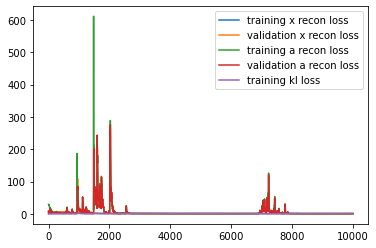

In [8]:
# plt.plot(np.arange(epochs),train_loss_ep)
# plt.plot(np.arange(epochs),val_loss_ep)
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
plt.plot(np.arange(epochs),train_loss_a_ep)
plt.plot(np.arange(epochs),val_loss_a_ep)
plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.plot(np.arange(epochs),np.array(train_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_clf_ep)*clfweight)
# plt.plot(np.arange(epochs),np.array(val_loss_clf_ep)*clfweight)
# plt.ylim((0,15))
# plt.xlim((0,3000))
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
# plt.legend(['training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training classifier loss','validation classifier loss'],loc='upper right')
plt.legend(['training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_xa.jpg'))
plt.show()


In [8]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
# np.argmin(val_loss_x_ep[:])
# # np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_a_ep[8700]
torch.log(torch.tensor([1/0]))

ZeroDivisionError: division by zero

In [9]:
testepoch=9990
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in sampleidx.keys():
    print(s)
    
    adj_norm=adjnormlist[s].cuda().float()
    adj_label=adj_list[s].cuda().float()
    features=featureslist[s+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[s]
    norm=normlist[s]
    
    if 'dca' in model_str:
        features_raw=features_raw_list[s+'X_raw'].cuda()
    num_nodes,num_features = features.shape
    maskpath=os.path.join(savedir,'trainMask',s+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    
    if s in training_samples:
        test_nodes_idx_s=test_nodes_idx
    else:
        test_nodes_idx_s=torch.tensor(np.arange(num_nodes))
        
#     adj_decode=None
#     if adj_decodeName == 'gala':
#         adj_decode=preprocessing.preprocess_graph_sharp(adj)

    if adj_decodeName==None:
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    else:
        adj_decode=adj_decode.cuda()
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    if adv and (s in list(sampleLabellist_ae.keys())):
        sampleLabel_ae=sampleLabellist_ae[s].cuda().float()
        modelAdv.eval()
        advOut=modelAdv(z)
    if 'dca' in model_str:
        if 'NB' in name:
            loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight)
        else:
            loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,mse)
    loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx_s)
    loss_test = loss_x_test+loss_a_test
    
    if adv and (s in list(sampleLabellist_ae.keys())):
        loss_adv_test=loss_adv(advOut,sampleLabel_ae,test_nodes_idx)
        print('loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
        
    print('test results',
          'loss_test: {:.4f}'.format(loss_test.item()),
          'loss_x_test: {:.4f}'.format(loss_x_test.item()),
          'loss_a_test: {:.4f}'.format(loss_a_test.item()))
#          'loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
    if protein:
        test_nodes_idx_s_genes=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_genes[2112:]=0
        test_nodes_idx_s_proteins=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_proteins[:2112]=0
        if 'dca' in model_str:
            loss_genes_test=loss_x(features_recon, features,test_nodes_idx_s_genes,XreconWeight,ridgeL,features_raw)
            loss_proteins_test=loss_x(features_recon, features,test_nodes_idx_s_proteins,XreconWeight,ridgeL,features_raw)
        print('loss_x_genes: {:.4f}'.format(loss_genes_test.item()),
          'loss_x_proteins: {:.4f}'.format(loss_proteins_test.item()))
    if 'dca' in model_str:
        features_raw=features_raw.cpu()

   

disease13
test results loss_test: 1.9392 loss_x_test: 1.4420 loss_a_test: 0.4972
control13
test results loss_test: 1.8359 loss_x_test: 1.3490 loss_a_test: 0.4869
disease8
test results loss_test: 1.7116 loss_x_test: 1.2711 loss_a_test: 0.4405
control8
test results loss_test: 1.8593 loss_x_test: 1.3729 loss_a_test: 0.4864


In [12]:
y_true=features
y_true_raw=features_raw
preds=features_recon
mask=nodesmask=torch.tensor(np.arange(num_nodes))
reconWeight=20
eps = 1e-10

output,pi,theta,y_pred=preds
nb_case=optimizer.optimizer_nb(preds,y_true,mask,reconWeight,eps = 1e-10,ifmean=False)- torch.log(pi+eps)

zero_nb = torch.pow(theta/(theta+y_pred+eps), theta)
zero_case = -torch.log(pi + ((1.0-pi)*zero_nb)+eps)
result = torch.where(torch.lt(y_true_raw.cuda(), 1), zero_case, nb_case)

In [13]:
result[:8,:8]

tensor([[-0.0000e+00, 2.1077e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [1.1921e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.7968e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.7740e+00,
         1.1915e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.1921e-07, 1.1921e-07, 1.1921e-07, -0.0000e+00, 1.1921e-07, 1.1921e-07,
         1.1921e-07, 1.1921e-07],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.4272e+00, -0.0000e+00]], device='cuda:0', grad_fn=<Slic

In [14]:
features[:8,:8]

tensor([[-0.2504,  8.5853, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [ 5.5540, -0.1938, -0.1941, -0.1474, -0.1934,  3.1612,  1.2601, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717,  2.5718, -0.3465]],
       device='cuda:0')

In [15]:
zeroidx=(features_raw==0)
nonzeroidx=(features_raw!=0)
torch.sum(result[zeroidx])/torch.sum(result)

tensor(2.8589e-09, device='cuda:0', grad_fn=<DivBackward0>)

In [22]:
torch.sum(result[zeroidx])

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [1]:
# model.pi.weight[:8,:8]
ep

NameError: name 'ep' is not defined